In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
#     ###################################################### Q(s,a)= r + Q'(s',a') # max
#     ###################################################### ~Q(s,~a)= r # min
#     ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
#     targetQs = rewards + (gamma * aQs2_logits)
#     eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0000 rate:0.0460 aloss:0.6899 eloss:2.0310 aloss2:1.5252 exploreP:0.9977
Episode:1 meanR:23.5000 R:24.0000 rate:0.0480 aloss:0.6955 eloss:1.9980 aloss2:1.5495 exploreP:0.9954
Episode:2 meanR:20.6667 R:15.0000 rate:0.0300 aloss:0.6898 eloss:2.0407 aloss2:1.5045 exploreP:0.9939
Episode:3 meanR:22.7500 R:29.0000 rate:0.0580 aloss:0.6938 eloss:1.9970 aloss2:1.5449 exploreP:0.9910
Episode:4 meanR:24.0000 R:29.0000 rate:0.0580 aloss:0.6889 eloss:2.0134 aloss2:1.5201 exploreP:0.9882
Episode:5 meanR:25.0000 R:30.0000 rate:0.0600 aloss:0.6882 eloss:1.9792 aloss2:1.5424 exploreP:0.9853
Episode:6 meanR:24.4286 R:21.0000 rate:0.0420 aloss:0.6895 eloss:1.9856 aloss2:1.5207 exploreP:0.9832
Episode:7 meanR:24.0000 R:21.0000 rate:0.0420 aloss:0.6889 eloss:1.9811 aloss2:1.5273 exploreP:0.9812
Episode:8 meanR:25.6667 R:39.0000 rate:0.0780 aloss:0.6928 eloss:1.9553 aloss2:1.5415 exploreP:0.9774
Episode:9 meanR:27.2000 R:41.0000 rate:0.0820 aloss:0.6919 eloss:1.9371 aloss2:1.5

Episode:80 meanR:21.0494 R:23.0000 rate:0.0460 aloss:0.7122 eloss:1.3801 aloss2:2.4060 exploreP:0.8448
Episode:81 meanR:21.0732 R:23.0000 rate:0.0460 aloss:0.6960 eloss:1.4012 aloss2:2.4219 exploreP:0.8429
Episode:82 meanR:21.0120 R:16.0000 rate:0.0320 aloss:0.6944 eloss:1.3589 aloss2:2.5291 exploreP:0.8416
Episode:83 meanR:20.9405 R:15.0000 rate:0.0300 aloss:0.7099 eloss:1.3819 aloss2:2.4802 exploreP:0.8403
Episode:84 meanR:20.9412 R:21.0000 rate:0.0420 aloss:0.7121 eloss:1.3825 aloss2:2.4854 exploreP:0.8386
Episode:85 meanR:20.9535 R:22.0000 rate:0.0440 aloss:0.7001 eloss:1.3762 aloss2:2.4785 exploreP:0.8368
Episode:86 meanR:21.0805 R:32.0000 rate:0.0640 aloss:0.6934 eloss:1.3798 aloss2:2.4466 exploreP:0.8341
Episode:87 meanR:21.3977 R:49.0000 rate:0.0980 aloss:0.7064 eloss:1.3804 aloss2:2.5099 exploreP:0.8301
Episode:88 meanR:21.3258 R:15.0000 rate:0.0300 aloss:0.7073 eloss:1.3849 aloss2:2.5013 exploreP:0.8289
Episode:89 meanR:21.3000 R:19.0000 rate:0.0380 aloss:0.7190 eloss:1.3314 

Episode:159 meanR:21.2700 R:18.0000 rate:0.0360 aloss:0.6807 eloss:1.2574 aloss2:3.1416 exploreP:0.7096
Episode:160 meanR:21.2100 R:10.0000 rate:0.0200 aloss:0.6920 eloss:1.1938 aloss2:3.0952 exploreP:0.7089
Episode:161 meanR:21.1000 R:13.0000 rate:0.0260 aloss:0.6805 eloss:1.1857 aloss2:3.1113 exploreP:0.7080
Episode:162 meanR:21.1500 R:25.0000 rate:0.0500 aloss:0.6874 eloss:1.2502 aloss2:3.1210 exploreP:0.7062
Episode:163 meanR:21.2600 R:31.0000 rate:0.0620 aloss:0.6891 eloss:1.2013 aloss2:3.1310 exploreP:0.7041
Episode:164 meanR:21.4700 R:42.0000 rate:0.0840 aloss:0.6917 eloss:1.1960 aloss2:3.2022 exploreP:0.7012
Episode:165 meanR:21.5500 R:20.0000 rate:0.0400 aloss:0.6948 eloss:1.2295 aloss2:3.2256 exploreP:0.6998
Episode:166 meanR:21.6300 R:24.0000 rate:0.0480 aloss:0.6885 eloss:1.2091 aloss2:3.2072 exploreP:0.6981
Episode:167 meanR:21.7000 R:18.0000 rate:0.0360 aloss:0.7038 eloss:1.2490 aloss2:3.2313 exploreP:0.6969
Episode:168 meanR:21.7700 R:25.0000 rate:0.0500 aloss:0.6850 elo

Episode:238 meanR:23.7100 R:23.0000 rate:0.0460 aloss:0.6801 eloss:1.1881 aloss2:3.3528 exploreP:0.5870
Episode:239 meanR:23.6800 R:13.0000 rate:0.0260 aloss:0.6901 eloss:1.1954 aloss2:3.3806 exploreP:0.5862
Episode:240 meanR:23.6600 R:26.0000 rate:0.0520 aloss:0.6862 eloss:1.1986 aloss2:3.3612 exploreP:0.5847
Episode:241 meanR:23.7000 R:39.0000 rate:0.0780 aloss:0.6808 eloss:1.1948 aloss2:3.3364 exploreP:0.5825
Episode:242 meanR:24.1000 R:62.0000 rate:0.1240 aloss:0.6859 eloss:1.1850 aloss2:3.3464 exploreP:0.5790
Episode:243 meanR:24.0900 R:19.0000 rate:0.0380 aloss:0.6848 eloss:1.1975 aloss2:3.3282 exploreP:0.5779
Episode:244 meanR:24.1400 R:20.0000 rate:0.0400 aloss:0.6817 eloss:1.1865 aloss2:3.3444 exploreP:0.5767
Episode:245 meanR:24.3100 R:33.0000 rate:0.0660 aloss:0.6839 eloss:1.1818 aloss2:3.3473 exploreP:0.5749
Episode:246 meanR:24.2600 R:22.0000 rate:0.0440 aloss:0.6836 eloss:1.1798 aloss2:3.3251 exploreP:0.5736
Episode:247 meanR:24.4500 R:32.0000 rate:0.0640 aloss:0.7067 elo

Episode:317 meanR:46.3900 R:21.0000 rate:0.0420 aloss:0.6933 eloss:1.1743 aloss2:3.3853 exploreP:0.3928
Episode:318 meanR:46.3800 R:10.0000 rate:0.0200 aloss:0.7040 eloss:1.2247 aloss2:3.4032 exploreP:0.3924
Episode:319 meanR:46.3300 R:21.0000 rate:0.0420 aloss:0.7203 eloss:1.1705 aloss2:3.4078 exploreP:0.3916
Episode:320 meanR:46.8300 R:68.0000 rate:0.1360 aloss:0.6902 eloss:1.1921 aloss2:3.3944 exploreP:0.3890
Episode:321 meanR:46.7500 R:17.0000 rate:0.0340 aloss:0.6976 eloss:1.1659 aloss2:3.3933 exploreP:0.3883
Episode:322 meanR:46.9600 R:40.0000 rate:0.0800 aloss:0.7131 eloss:1.1703 aloss2:3.4205 exploreP:0.3868
Episode:323 meanR:47.3300 R:55.0000 rate:0.1100 aloss:0.6914 eloss:1.2243 aloss2:3.4303 exploreP:0.3848
Episode:324 meanR:48.3700 R:118.0000 rate:0.2360 aloss:0.6922 eloss:1.1816 aloss2:3.3939 exploreP:0.3804
Episode:325 meanR:48.8000 R:88.0000 rate:0.1760 aloss:0.6816 eloss:1.1775 aloss2:3.4096 exploreP:0.3771
Episode:326 meanR:49.2800 R:86.0000 rate:0.1720 aloss:0.6845 el

Episode:396 meanR:38.0300 R:26.0000 rate:0.0520 aloss:0.7204 eloss:1.2049 aloss2:3.3736 exploreP:0.2827
Episode:397 meanR:38.1100 R:22.0000 rate:0.0440 aloss:0.7086 eloss:1.1839 aloss2:3.3750 exploreP:0.2821
Episode:398 meanR:37.9800 R:9.0000 rate:0.0180 aloss:0.7196 eloss:1.1617 aloss2:3.4053 exploreP:0.2818
Episode:399 meanR:38.0300 R:18.0000 rate:0.0360 aloss:0.7164 eloss:1.1687 aloss2:3.3989 exploreP:0.2813
Episode:400 meanR:38.0500 R:18.0000 rate:0.0360 aloss:0.6935 eloss:1.2899 aloss2:3.4099 exploreP:0.2809
Episode:401 meanR:37.8800 R:10.0000 rate:0.0200 aloss:0.7116 eloss:1.1510 aloss2:3.3928 exploreP:0.2806
Episode:402 meanR:38.0300 R:27.0000 rate:0.0540 aloss:0.6938 eloss:1.2683 aloss2:3.4034 exploreP:0.2799
Episode:403 meanR:38.6700 R:83.0000 rate:0.1660 aloss:0.6951 eloss:1.2021 aloss2:3.3735 exploreP:0.2776
Episode:404 meanR:39.2500 R:70.0000 rate:0.1400 aloss:0.6940 eloss:1.1920 aloss2:3.3870 exploreP:0.2758
Episode:405 meanR:39.8900 R:78.0000 rate:0.1560 aloss:0.6905 elos

Episode:475 meanR:71.6400 R:128.0000 rate:0.2560 aloss:0.9615 eloss:1.2384 aloss2:3.2171 exploreP:0.1476
Episode:476 meanR:72.1000 R:57.0000 rate:0.1140 aloss:0.8745 eloss:1.2530 aloss2:3.2376 exploreP:0.1468
Episode:477 meanR:72.8800 R:87.0000 rate:0.1740 aloss:0.9256 eloss:1.2573 aloss2:3.2363 exploreP:0.1456
Episode:478 meanR:73.4100 R:61.0000 rate:0.1220 aloss:0.9935 eloss:1.2182 aloss2:3.2321 exploreP:0.1448
Episode:479 meanR:74.6600 R:135.0000 rate:0.2700 aloss:0.9024 eloss:1.2646 aloss2:3.2432 exploreP:0.1430
Episode:480 meanR:75.1300 R:56.0000 rate:0.1120 aloss:0.8717 eloss:1.2701 aloss2:3.2228 exploreP:0.1422
Episode:481 meanR:76.2400 R:124.0000 rate:0.2480 aloss:0.8544 eloss:1.2486 aloss2:3.2277 exploreP:0.1406
Episode:482 meanR:76.7200 R:66.0000 rate:0.1320 aloss:0.8496 eloss:1.2732 aloss2:3.2203 exploreP:0.1397
Episode:483 meanR:77.7900 R:135.0000 rate:0.2700 aloss:0.8859 eloss:1.2334 aloss2:3.2220 exploreP:0.1380
Episode:484 meanR:78.2500 R:68.0000 rate:0.1360 aloss:0.8384

Episode:554 meanR:90.5900 R:9.0000 rate:0.0180 aloss:0.7088 eloss:1.1628 aloss2:3.0833 exploreP:0.0788
Episode:555 meanR:89.9000 R:9.0000 rate:0.0180 aloss:0.7306 eloss:1.2339 aloss2:3.0814 exploreP:0.0787
Episode:556 meanR:89.4800 R:10.0000 rate:0.0200 aloss:0.7422 eloss:1.3370 aloss2:3.0866 exploreP:0.0786
Episode:557 meanR:89.0400 R:10.0000 rate:0.0200 aloss:0.7923 eloss:1.1720 aloss2:3.0884 exploreP:0.0786
Episode:558 meanR:88.6900 R:10.0000 rate:0.0200 aloss:0.7520 eloss:1.1811 aloss2:3.0780 exploreP:0.0785
Episode:559 meanR:88.1700 R:8.0000 rate:0.0160 aloss:0.7800 eloss:1.3219 aloss2:3.0990 exploreP:0.0784
Episode:560 meanR:87.4000 R:10.0000 rate:0.0200 aloss:0.7631 eloss:1.2822 aloss2:3.1275 exploreP:0.0784
Episode:561 meanR:86.7700 R:11.0000 rate:0.0220 aloss:0.7659 eloss:1.2817 aloss2:3.1004 exploreP:0.0783
Episode:562 meanR:85.9600 R:10.0000 rate:0.0200 aloss:0.7757 eloss:1.2493 aloss2:3.1001 exploreP:0.0782
Episode:563 meanR:85.4300 R:9.0000 rate:0.0180 aloss:0.7630 eloss:1

Episode:633 meanR:57.8600 R:111.0000 rate:0.2220 aloss:0.6999 eloss:1.3390 aloss2:3.0331 exploreP:0.0573
Episode:634 meanR:58.5400 R:96.0000 rate:0.1920 aloss:0.6998 eloss:1.2695 aloss2:3.0531 exploreP:0.0568
Episode:635 meanR:59.2600 R:101.0000 rate:0.2020 aloss:0.7194 eloss:1.2598 aloss2:3.0623 exploreP:0.0563
Episode:636 meanR:59.6500 R:61.0000 rate:0.1220 aloss:0.7269 eloss:1.3420 aloss2:3.0822 exploreP:0.0561
Episode:637 meanR:62.9500 R:360.0000 rate:0.7200 aloss:0.7116 eloss:1.3071 aloss2:3.0781 exploreP:0.0544
Episode:638 meanR:63.2300 R:104.0000 rate:0.2080 aloss:0.6991 eloss:1.3117 aloss2:3.0545 exploreP:0.0540
Episode:639 meanR:63.4500 R:82.0000 rate:0.1640 aloss:0.7009 eloss:1.3232 aloss2:3.0544 exploreP:0.0536
Episode:640 meanR:63.6600 R:112.0000 rate:0.2240 aloss:0.7016 eloss:1.3682 aloss2:3.0365 exploreP:0.0531
Episode:641 meanR:67.1400 R:464.0000 rate:0.9280 aloss:0.7064 eloss:1.3210 aloss2:3.0226 exploreP:0.0512
Episode:642 meanR:66.2100 R:47.0000 rate:0.0940 aloss:0.70

Episode:711 meanR:173.8300 R:99.0000 rate:0.1980 aloss:0.6798 eloss:1.5246 aloss2:2.7225 exploreP:0.0214
Episode:712 meanR:174.3100 R:255.0000 rate:0.5100 aloss:0.6974 eloss:1.4337 aloss2:2.7291 exploreP:0.0211
Episode:713 meanR:176.5700 R:316.0000 rate:0.6320 aloss:0.6811 eloss:1.4553 aloss2:2.7490 exploreP:0.0208
Episode:714 meanR:176.5600 R:131.0000 rate:0.2620 aloss:0.6739 eloss:1.4660 aloss2:2.7308 exploreP:0.0207
Episode:715 meanR:180.9200 R:500.0000 rate:1.0000 aloss:0.6824 eloss:1.4700 aloss2:2.7320 exploreP:0.0201
Episode:716 meanR:180.1500 R:149.0000 rate:0.2980 aloss:0.6783 eloss:1.4856 aloss2:2.7090 exploreP:0.0200
Episode:717 meanR:184.1200 R:500.0000 rate:1.0000 aloss:0.6784 eloss:1.4804 aloss2:2.6991 exploreP:0.0195
Episode:718 meanR:183.9400 R:185.0000 rate:0.3700 aloss:0.6918 eloss:1.4953 aloss2:2.6852 exploreP:0.0193
Episode:719 meanR:184.3600 R:162.0000 rate:0.3240 aloss:0.6774 eloss:1.4753 aloss2:2.7046 exploreP:0.0192
Episode:720 meanR:186.4200 R:352.0000 rate:0.70

Episode:789 meanR:264.2400 R:113.0000 rate:0.2260 aloss:0.5737 eloss:1.7126 aloss2:2.3327 exploreP:0.0113
Episode:790 meanR:263.9000 R:146.0000 rate:0.2920 aloss:0.6010 eloss:1.6858 aloss2:2.3155 exploreP:0.0113
Episode:791 meanR:264.0400 R:232.0000 rate:0.4640 aloss:0.6062 eloss:1.6766 aloss2:2.3203 exploreP:0.0113
Episode:792 meanR:262.8100 R:229.0000 rate:0.4580 aloss:0.6264 eloss:1.6430 aloss2:2.3381 exploreP:0.0113
Episode:793 meanR:260.5500 R:95.0000 rate:0.1900 aloss:0.6454 eloss:1.5893 aloss2:2.3663 exploreP:0.0112
Episode:794 meanR:259.0300 R:122.0000 rate:0.2440 aloss:0.5676 eloss:1.7275 aloss2:2.3248 exploreP:0.0112
Episode:795 meanR:257.4200 R:119.0000 rate:0.2380 aloss:0.5769 eloss:1.7397 aloss2:2.3075 exploreP:0.0112
Episode:796 meanR:257.1700 R:190.0000 rate:0.3800 aloss:0.6071 eloss:1.7238 aloss2:2.2952 exploreP:0.0112
Episode:797 meanR:256.5900 R:95.0000 rate:0.1900 aloss:0.5800 eloss:1.7526 aloss2:2.2706 exploreP:0.0112
Episode:798 meanR:254.9600 R:128.0000 rate:0.256

Episode:867 meanR:187.0700 R:166.0000 rate:0.3320 aloss:0.5478 eloss:1.7824 aloss2:2.1385 exploreP:0.0104
Episode:868 meanR:187.3900 R:124.0000 rate:0.2480 aloss:0.5422 eloss:1.7381 aloss2:2.1547 exploreP:0.0103
Episode:869 meanR:187.0700 R:172.0000 rate:0.3440 aloss:0.5486 eloss:1.7975 aloss2:2.1574 exploreP:0.0103
Episode:870 meanR:186.3700 R:138.0000 rate:0.2760 aloss:0.5532 eloss:1.7472 aloss2:2.1490 exploreP:0.0103
Episode:871 meanR:186.2700 R:213.0000 rate:0.4260 aloss:0.5637 eloss:1.7587 aloss2:2.1650 exploreP:0.0103
Episode:872 meanR:186.7800 R:170.0000 rate:0.3400 aloss:0.5603 eloss:1.7261 aloss2:2.1688 exploreP:0.0103
Episode:873 meanR:185.1300 R:174.0000 rate:0.3480 aloss:0.5321 eloss:1.8144 aloss2:2.1365 exploreP:0.0103
Episode:874 meanR:186.1500 R:192.0000 rate:0.3840 aloss:0.5622 eloss:1.7329 aloss2:2.1805 exploreP:0.0103
Episode:875 meanR:187.2400 R:209.0000 rate:0.4180 aloss:0.5530 eloss:1.7596 aloss2:2.1777 exploreP:0.0103
Episode:876 meanR:185.7000 R:110.0000 rate:0.2

Episode:945 meanR:161.5300 R:97.0000 rate:0.1940 aloss:0.5034 eloss:1.7695 aloss2:2.0713 exploreP:0.0101
Episode:946 meanR:159.5300 R:91.0000 rate:0.1820 aloss:0.5021 eloss:1.8037 aloss2:2.0868 exploreP:0.0101
Episode:947 meanR:157.8200 R:98.0000 rate:0.1960 aloss:0.5111 eloss:1.7749 aloss2:2.1294 exploreP:0.0101
Episode:948 meanR:157.6900 R:104.0000 rate:0.2080 aloss:0.4996 eloss:1.8678 aloss2:2.0482 exploreP:0.0101
Episode:949 meanR:158.4100 R:206.0000 rate:0.4120 aloss:0.5018 eloss:1.8511 aloss2:2.0259 exploreP:0.0101
Episode:950 meanR:157.9700 R:97.0000 rate:0.1940 aloss:0.4732 eloss:1.8626 aloss2:1.9869 exploreP:0.0101
Episode:951 meanR:157.8000 R:82.0000 rate:0.1640 aloss:0.4777 eloss:1.8435 aloss2:1.9800 exploreP:0.0101
Episode:952 meanR:157.3300 R:122.0000 rate:0.2440 aloss:0.4931 eloss:1.8434 aloss2:1.9755 exploreP:0.0101
Episode:953 meanR:156.8500 R:102.0000 rate:0.2040 aloss:0.4886 eloss:1.8313 aloss2:2.0053 exploreP:0.0101
Episode:954 meanR:156.7400 R:102.0000 rate:0.2040 a

Episode:1023 meanR:166.6200 R:291.0000 rate:0.5820 aloss:0.4431 eloss:1.8966 aloss2:1.9256 exploreP:0.0100
Episode:1024 meanR:167.6900 R:265.0000 rate:0.5300 aloss:0.4441 eloss:1.8985 aloss2:1.9218 exploreP:0.0100
Episode:1025 meanR:168.7000 R:237.0000 rate:0.4740 aloss:0.4592 eloss:1.8863 aloss2:1.9039 exploreP:0.0100
Episode:1026 meanR:169.8600 R:203.0000 rate:0.4060 aloss:0.4470 eloss:1.8886 aloss2:1.9087 exploreP:0.0100
Episode:1027 meanR:170.4600 R:284.0000 rate:0.5680 aloss:0.4503 eloss:1.8802 aloss2:1.9278 exploreP:0.0100
Episode:1028 meanR:171.7400 R:216.0000 rate:0.4320 aloss:0.4497 eloss:1.8696 aloss2:1.9405 exploreP:0.0100
Episode:1029 meanR:172.0200 R:193.0000 rate:0.3860 aloss:0.4549 eloss:1.9058 aloss2:1.9156 exploreP:0.0100
Episode:1030 meanR:171.9300 R:154.0000 rate:0.3080 aloss:0.4400 eloss:1.9072 aloss2:1.8975 exploreP:0.0100
Episode:1031 meanR:170.9000 R:187.0000 rate:0.3740 aloss:0.4593 eloss:1.8642 aloss2:1.9394 exploreP:0.0100
Episode:1032 meanR:171.2600 R:157.000

Episode:1100 meanR:174.0600 R:182.0000 rate:0.3640 aloss:0.4233 eloss:1.8630 aloss2:2.1228 exploreP:0.0100
Episode:1101 meanR:174.0500 R:126.0000 rate:0.2520 aloss:0.4187 eloss:1.8647 aloss2:2.0252 exploreP:0.0100
Episode:1102 meanR:172.9800 R:120.0000 rate:0.2400 aloss:0.4195 eloss:1.8876 aloss2:2.0363 exploreP:0.0100
Episode:1103 meanR:172.7900 R:215.0000 rate:0.4300 aloss:0.4096 eloss:1.8639 aloss2:2.0029 exploreP:0.0100
Episode:1104 meanR:173.0500 R:161.0000 rate:0.3220 aloss:0.4096 eloss:1.8642 aloss2:1.9998 exploreP:0.0100
Episode:1105 meanR:173.0200 R:169.0000 rate:0.3380 aloss:0.4127 eloss:1.8559 aloss2:2.0267 exploreP:0.0100
Episode:1106 meanR:171.0300 R:127.0000 rate:0.2540 aloss:0.4035 eloss:1.8682 aloss2:2.0519 exploreP:0.0100
Episode:1107 meanR:170.6400 R:184.0000 rate:0.3680 aloss:0.4074 eloss:1.8622 aloss2:2.1924 exploreP:0.0100
Episode:1108 meanR:169.6600 R:137.0000 rate:0.2740 aloss:0.4079 eloss:1.8910 aloss2:2.0523 exploreP:0.0100
Episode:1109 meanR:168.6700 R:91.0000

Episode:1177 meanR:154.0300 R:204.0000 rate:0.4080 aloss:0.4036 eloss:1.8342 aloss2:2.3463 exploreP:0.0100
Episode:1178 meanR:154.2600 R:166.0000 rate:0.3320 aloss:0.3979 eloss:1.8404 aloss2:2.2924 exploreP:0.0100
Episode:1179 meanR:154.3800 R:165.0000 rate:0.3300 aloss:0.3978 eloss:1.8258 aloss2:2.1645 exploreP:0.0100
Episode:1180 meanR:154.2600 R:179.0000 rate:0.3580 aloss:0.3776 eloss:1.8376 aloss2:2.1452 exploreP:0.0100
Episode:1181 meanR:154.4600 R:126.0000 rate:0.2520 aloss:0.3782 eloss:1.8053 aloss2:2.1692 exploreP:0.0100
Episode:1182 meanR:154.0000 R:106.0000 rate:0.2120 aloss:0.4073 eloss:1.7991 aloss2:2.3163 exploreP:0.0100
Episode:1183 meanR:153.5500 R:113.0000 rate:0.2260 aloss:0.3975 eloss:1.7931 aloss2:2.4388 exploreP:0.0100
Episode:1184 meanR:153.5100 R:123.0000 rate:0.2460 aloss:0.3841 eloss:1.8231 aloss2:2.1969 exploreP:0.0100
Episode:1185 meanR:154.1400 R:220.0000 rate:0.4400 aloss:0.3889 eloss:1.8499 aloss2:2.2572 exploreP:0.0100
Episode:1186 meanR:155.1600 R:306.000

Episode:1254 meanR:170.7900 R:190.0000 rate:0.3800 aloss:0.3487 eloss:1.8011 aloss2:2.1717 exploreP:0.0100
Episode:1255 meanR:172.0900 R:267.0000 rate:0.5340 aloss:0.3497 eloss:1.7873 aloss2:2.1889 exploreP:0.0100
Episode:1256 meanR:172.3200 R:138.0000 rate:0.2760 aloss:0.3563 eloss:1.7927 aloss2:2.3535 exploreP:0.0100
Episode:1257 meanR:172.1500 R:140.0000 rate:0.2800 aloss:0.3473 eloss:1.8042 aloss2:2.1970 exploreP:0.0100
Episode:1258 meanR:172.0200 R:96.0000 rate:0.1920 aloss:0.3442 eloss:1.7987 aloss2:2.2369 exploreP:0.0100
Episode:1259 meanR:171.8800 R:107.0000 rate:0.2140 aloss:0.3470 eloss:1.8082 aloss2:2.2524 exploreP:0.0100
Episode:1260 meanR:171.3600 R:99.0000 rate:0.1980 aloss:0.3478 eloss:1.8002 aloss2:2.1851 exploreP:0.0100
Episode:1261 meanR:172.9600 R:272.0000 rate:0.5440 aloss:0.3512 eloss:1.7942 aloss2:2.3657 exploreP:0.0100
Episode:1262 meanR:173.6600 R:179.0000 rate:0.3580 aloss:0.3374 eloss:1.7684 aloss2:2.2259 exploreP:0.0100
Episode:1263 meanR:173.5600 R:230.0000 

Episode:1331 meanR:173.5800 R:210.0000 rate:0.4200 aloss:0.3449 eloss:1.7533 aloss2:2.3727 exploreP:0.0100
Episode:1332 meanR:174.4100 R:200.0000 rate:0.4000 aloss:0.3502 eloss:1.7470 aloss2:2.3818 exploreP:0.0100
Episode:1333 meanR:175.2300 R:175.0000 rate:0.3500 aloss:0.3454 eloss:1.7499 aloss2:2.5357 exploreP:0.0100
Episode:1334 meanR:175.2700 R:12.0000 rate:0.0240 aloss:0.3641 eloss:1.7763 aloss2:2.3061 exploreP:0.0100
Episode:1335 meanR:174.6300 R:92.0000 rate:0.1840 aloss:0.3475 eloss:1.7454 aloss2:2.3413 exploreP:0.0100
Episode:1336 meanR:174.5900 R:193.0000 rate:0.3860 aloss:0.3397 eloss:1.7414 aloss2:2.3826 exploreP:0.0100
Episode:1337 meanR:175.0800 R:174.0000 rate:0.3480 aloss:0.3422 eloss:1.7325 aloss2:2.3912 exploreP:0.0100
Episode:1338 meanR:174.4500 R:113.0000 rate:0.2260 aloss:0.3451 eloss:1.7477 aloss2:2.4221 exploreP:0.0100
Episode:1339 meanR:174.4400 R:142.0000 rate:0.2840 aloss:0.3448 eloss:1.7356 aloss2:2.4278 exploreP:0.0100
Episode:1340 meanR:174.7800 R:232.0000 

Episode:1408 meanR:174.8600 R:265.0000 rate:0.5300 aloss:0.3712 eloss:1.7123 aloss2:2.3890 exploreP:0.0100
Episode:1409 meanR:175.6200 R:163.0000 rate:0.3260 aloss:0.3764 eloss:1.7097 aloss2:2.3790 exploreP:0.0100
Episode:1410 meanR:174.6600 R:165.0000 rate:0.3300 aloss:0.3657 eloss:1.7104 aloss2:2.3707 exploreP:0.0100
Episode:1411 meanR:173.4500 R:97.0000 rate:0.1940 aloss:0.3591 eloss:1.6956 aloss2:2.3975 exploreP:0.0100
Episode:1412 meanR:172.9800 R:90.0000 rate:0.1800 aloss:0.3678 eloss:1.6989 aloss2:2.3796 exploreP:0.0100
Episode:1413 meanR:173.2100 R:177.0000 rate:0.3540 aloss:0.3707 eloss:1.7232 aloss2:2.3885 exploreP:0.0100
Episode:1414 meanR:174.2900 R:205.0000 rate:0.4100 aloss:0.3633 eloss:1.7225 aloss2:2.3438 exploreP:0.0100
Episode:1415 meanR:175.4700 R:283.0000 rate:0.5660 aloss:0.3696 eloss:1.7017 aloss2:2.3835 exploreP:0.0100
Episode:1416 meanR:176.4100 R:284.0000 rate:0.5680 aloss:0.3651 eloss:1.7024 aloss2:2.4066 exploreP:0.0100
Episode:1417 meanR:177.8400 R:309.0000 

Episode:1485 meanR:211.3700 R:158.0000 rate:0.3160 aloss:0.3381 eloss:1.6276 aloss2:2.7293 exploreP:0.0100
Episode:1486 meanR:211.6300 R:175.0000 rate:0.3500 aloss:0.3334 eloss:1.6312 aloss2:2.7814 exploreP:0.0100
Episode:1487 meanR:209.9400 R:117.0000 rate:0.2340 aloss:0.3400 eloss:1.6377 aloss2:2.7559 exploreP:0.0100
Episode:1488 meanR:210.6200 R:164.0000 rate:0.3280 aloss:0.3465 eloss:1.6425 aloss2:2.7243 exploreP:0.0100
Episode:1489 meanR:210.5700 R:205.0000 rate:0.4100 aloss:0.3472 eloss:1.6432 aloss2:2.6837 exploreP:0.0100
Episode:1490 meanR:210.0800 R:184.0000 rate:0.3680 aloss:0.3472 eloss:1.6439 aloss2:2.7088 exploreP:0.0100
Episode:1491 meanR:210.6400 R:164.0000 rate:0.3280 aloss:0.3479 eloss:1.6287 aloss2:2.7551 exploreP:0.0100
Episode:1492 meanR:209.9200 R:212.0000 rate:0.4240 aloss:0.3393 eloss:1.6412 aloss2:2.7342 exploreP:0.0100
Episode:1493 meanR:210.2700 R:135.0000 rate:0.2700 aloss:0.3395 eloss:1.6356 aloss2:2.7270 exploreP:0.0100
Episode:1494 meanR:209.1900 R:141.000

Episode:1562 meanR:188.7300 R:253.0000 rate:0.5060 aloss:0.3461 eloss:1.6295 aloss2:2.8009 exploreP:0.0100
Episode:1563 meanR:187.9100 R:184.0000 rate:0.3680 aloss:0.3519 eloss:1.6196 aloss2:2.8311 exploreP:0.0100
Episode:1564 meanR:188.8100 R:352.0000 rate:0.7040 aloss:0.3516 eloss:1.6180 aloss2:2.8329 exploreP:0.0100
Episode:1565 meanR:189.0400 R:229.0000 rate:0.4580 aloss:0.3487 eloss:1.6212 aloss2:2.8472 exploreP:0.0100
Episode:1566 meanR:190.1000 R:224.0000 rate:0.4480 aloss:0.3545 eloss:1.6229 aloss2:2.8609 exploreP:0.0100
Episode:1567 meanR:189.7200 R:202.0000 rate:0.4040 aloss:0.3499 eloss:1.6172 aloss2:2.9165 exploreP:0.0100
Episode:1568 meanR:189.3100 R:116.0000 rate:0.2320 aloss:0.3574 eloss:1.6131 aloss2:2.9141 exploreP:0.0100
Episode:1569 meanR:191.8900 R:442.0000 rate:0.8840 aloss:0.3512 eloss:1.6104 aloss2:2.9014 exploreP:0.0100
Episode:1570 meanR:194.9000 R:407.0000 rate:0.8140 aloss:0.3466 eloss:1.6191 aloss2:2.8898 exploreP:0.0100
Episode:1571 meanR:197.2900 R:418.000

Episode:1639 meanR:204.2200 R:179.0000 rate:0.3580 aloss:0.3710 eloss:1.6504 aloss2:2.7729 exploreP:0.0100
Episode:1640 meanR:204.0300 R:164.0000 rate:0.3280 aloss:0.3702 eloss:1.6541 aloss2:2.7862 exploreP:0.0100
Episode:1641 meanR:207.6100 R:470.0000 rate:0.9400 aloss:0.3694 eloss:1.6618 aloss2:2.7932 exploreP:0.0100
Episode:1642 meanR:208.2000 R:164.0000 rate:0.3280 aloss:0.3664 eloss:1.6796 aloss2:2.7819 exploreP:0.0100
Episode:1643 meanR:209.5600 R:169.0000 rate:0.3380 aloss:0.3712 eloss:1.6581 aloss2:2.7257 exploreP:0.0100
Episode:1644 meanR:210.3800 R:191.0000 rate:0.3820 aloss:0.3676 eloss:1.6579 aloss2:2.8017 exploreP:0.0100
Episode:1645 meanR:209.9000 R:195.0000 rate:0.3900 aloss:0.3692 eloss:1.6629 aloss2:2.7946 exploreP:0.0100
Episode:1646 meanR:206.4500 R:155.0000 rate:0.3100 aloss:0.3697 eloss:1.6647 aloss2:2.7697 exploreP:0.0100
Episode:1647 meanR:207.0000 R:206.0000 rate:0.4120 aloss:0.3648 eloss:1.6647 aloss2:2.7969 exploreP:0.0100
Episode:1648 meanR:205.8400 R:194.000

Episode:1716 meanR:183.5800 R:201.0000 rate:0.4020 aloss:0.3567 eloss:1.6349 aloss2:3.0081 exploreP:0.0100
Episode:1717 meanR:183.6000 R:158.0000 rate:0.3160 aloss:0.3576 eloss:1.6323 aloss2:3.0096 exploreP:0.0100
Episode:1718 meanR:183.7000 R:175.0000 rate:0.3500 aloss:0.3570 eloss:1.6441 aloss2:2.9436 exploreP:0.0100
Episode:1719 meanR:184.1300 R:191.0000 rate:0.3820 aloss:0.3561 eloss:1.6344 aloss2:3.0022 exploreP:0.0100
Episode:1720 meanR:184.1100 R:205.0000 rate:0.4100 aloss:0.3583 eloss:1.6268 aloss2:3.0078 exploreP:0.0100
Episode:1721 meanR:184.2300 R:158.0000 rate:0.3160 aloss:0.3601 eloss:1.6405 aloss2:2.9754 exploreP:0.0100
Episode:1722 meanR:185.3900 R:273.0000 rate:0.5460 aloss:0.3575 eloss:1.6369 aloss2:3.0190 exploreP:0.0100
Episode:1723 meanR:185.9700 R:206.0000 rate:0.4120 aloss:0.3545 eloss:1.6371 aloss2:2.9743 exploreP:0.0100
Episode:1724 meanR:187.5000 R:345.0000 rate:0.6900 aloss:0.3556 eloss:1.6336 aloss2:3.0033 exploreP:0.0100
Episode:1725 meanR:187.7700 R:173.000

Episode:1793 meanR:179.0500 R:138.0000 rate:0.2760 aloss:0.3502 eloss:1.5896 aloss2:3.2151 exploreP:0.0100
Episode:1794 meanR:178.3000 R:144.0000 rate:0.2880 aloss:0.3481 eloss:1.5804 aloss2:3.2437 exploreP:0.0100
Episode:1795 meanR:178.2900 R:181.0000 rate:0.3620 aloss:0.3548 eloss:1.5913 aloss2:3.1741 exploreP:0.0100
Episode:1796 meanR:177.1900 R:140.0000 rate:0.2800 aloss:0.3548 eloss:1.5747 aloss2:3.2941 exploreP:0.0100
Episode:1797 meanR:177.0000 R:168.0000 rate:0.3360 aloss:0.3488 eloss:1.5750 aloss2:3.2830 exploreP:0.0100
Episode:1798 meanR:176.9500 R:183.0000 rate:0.3660 aloss:0.3496 eloss:1.5750 aloss2:3.2425 exploreP:0.0100
Episode:1799 meanR:177.1900 R:211.0000 rate:0.4220 aloss:0.3494 eloss:1.5750 aloss2:3.2693 exploreP:0.0100
Episode:1800 meanR:176.8800 R:140.0000 rate:0.2800 aloss:0.3501 eloss:1.5800 aloss2:3.2840 exploreP:0.0100
Episode:1801 meanR:177.2400 R:193.0000 rate:0.3860 aloss:0.3448 eloss:1.5647 aloss2:3.3699 exploreP:0.0100
Episode:1802 meanR:177.4200 R:168.000

Episode:1870 meanR:172.7700 R:172.0000 rate:0.3440 aloss:0.3272 eloss:1.5190 aloss2:3.8372 exploreP:0.0100
Episode:1871 meanR:172.6000 R:171.0000 rate:0.3420 aloss:0.3289 eloss:1.5209 aloss2:3.7825 exploreP:0.0100
Episode:1872 meanR:171.5600 R:143.0000 rate:0.2860 aloss:0.3250 eloss:1.5140 aloss2:3.8546 exploreP:0.0100
Episode:1873 meanR:171.7600 R:191.0000 rate:0.3820 aloss:0.3229 eloss:1.5228 aloss2:3.8665 exploreP:0.0100
Episode:1874 meanR:171.5600 R:157.0000 rate:0.3140 aloss:0.3221 eloss:1.5165 aloss2:3.8318 exploreP:0.0100
Episode:1875 meanR:170.5500 R:32.0000 rate:0.0640 aloss:0.3140 eloss:1.5109 aloss2:3.6757 exploreP:0.0100
Episode:1876 meanR:170.5900 R:172.0000 rate:0.3440 aloss:0.3237 eloss:1.5126 aloss2:3.8193 exploreP:0.0100
Episode:1877 meanR:170.6500 R:153.0000 rate:0.3060 aloss:0.3293 eloss:1.5213 aloss2:3.7690 exploreP:0.0100
Episode:1878 meanR:170.4800 R:156.0000 rate:0.3120 aloss:0.3216 eloss:1.5101 aloss2:3.9030 exploreP:0.0100
Episode:1879 meanR:170.2900 R:134.0000

Episode:1947 meanR:159.8500 R:172.0000 rate:0.3440 aloss:0.3102 eloss:1.4876 aloss2:4.2459 exploreP:0.0100
Episode:1948 meanR:158.9200 R:60.0000 rate:0.1200 aloss:0.3097 eloss:1.4841 aloss2:4.2104 exploreP:0.0100
Episode:1949 meanR:158.6500 R:127.0000 rate:0.2540 aloss:0.3119 eloss:1.4927 aloss2:4.1826 exploreP:0.0100
Episode:1950 meanR:159.2700 R:207.0000 rate:0.4140 aloss:0.3087 eloss:1.4771 aloss2:4.3065 exploreP:0.0100
Episode:1951 meanR:159.3400 R:166.0000 rate:0.3320 aloss:0.3074 eloss:1.4811 aloss2:4.2619 exploreP:0.0100
Episode:1952 meanR:159.0200 R:136.0000 rate:0.2720 aloss:0.3101 eloss:1.4824 aloss2:4.2675 exploreP:0.0100
Episode:1953 meanR:159.3400 R:192.0000 rate:0.3840 aloss:0.3059 eloss:1.4784 aloss2:4.3864 exploreP:0.0100
Episode:1954 meanR:158.9300 R:147.0000 rate:0.2940 aloss:0.3123 eloss:1.4909 aloss2:4.3244 exploreP:0.0100
Episode:1955 meanR:159.1600 R:161.0000 rate:0.3220 aloss:0.3091 eloss:1.4827 aloss2:4.3367 exploreP:0.0100
Episode:1956 meanR:160.3900 R:284.0000

Episode:2024 meanR:167.6500 R:185.0000 rate:0.3700 aloss:0.3090 eloss:1.4776 aloss2:4.9221 exploreP:0.0100
Episode:2025 meanR:167.8400 R:156.0000 rate:0.3120 aloss:0.3080 eloss:1.4791 aloss2:4.9762 exploreP:0.0100
Episode:2026 meanR:167.8700 R:153.0000 rate:0.3060 aloss:0.3038 eloss:1.4781 aloss2:5.1378 exploreP:0.0100
Episode:2027 meanR:166.6100 R:148.0000 rate:0.2960 aloss:0.3116 eloss:1.4882 aloss2:4.9055 exploreP:0.0100
Episode:2028 meanR:166.5200 R:175.0000 rate:0.3500 aloss:0.3043 eloss:1.4843 aloss2:5.0841 exploreP:0.0100
Episode:2029 meanR:166.0300 R:118.0000 rate:0.2360 aloss:0.3036 eloss:1.4877 aloss2:5.0280 exploreP:0.0100
Episode:2030 meanR:165.9200 R:147.0000 rate:0.2940 aloss:0.3117 eloss:1.4882 aloss2:4.9576 exploreP:0.0100
Episode:2031 meanR:165.8700 R:171.0000 rate:0.3420 aloss:0.3120 eloss:1.4843 aloss2:4.8815 exploreP:0.0100
Episode:2032 meanR:166.1200 R:182.0000 rate:0.3640 aloss:0.3096 eloss:1.4835 aloss2:4.9836 exploreP:0.0100
Episode:2033 meanR:165.8400 R:152.000

Episode:2101 meanR:170.4300 R:180.0000 rate:0.3600 aloss:0.3128 eloss:1.4801 aloss2:6.6658 exploreP:0.0100
Episode:2102 meanR:170.2600 R:157.0000 rate:0.3140 aloss:0.3150 eloss:1.4859 aloss2:6.2321 exploreP:0.0100
Episode:2103 meanR:170.7000 R:191.0000 rate:0.3820 aloss:0.3099 eloss:1.4799 aloss2:6.4904 exploreP:0.0100
Episode:2104 meanR:170.6600 R:128.0000 rate:0.2560 aloss:0.3072 eloss:1.4754 aloss2:7.1171 exploreP:0.0100
Episode:2105 meanR:171.3700 R:234.0000 rate:0.4680 aloss:0.3124 eloss:1.4836 aloss2:6.3228 exploreP:0.0100
Episode:2106 meanR:171.6500 R:158.0000 rate:0.3160 aloss:0.3074 eloss:1.4763 aloss2:6.9615 exploreP:0.0100
Episode:2107 meanR:171.7200 R:140.0000 rate:0.2800 aloss:0.3130 eloss:1.4799 aloss2:6.7443 exploreP:0.0100
Episode:2108 meanR:171.2500 R:152.0000 rate:0.3040 aloss:0.3103 eloss:1.4753 aloss2:6.4760 exploreP:0.0100
Episode:2109 meanR:171.7000 R:159.0000 rate:0.3180 aloss:0.3077 eloss:1.4740 aloss2:6.6638 exploreP:0.0100
Episode:2110 meanR:172.2000 R:202.000

Episode:2178 meanR:171.1200 R:121.0000 rate:0.2420 aloss:0.3053 eloss:1.4009 aloss2:10.6539 exploreP:0.0100
Episode:2179 meanR:170.9200 R:148.0000 rate:0.2960 aloss:0.3028 eloss:1.4082 aloss2:10.1183 exploreP:0.0100
Episode:2180 meanR:171.2100 R:177.0000 rate:0.3540 aloss:0.3020 eloss:1.4039 aloss2:8.8466 exploreP:0.0100
Episode:2181 meanR:170.4800 R:120.0000 rate:0.2400 aloss:0.3014 eloss:1.4054 aloss2:9.0967 exploreP:0.0100
Episode:2182 meanR:170.3900 R:130.0000 rate:0.2600 aloss:0.3048 eloss:1.4021 aloss2:8.5406 exploreP:0.0100
Episode:2183 meanR:169.7200 R:159.0000 rate:0.3180 aloss:0.2972 eloss:1.4040 aloss2:9.7800 exploreP:0.0100
Episode:2184 meanR:170.5900 R:216.0000 rate:0.4320 aloss:0.3042 eloss:1.4041 aloss2:9.4380 exploreP:0.0100
Episode:2185 meanR:170.4800 R:121.0000 rate:0.2420 aloss:0.2977 eloss:1.4024 aloss2:11.2394 exploreP:0.0100
Episode:2186 meanR:170.5000 R:126.0000 rate:0.2520 aloss:0.3089 eloss:1.4053 aloss2:8.4411 exploreP:0.0100
Episode:2187 meanR:170.6400 R:133.

Episode:2255 meanR:154.0000 R:142.0000 rate:0.2840 aloss:0.2927 eloss:1.4022 aloss2:8.2447 exploreP:0.0100
Episode:2256 meanR:154.4100 R:169.0000 rate:0.3380 aloss:0.2921 eloss:1.4034 aloss2:7.7563 exploreP:0.0100
Episode:2257 meanR:153.2000 R:155.0000 rate:0.3100 aloss:0.2915 eloss:1.3985 aloss2:8.0183 exploreP:0.0100
Episode:2258 meanR:154.4700 R:262.0000 rate:0.5240 aloss:0.2913 eloss:1.4055 aloss2:7.8792 exploreP:0.0100
Episode:2259 meanR:154.2100 R:116.0000 rate:0.2320 aloss:0.2932 eloss:1.4010 aloss2:8.2080 exploreP:0.0100
Episode:2260 meanR:153.8100 R:120.0000 rate:0.2400 aloss:0.2934 eloss:1.4018 aloss2:7.7907 exploreP:0.0100
Episode:2261 meanR:152.0200 R:122.0000 rate:0.2440 aloss:0.2934 eloss:1.3966 aloss2:7.8642 exploreP:0.0100
Episode:2262 meanR:150.8100 R:146.0000 rate:0.2920 aloss:0.2852 eloss:1.4031 aloss2:7.6106 exploreP:0.0100
Episode:2263 meanR:150.7900 R:123.0000 rate:0.2460 aloss:0.2880 eloss:1.4022 aloss2:7.6010 exploreP:0.0100
Episode:2264 meanR:150.6300 R:114.000

Episode:2332 meanR:150.6500 R:142.0000 rate:0.2840 aloss:0.2905 eloss:1.3884 aloss2:7.4175 exploreP:0.0100
Episode:2333 meanR:150.7600 R:127.0000 rate:0.2540 aloss:0.2912 eloss:1.3989 aloss2:6.8115 exploreP:0.0100
Episode:2334 meanR:150.8200 R:131.0000 rate:0.2620 aloss:0.2949 eloss:1.3833 aloss2:7.2699 exploreP:0.0100
Episode:2335 meanR:150.4200 R:113.0000 rate:0.2260 aloss:0.2883 eloss:1.3893 aloss2:6.9170 exploreP:0.0100
Episode:2336 meanR:150.6400 R:139.0000 rate:0.2780 aloss:0.2869 eloss:1.3929 aloss2:6.9506 exploreP:0.0100
Episode:2337 meanR:150.1900 R:117.0000 rate:0.2340 aloss:0.2875 eloss:1.3989 aloss2:7.0910 exploreP:0.0100
Episode:2338 meanR:150.4100 R:144.0000 rate:0.2880 aloss:0.2885 eloss:1.3943 aloss2:7.0828 exploreP:0.0100
Episode:2339 meanR:149.8900 R:147.0000 rate:0.2940 aloss:0.2869 eloss:1.3864 aloss2:7.4771 exploreP:0.0100
Episode:2340 meanR:150.3800 R:161.0000 rate:0.3220 aloss:0.2902 eloss:1.3937 aloss2:7.2033 exploreP:0.0100
Episode:2341 meanR:150.2100 R:115.000

Episode:2409 meanR:148.5900 R:111.0000 rate:0.2220 aloss:0.2844 eloss:1.3904 aloss2:6.9776 exploreP:0.0100
Episode:2410 meanR:148.4200 R:145.0000 rate:0.2900 aloss:0.2810 eloss:1.3875 aloss2:7.2880 exploreP:0.0100
Episode:2411 meanR:148.4300 R:150.0000 rate:0.3000 aloss:0.2868 eloss:1.3875 aloss2:7.3129 exploreP:0.0100
Episode:2412 meanR:148.1900 R:132.0000 rate:0.2640 aloss:0.2870 eloss:1.3854 aloss2:7.6146 exploreP:0.0100
Episode:2413 meanR:147.7500 R:117.0000 rate:0.2340 aloss:0.2919 eloss:1.3840 aloss2:7.0981 exploreP:0.0100
Episode:2414 meanR:147.7000 R:118.0000 rate:0.2360 aloss:0.2907 eloss:1.3869 aloss2:7.7588 exploreP:0.0100
Episode:2415 meanR:149.1800 R:301.0000 rate:0.6020 aloss:0.2863 eloss:1.3858 aloss2:7.1287 exploreP:0.0100
Episode:2416 meanR:149.2100 R:120.0000 rate:0.2400 aloss:0.2825 eloss:1.3873 aloss2:7.1925 exploreP:0.0100
Episode:2417 meanR:149.2300 R:120.0000 rate:0.2400 aloss:0.2860 eloss:1.3853 aloss2:7.4793 exploreP:0.0100
Episode:2418 meanR:149.4700 R:144.000

Episode:2486 meanR:154.0900 R:241.0000 rate:0.4820 aloss:0.2688 eloss:1.3719 aloss2:7.9394 exploreP:0.0100
Episode:2487 meanR:154.1100 R:125.0000 rate:0.2500 aloss:0.2661 eloss:1.3781 aloss2:8.4454 exploreP:0.0100
Episode:2488 meanR:154.5000 R:290.0000 rate:0.5800 aloss:0.2670 eloss:1.3683 aloss2:8.5207 exploreP:0.0100
Episode:2489 meanR:156.3400 R:300.0000 rate:0.6000 aloss:0.2668 eloss:1.3727 aloss2:8.1908 exploreP:0.0100
Episode:2490 meanR:156.2900 R:146.0000 rate:0.2920 aloss:0.2712 eloss:1.3709 aloss2:8.0050 exploreP:0.0100
Episode:2491 meanR:156.7200 R:158.0000 rate:0.3160 aloss:0.2633 eloss:1.3735 aloss2:8.3708 exploreP:0.0100
Episode:2492 meanR:156.7000 R:120.0000 rate:0.2400 aloss:0.2658 eloss:1.3735 aloss2:8.3032 exploreP:0.0100
Episode:2493 meanR:156.4200 R:111.0000 rate:0.2220 aloss:0.2637 eloss:1.3722 aloss2:8.9593 exploreP:0.0100
Episode:2494 meanR:156.5100 R:144.0000 rate:0.2880 aloss:0.2637 eloss:1.3699 aloss2:8.3509 exploreP:0.0100
Episode:2495 meanR:156.4900 R:145.000

Episode:2563 meanR:143.3300 R:108.0000 rate:0.2160 aloss:0.2508 eloss:1.3650 aloss2:8.8154 exploreP:0.0100
Episode:2564 meanR:141.3300 R:117.0000 rate:0.2340 aloss:0.2522 eloss:1.3613 aloss2:8.4841 exploreP:0.0100
Episode:2565 meanR:141.1800 R:119.0000 rate:0.2380 aloss:0.2560 eloss:1.3664 aloss2:8.4810 exploreP:0.0100
Episode:2566 meanR:141.9200 R:188.0000 rate:0.3760 aloss:0.2516 eloss:1.3683 aloss2:8.5211 exploreP:0.0100
Episode:2567 meanR:140.5600 R:114.0000 rate:0.2280 aloss:0.2559 eloss:1.3666 aloss2:8.6114 exploreP:0.0100
Episode:2568 meanR:141.3500 R:299.0000 rate:0.5980 aloss:0.2508 eloss:1.3693 aloss2:8.6922 exploreP:0.0100
Episode:2569 meanR:142.5100 R:252.0000 rate:0.5040 aloss:0.2506 eloss:1.3670 aloss2:8.7408 exploreP:0.0100
Episode:2570 meanR:143.3800 R:205.0000 rate:0.4100 aloss:0.2616 eloss:1.3676 aloss2:8.3923 exploreP:0.0100
Episode:2571 meanR:143.4600 R:121.0000 rate:0.2420 aloss:0.2593 eloss:1.3715 aloss2:8.3388 exploreP:0.0100
Episode:2572 meanR:143.3600 R:151.000

Episode:2640 meanR:143.7400 R:208.0000 rate:0.4160 aloss:0.2641 eloss:1.3711 aloss2:8.2358 exploreP:0.0100
Episode:2641 meanR:143.6900 R:133.0000 rate:0.2660 aloss:0.2636 eloss:1.3758 aloss2:8.4038 exploreP:0.0100
Episode:2642 meanR:143.9800 R:141.0000 rate:0.2820 aloss:0.2686 eloss:1.3730 aloss2:7.9293 exploreP:0.0100
Episode:2643 meanR:144.1200 R:137.0000 rate:0.2740 aloss:0.2623 eloss:1.3755 aloss2:8.1334 exploreP:0.0100
Episode:2644 meanR:145.2100 R:220.0000 rate:0.4400 aloss:0.2605 eloss:1.3735 aloss2:8.8342 exploreP:0.0100
Episode:2645 meanR:144.8300 R:114.0000 rate:0.2280 aloss:0.2661 eloss:1.3685 aloss2:8.5172 exploreP:0.0100
Episode:2646 meanR:144.9900 R:128.0000 rate:0.2560 aloss:0.2650 eloss:1.3712 aloss2:7.9495 exploreP:0.0100
Episode:2647 meanR:145.3500 R:143.0000 rate:0.2860 aloss:0.2648 eloss:1.3776 aloss2:7.9811 exploreP:0.0100
Episode:2648 meanR:145.6300 R:173.0000 rate:0.3460 aloss:0.2676 eloss:1.3700 aloss2:8.1949 exploreP:0.0100
Episode:2649 meanR:145.5500 R:127.000

Episode:2717 meanR:151.1100 R:152.0000 rate:0.3040 aloss:0.2755 eloss:1.3851 aloss2:7.3440 exploreP:0.0100
Episode:2718 meanR:151.1600 R:160.0000 rate:0.3200 aloss:0.2800 eloss:1.3785 aloss2:7.3012 exploreP:0.0100
Episode:2719 meanR:150.6100 R:208.0000 rate:0.4160 aloss:0.2807 eloss:1.3775 aloss2:7.0257 exploreP:0.0100
Episode:2720 meanR:150.3700 R:122.0000 rate:0.2440 aloss:0.2789 eloss:1.3973 aloss2:7.0637 exploreP:0.0100
Episode:2721 meanR:149.1600 R:93.0000 rate:0.1860 aloss:0.2839 eloss:1.3895 aloss2:6.9273 exploreP:0.0100
Episode:2722 meanR:149.2500 R:139.0000 rate:0.2780 aloss:0.2833 eloss:1.3861 aloss2:7.2874 exploreP:0.0100
Episode:2723 meanR:148.5400 R:125.0000 rate:0.2500 aloss:0.2778 eloss:1.3888 aloss2:7.1240 exploreP:0.0100
Episode:2724 meanR:148.2000 R:138.0000 rate:0.2760 aloss:0.2780 eloss:1.3861 aloss2:7.2225 exploreP:0.0100
Episode:2725 meanR:147.6700 R:132.0000 rate:0.2640 aloss:0.2828 eloss:1.3823 aloss2:7.4230 exploreP:0.0100
Episode:2726 meanR:147.6800 R:116.0000

Episode:2794 meanR:141.8400 R:117.0000 rate:0.2340 aloss:0.2889 eloss:1.3965 aloss2:6.6019 exploreP:0.0100
Episode:2795 meanR:142.1300 R:133.0000 rate:0.2660 aloss:0.2909 eloss:1.3906 aloss2:6.6956 exploreP:0.0100
Episode:2796 meanR:140.0700 R:131.0000 rate:0.2620 aloss:0.2916 eloss:1.3923 aloss2:6.9759 exploreP:0.0100
Episode:2797 meanR:140.2800 R:160.0000 rate:0.3200 aloss:0.2888 eloss:1.3948 aloss2:6.6075 exploreP:0.0100
Episode:2798 meanR:139.5900 R:105.0000 rate:0.2100 aloss:0.2879 eloss:1.3847 aloss2:6.4689 exploreP:0.0100
Episode:2799 meanR:139.4200 R:92.0000 rate:0.1840 aloss:0.2912 eloss:1.3993 aloss2:6.2672 exploreP:0.0100
Episode:2800 meanR:139.3800 R:151.0000 rate:0.3020 aloss:0.2920 eloss:1.3934 aloss2:6.5186 exploreP:0.0100
Episode:2801 meanR:138.6500 R:113.0000 rate:0.2260 aloss:0.2911 eloss:1.3843 aloss2:6.5823 exploreP:0.0100
Episode:2802 meanR:139.0500 R:150.0000 rate:0.3000 aloss:0.2943 eloss:1.3989 aloss2:6.4665 exploreP:0.0100
Episode:2803 meanR:138.8300 R:183.0000

Episode:2871 meanR:135.7200 R:76.0000 rate:0.1520 aloss:0.2970 eloss:1.3939 aloss2:6.0553 exploreP:0.0100
Episode:2872 meanR:135.7800 R:154.0000 rate:0.3080 aloss:0.2958 eloss:1.3984 aloss2:6.1400 exploreP:0.0100
Episode:2873 meanR:135.1300 R:238.0000 rate:0.4760 aloss:0.2945 eloss:1.3928 aloss2:6.1639 exploreP:0.0100
Episode:2874 meanR:135.0300 R:103.0000 rate:0.2060 aloss:0.2919 eloss:1.4010 aloss2:6.2705 exploreP:0.0100
Episode:2875 meanR:135.1300 R:129.0000 rate:0.2580 aloss:0.2938 eloss:1.3992 aloss2:6.1040 exploreP:0.0100
Episode:2876 meanR:134.0900 R:95.0000 rate:0.1900 aloss:0.2965 eloss:1.4011 aloss2:6.4476 exploreP:0.0100
Episode:2877 meanR:133.8600 R:104.0000 rate:0.2080 aloss:0.3018 eloss:1.3925 aloss2:6.9347 exploreP:0.0100
Episode:2878 meanR:133.4400 R:124.0000 rate:0.2480 aloss:0.2945 eloss:1.3894 aloss2:6.1921 exploreP:0.0100
Episode:2879 meanR:133.3400 R:147.0000 rate:0.2940 aloss:0.2925 eloss:1.3941 aloss2:6.0671 exploreP:0.0100
Episode:2880 meanR:133.2500 R:96.0000 r

Episode:2948 meanR:141.8000 R:92.0000 rate:0.1840 aloss:0.2809 eloss:1.3951 aloss2:6.7850 exploreP:0.0100
Episode:2949 meanR:142.9000 R:215.0000 rate:0.4300 aloss:0.2868 eloss:1.3916 aloss2:6.6576 exploreP:0.0100
Episode:2950 meanR:142.5600 R:112.0000 rate:0.2240 aloss:0.2894 eloss:1.3911 aloss2:6.7057 exploreP:0.0100
Episode:2951 meanR:141.5600 R:87.0000 rate:0.1740 aloss:0.2846 eloss:1.3848 aloss2:6.7241 exploreP:0.0100
Episode:2952 meanR:140.6300 R:87.0000 rate:0.1740 aloss:0.2865 eloss:1.3800 aloss2:6.8378 exploreP:0.0100
Episode:2953 meanR:139.4400 R:86.0000 rate:0.1720 aloss:0.2789 eloss:1.3854 aloss2:6.6621 exploreP:0.0100
Episode:2954 meanR:139.4300 R:139.0000 rate:0.2780 aloss:0.2884 eloss:1.3976 aloss2:7.0665 exploreP:0.0100
Episode:2955 meanR:139.4800 R:122.0000 rate:0.2440 aloss:0.2857 eloss:1.3894 aloss2:6.7963 exploreP:0.0100
Episode:2956 meanR:139.4400 R:104.0000 rate:0.2080 aloss:0.2839 eloss:1.3889 aloss2:6.5845 exploreP:0.0100
Episode:2957 meanR:139.8200 R:131.0000 ra

Episode:3025 meanR:134.9600 R:205.0000 rate:0.4100 aloss:0.2861 eloss:1.3759 aloss2:7.2171 exploreP:0.0100
Episode:3026 meanR:135.6300 R:173.0000 rate:0.3460 aloss:0.2788 eloss:1.3769 aloss2:6.9955 exploreP:0.0100
Episode:3027 meanR:136.0800 R:173.0000 rate:0.3460 aloss:0.2834 eloss:1.3771 aloss2:7.1924 exploreP:0.0100
Episode:3028 meanR:138.0400 R:336.0000 rate:0.6720 aloss:0.2874 eloss:1.3786 aloss2:7.5151 exploreP:0.0100
Episode:3029 meanR:138.0700 R:108.0000 rate:0.2160 aloss:0.2879 eloss:1.3779 aloss2:7.1862 exploreP:0.0100
Episode:3030 meanR:139.9500 R:322.0000 rate:0.6440 aloss:0.2819 eloss:1.3767 aloss2:7.2865 exploreP:0.0100
Episode:3031 meanR:139.8900 R:112.0000 rate:0.2240 aloss:0.2837 eloss:1.3731 aloss2:7.3160 exploreP:0.0100
Episode:3032 meanR:137.8300 R:93.0000 rate:0.1860 aloss:0.2862 eloss:1.3795 aloss2:7.3016 exploreP:0.0100
Episode:3033 meanR:137.6500 R:86.0000 rate:0.1720 aloss:0.2898 eloss:1.3739 aloss2:7.3395 exploreP:0.0100
Episode:3034 meanR:138.0600 R:158.0000 

Episode:3102 meanR:133.0800 R:83.0000 rate:0.1660 aloss:0.2867 eloss:1.3766 aloss2:7.7954 exploreP:0.0100
Episode:3103 meanR:132.9300 R:92.0000 rate:0.1840 aloss:0.2881 eloss:1.3756 aloss2:7.7631 exploreP:0.0100
Episode:3104 meanR:133.0900 R:102.0000 rate:0.2040 aloss:0.2916 eloss:1.3802 aloss2:7.7856 exploreP:0.0100
Episode:3105 meanR:132.7900 R:104.0000 rate:0.2080 aloss:0.2838 eloss:1.3840 aloss2:7.7551 exploreP:0.0100
Episode:3106 meanR:133.6700 R:187.0000 rate:0.3740 aloss:0.2825 eloss:1.3839 aloss2:7.6973 exploreP:0.0100
Episode:3107 meanR:133.6400 R:115.0000 rate:0.2300 aloss:0.2831 eloss:1.3715 aloss2:7.7175 exploreP:0.0100
Episode:3108 meanR:133.4300 R:79.0000 rate:0.1580 aloss:0.2891 eloss:1.3665 aloss2:8.0176 exploreP:0.0100
Episode:3109 meanR:133.7700 R:178.0000 rate:0.3560 aloss:0.2852 eloss:1.3744 aloss2:7.7884 exploreP:0.0100
Episode:3110 meanR:133.7200 R:182.0000 rate:0.3640 aloss:0.2860 eloss:1.3707 aloss2:7.9496 exploreP:0.0100
Episode:3111 meanR:133.6700 R:110.0000 r

Episode:3179 meanR:121.1100 R:77.0000 rate:0.1540 aloss:0.2706 eloss:1.3673 aloss2:8.5293 exploreP:0.0100
Episode:3180 meanR:119.9700 R:94.0000 rate:0.1880 aloss:0.2805 eloss:1.3725 aloss2:8.6786 exploreP:0.0100
Episode:3181 meanR:120.6400 R:220.0000 rate:0.4400 aloss:0.2802 eloss:1.3723 aloss2:8.5733 exploreP:0.0100
Episode:3182 meanR:120.0500 R:85.0000 rate:0.1700 aloss:0.2756 eloss:1.3709 aloss2:8.6116 exploreP:0.0100
Episode:3183 meanR:119.8600 R:78.0000 rate:0.1560 aloss:0.2774 eloss:1.3707 aloss2:8.5603 exploreP:0.0100
Episode:3184 meanR:118.7600 R:100.0000 rate:0.2000 aloss:0.2795 eloss:1.3764 aloss2:8.9141 exploreP:0.0100
Episode:3185 meanR:117.2900 R:90.0000 rate:0.1800 aloss:0.2795 eloss:1.3755 aloss2:8.5868 exploreP:0.0100
Episode:3186 meanR:117.1900 R:87.0000 rate:0.1740 aloss:0.2785 eloss:1.3611 aloss2:8.5998 exploreP:0.0100
Episode:3187 meanR:118.1600 R:195.0000 rate:0.3900 aloss:0.2761 eloss:1.3600 aloss2:8.7386 exploreP:0.0100
Episode:3188 meanR:118.4400 R:120.0000 rate

Episode:3256 meanR:121.5800 R:85.0000 rate:0.1700 aloss:0.2691 eloss:1.3586 aloss2:9.1562 exploreP:0.0100
Episode:3257 meanR:121.0500 R:102.0000 rate:0.2040 aloss:0.2723 eloss:1.3679 aloss2:9.4556 exploreP:0.0100
Episode:3258 meanR:120.6900 R:90.0000 rate:0.1800 aloss:0.2730 eloss:1.3510 aloss2:9.2253 exploreP:0.0100
Episode:3259 meanR:120.5500 R:124.0000 rate:0.2480 aloss:0.2640 eloss:1.3499 aloss2:9.3325 exploreP:0.0100
Episode:3260 meanR:120.2700 R:98.0000 rate:0.1960 aloss:0.2691 eloss:1.3610 aloss2:9.5356 exploreP:0.0100
Episode:3261 meanR:120.1600 R:92.0000 rate:0.1840 aloss:0.2720 eloss:1.3573 aloss2:9.5476 exploreP:0.0100
Episode:3262 meanR:119.7300 R:65.0000 rate:0.1300 aloss:0.2796 eloss:1.3566 aloss2:9.7326 exploreP:0.0100
Episode:3263 meanR:119.7400 R:92.0000 rate:0.1840 aloss:0.2727 eloss:1.3632 aloss2:9.7612 exploreP:0.0100
Episode:3264 meanR:119.7100 R:118.0000 rate:0.2360 aloss:0.2762 eloss:1.3675 aloss2:9.9189 exploreP:0.0100
Episode:3265 meanR:120.3000 R:143.0000 rate

Episode:3333 meanR:120.7500 R:155.0000 rate:0.3100 aloss:0.2612 eloss:1.3537 aloss2:9.3070 exploreP:0.0100
Episode:3334 meanR:120.5700 R:172.0000 rate:0.3440 aloss:0.2644 eloss:1.3540 aloss2:9.2256 exploreP:0.0100
Episode:3335 meanR:120.8900 R:136.0000 rate:0.2720 aloss:0.2626 eloss:1.3533 aloss2:9.2924 exploreP:0.0100
Episode:3336 meanR:120.9300 R:98.0000 rate:0.1960 aloss:0.2648 eloss:1.3634 aloss2:9.1951 exploreP:0.0100
Episode:3337 meanR:119.7300 R:90.0000 rate:0.1800 aloss:0.2641 eloss:1.3567 aloss2:9.0124 exploreP:0.0100
Episode:3338 meanR:120.4500 R:186.0000 rate:0.3720 aloss:0.2708 eloss:1.3596 aloss2:9.0589 exploreP:0.0100
Episode:3339 meanR:120.2000 R:88.0000 rate:0.1760 aloss:0.2647 eloss:1.3576 aloss2:9.1214 exploreP:0.0100
Episode:3340 meanR:120.2800 R:80.0000 rate:0.1600 aloss:0.2632 eloss:1.3571 aloss2:8.8802 exploreP:0.0100
Episode:3341 meanR:120.1700 R:109.0000 rate:0.2180 aloss:0.2635 eloss:1.3573 aloss2:9.3746 exploreP:0.0100
Episode:3342 meanR:120.7400 R:171.0000 ra

Episode:3410 meanR:121.3500 R:95.0000 rate:0.1900 aloss:0.2846 eloss:1.3661 aloss2:8.0799 exploreP:0.0100
Episode:3411 meanR:120.9800 R:101.0000 rate:0.2020 aloss:0.2886 eloss:1.3681 aloss2:7.8957 exploreP:0.0100
Episode:3412 meanR:121.3700 R:123.0000 rate:0.2460 aloss:0.2723 eloss:1.3629 aloss2:7.8176 exploreP:0.0100
Episode:3413 meanR:120.4600 R:117.0000 rate:0.2340 aloss:0.2782 eloss:1.3637 aloss2:8.0728 exploreP:0.0100
Episode:3414 meanR:120.5100 R:110.0000 rate:0.2200 aloss:0.2761 eloss:1.3684 aloss2:7.9675 exploreP:0.0100
Episode:3415 meanR:120.5000 R:95.0000 rate:0.1900 aloss:0.2754 eloss:1.3659 aloss2:7.7321 exploreP:0.0100
Episode:3416 meanR:120.6700 R:100.0000 rate:0.2000 aloss:0.2717 eloss:1.3553 aloss2:7.8649 exploreP:0.0100
Episode:3417 meanR:120.5500 R:81.0000 rate:0.1620 aloss:0.2721 eloss:1.3609 aloss2:7.9754 exploreP:0.0100
Episode:3418 meanR:120.6500 R:106.0000 rate:0.2120 aloss:0.2767 eloss:1.3640 aloss2:7.9467 exploreP:0.0100
Episode:3419 meanR:120.2300 R:64.0000 ra

Episode:3487 meanR:119.8600 R:116.0000 rate:0.2320 aloss:0.2704 eloss:1.3662 aloss2:8.2959 exploreP:0.0100
Episode:3488 meanR:120.2600 R:111.0000 rate:0.2220 aloss:0.2738 eloss:1.3676 aloss2:8.6939 exploreP:0.0100
Episode:3489 meanR:120.3600 R:102.0000 rate:0.2040 aloss:0.2725 eloss:1.3658 aloss2:8.2687 exploreP:0.0100
Episode:3490 meanR:119.9900 R:88.0000 rate:0.1760 aloss:0.2725 eloss:1.3633 aloss2:8.1248 exploreP:0.0100
Episode:3491 meanR:122.0200 R:282.0000 rate:0.5640 aloss:0.2764 eloss:1.3652 aloss2:8.3790 exploreP:0.0100
Episode:3492 meanR:122.2200 R:108.0000 rate:0.2160 aloss:0.2720 eloss:1.3550 aloss2:8.4009 exploreP:0.0100
Episode:3493 meanR:120.1900 R:81.0000 rate:0.1620 aloss:0.2773 eloss:1.3591 aloss2:8.5334 exploreP:0.0100
Episode:3494 meanR:120.1300 R:95.0000 rate:0.1900 aloss:0.2695 eloss:1.3636 aloss2:8.1726 exploreP:0.0100
Episode:3495 meanR:121.5500 R:220.0000 rate:0.4400 aloss:0.2723 eloss:1.3674 aloss2:8.4266 exploreP:0.0100
Episode:3496 meanR:121.3000 R:71.0000 ra

Episode:3564 meanR:118.0500 R:75.0000 rate:0.1500 aloss:0.2626 eloss:1.3607 aloss2:8.8614 exploreP:0.0100
Episode:3565 meanR:117.9600 R:64.0000 rate:0.1280 aloss:0.2690 eloss:1.3683 aloss2:8.8959 exploreP:0.0100
Episode:3566 meanR:116.5600 R:64.0000 rate:0.1280 aloss:0.2687 eloss:1.3651 aloss2:8.9698 exploreP:0.0100
Episode:3567 meanR:115.6100 R:116.0000 rate:0.2320 aloss:0.2713 eloss:1.3653 aloss2:9.1544 exploreP:0.0100
Episode:3568 meanR:114.8300 R:103.0000 rate:0.2060 aloss:0.2643 eloss:1.3708 aloss2:8.9611 exploreP:0.0100
Episode:3569 meanR:113.6500 R:76.0000 rate:0.1520 aloss:0.2658 eloss:1.3678 aloss2:8.7543 exploreP:0.0100
Episode:3570 meanR:113.8200 R:101.0000 rate:0.2020 aloss:0.2628 eloss:1.3602 aloss2:9.6045 exploreP:0.0100
Episode:3571 meanR:113.4600 R:74.0000 rate:0.1480 aloss:0.2746 eloss:1.3693 aloss2:9.0411 exploreP:0.0100
Episode:3572 meanR:112.8600 R:81.0000 rate:0.1620 aloss:0.2681 eloss:1.3661 aloss2:9.4299 exploreP:0.0100
Episode:3573 meanR:114.6900 R:266.0000 rate

Episode:3642 meanR:103.9600 R:88.0000 rate:0.1760 aloss:0.2709 eloss:1.3752 aloss2:9.6129 exploreP:0.0100
Episode:3643 meanR:103.2800 R:76.0000 rate:0.1520 aloss:0.2657 eloss:1.3660 aloss2:9.3172 exploreP:0.0100
Episode:3644 meanR:103.4100 R:92.0000 rate:0.1840 aloss:0.2694 eloss:1.3614 aloss2:9.0688 exploreP:0.0100
Episode:3645 meanR:103.3200 R:68.0000 rate:0.1360 aloss:0.2619 eloss:1.3689 aloss2:9.6075 exploreP:0.0100
Episode:3646 meanR:104.4300 R:180.0000 rate:0.3600 aloss:0.2644 eloss:1.3672 aloss2:9.5065 exploreP:0.0100
Episode:3647 meanR:104.0600 R:60.0000 rate:0.1200 aloss:0.2613 eloss:1.3551 aloss2:8.9779 exploreP:0.0100
Episode:3648 meanR:104.0800 R:75.0000 rate:0.1500 aloss:0.2661 eloss:1.3562 aloss2:9.1574 exploreP:0.0100
Episode:3649 meanR:103.9800 R:86.0000 rate:0.1720 aloss:0.2705 eloss:1.3625 aloss2:9.3737 exploreP:0.0100
Episode:3650 meanR:102.6800 R:92.0000 rate:0.1840 aloss:0.2712 eloss:1.3660 aloss2:9.5151 exploreP:0.0100
Episode:3651 meanR:102.6300 R:79.0000 rate:0.

Episode:3720 meanR:102.6000 R:94.0000 rate:0.1880 aloss:0.2884 eloss:1.3819 aloss2:8.4996 exploreP:0.0100
Episode:3721 meanR:101.7700 R:93.0000 rate:0.1860 aloss:0.2906 eloss:1.3820 aloss2:8.9740 exploreP:0.0100
Episode:3722 meanR:100.8500 R:136.0000 rate:0.2720 aloss:0.2832 eloss:1.3798 aloss2:8.6417 exploreP:0.0100
Episode:3723 meanR:100.8700 R:93.0000 rate:0.1860 aloss:0.2782 eloss:1.3718 aloss2:8.6251 exploreP:0.0100
Episode:3724 meanR:101.0000 R:88.0000 rate:0.1760 aloss:0.2774 eloss:1.3684 aloss2:8.4492 exploreP:0.0100
Episode:3725 meanR:100.6000 R:88.0000 rate:0.1760 aloss:0.2789 eloss:1.3779 aloss2:8.8193 exploreP:0.0100
Episode:3726 meanR:100.1700 R:62.0000 rate:0.1240 aloss:0.2693 eloss:1.3653 aloss2:8.8082 exploreP:0.0100
Episode:3727 meanR:100.0800 R:66.0000 rate:0.1320 aloss:0.2780 eloss:1.3707 aloss2:9.1509 exploreP:0.0100
Episode:3728 meanR:102.2800 R:290.0000 rate:0.5800 aloss:0.2853 eloss:1.3768 aloss2:8.6237 exploreP:0.0100
Episode:3729 meanR:102.3900 R:71.0000 rate:0

Episode:3798 meanR:96.8000 R:108.0000 rate:0.2160 aloss:0.2759 eloss:1.3684 aloss2:9.4494 exploreP:0.0100
Episode:3799 meanR:97.4300 R:166.0000 rate:0.3320 aloss:0.2789 eloss:1.3671 aloss2:8.8925 exploreP:0.0100
Episode:3800 meanR:96.5100 R:47.0000 rate:0.0940 aloss:0.2663 eloss:1.3587 aloss2:9.1449 exploreP:0.0100
Episode:3801 meanR:96.1100 R:48.0000 rate:0.0960 aloss:0.2802 eloss:1.3630 aloss2:8.8625 exploreP:0.0100
Episode:3802 meanR:95.9500 R:56.0000 rate:0.1120 aloss:0.2718 eloss:1.3553 aloss2:8.8717 exploreP:0.0100
Episode:3803 meanR:96.0100 R:72.0000 rate:0.1440 aloss:0.2791 eloss:1.3795 aloss2:9.8069 exploreP:0.0100
Episode:3804 meanR:95.4000 R:78.0000 rate:0.1560 aloss:0.2787 eloss:1.3671 aloss2:8.9876 exploreP:0.0100
Episode:3805 meanR:95.4900 R:73.0000 rate:0.1460 aloss:0.2882 eloss:1.3687 aloss2:9.4190 exploreP:0.0100
Episode:3806 meanR:95.6900 R:108.0000 rate:0.2160 aloss:0.2726 eloss:1.3653 aloss2:9.0146 exploreP:0.0100
Episode:3807 meanR:95.5600 R:54.0000 rate:0.1080 alo

Episode:3876 meanR:89.2700 R:116.0000 rate:0.2320 aloss:0.2862 eloss:1.3700 aloss2:8.7031 exploreP:0.0100
Episode:3877 meanR:88.8000 R:49.0000 rate:0.0980 aloss:0.2829 eloss:1.3596 aloss2:8.6621 exploreP:0.0100
Episode:3878 meanR:87.6300 R:85.0000 rate:0.1700 aloss:0.2815 eloss:1.3616 aloss2:8.6439 exploreP:0.0100
Episode:3879 meanR:87.6300 R:76.0000 rate:0.1520 aloss:0.2798 eloss:1.3624 aloss2:8.7111 exploreP:0.0100
Episode:3880 meanR:87.6200 R:204.0000 rate:0.4080 aloss:0.2854 eloss:1.3674 aloss2:8.6065 exploreP:0.0100
Episode:3881 meanR:87.6000 R:79.0000 rate:0.1580 aloss:0.2806 eloss:1.3628 aloss2:8.6399 exploreP:0.0100
Episode:3882 meanR:87.7200 R:77.0000 rate:0.1540 aloss:0.2808 eloss:1.3569 aloss2:8.8027 exploreP:0.0100
Episode:3883 meanR:87.7200 R:72.0000 rate:0.1440 aloss:0.3031 eloss:1.3617 aloss2:8.8212 exploreP:0.0100
Episode:3884 meanR:87.8400 R:79.0000 rate:0.1580 aloss:0.2853 eloss:1.3634 aloss2:8.7625 exploreP:0.0100
Episode:3885 meanR:87.5500 R:56.0000 rate:0.1120 alos

Episode:3954 meanR:81.6300 R:107.0000 rate:0.2140 aloss:0.2910 eloss:1.3645 aloss2:8.4458 exploreP:0.0100
Episode:3955 meanR:81.8400 R:86.0000 rate:0.1720 aloss:0.2845 eloss:1.3618 aloss2:8.6907 exploreP:0.0100
Episode:3956 meanR:81.8000 R:85.0000 rate:0.1700 aloss:0.2793 eloss:1.3588 aloss2:8.5686 exploreP:0.0100
Episode:3957 meanR:80.6500 R:62.0000 rate:0.1240 aloss:0.2873 eloss:1.3656 aloss2:8.8270 exploreP:0.0100
Episode:3958 meanR:80.9800 R:103.0000 rate:0.2060 aloss:0.2809 eloss:1.3606 aloss2:8.8739 exploreP:0.0100
Episode:3959 meanR:81.3200 R:81.0000 rate:0.1620 aloss:0.2915 eloss:1.3617 aloss2:8.9308 exploreP:0.0100
Episode:3960 meanR:81.2000 R:59.0000 rate:0.1180 aloss:0.2960 eloss:1.3628 aloss2:8.7994 exploreP:0.0100
Episode:3961 meanR:80.7600 R:82.0000 rate:0.1640 aloss:0.2919 eloss:1.3663 aloss2:8.6751 exploreP:0.0100
Episode:3962 meanR:80.4100 R:35.0000 rate:0.0700 aloss:0.2903 eloss:1.3665 aloss2:9.5897 exploreP:0.0100
Episode:3963 meanR:80.4900 R:74.0000 rate:0.1480 alos

Episode:4032 meanR:75.0700 R:101.0000 rate:0.2020 aloss:0.2859 eloss:1.3679 aloss2:8.8660 exploreP:0.0100
Episode:4033 meanR:75.6200 R:108.0000 rate:0.2160 aloss:0.2841 eloss:1.3602 aloss2:8.8558 exploreP:0.0100
Episode:4034 meanR:75.7700 R:71.0000 rate:0.1420 aloss:0.2830 eloss:1.3563 aloss2:8.6622 exploreP:0.0100
Episode:4035 meanR:74.9000 R:61.0000 rate:0.1220 aloss:0.2884 eloss:1.3581 aloss2:9.0166 exploreP:0.0100
Episode:4036 meanR:75.8600 R:168.0000 rate:0.3360 aloss:0.2833 eloss:1.3565 aloss2:8.9537 exploreP:0.0100
Episode:4037 meanR:75.8100 R:109.0000 rate:0.2180 aloss:0.2859 eloss:1.3569 aloss2:8.8078 exploreP:0.0100
Episode:4038 meanR:75.8900 R:77.0000 rate:0.1540 aloss:0.2823 eloss:1.3630 aloss2:8.8119 exploreP:0.0100
Episode:4039 meanR:75.8100 R:38.0000 rate:0.0760 aloss:0.2831 eloss:1.3493 aloss2:9.1327 exploreP:0.0100
Episode:4040 meanR:75.7500 R:57.0000 rate:0.1140 aloss:0.2880 eloss:1.3519 aloss2:9.2901 exploreP:0.0100
Episode:4041 meanR:76.1800 R:118.0000 rate:0.2360 a

Episode:4110 meanR:70.4100 R:44.0000 rate:0.0880 aloss:0.2855 eloss:1.3484 aloss2:9.0768 exploreP:0.0100
Episode:4111 meanR:70.4800 R:58.0000 rate:0.1160 aloss:0.2851 eloss:1.3561 aloss2:10.3497 exploreP:0.0100
Episode:4112 meanR:70.3600 R:55.0000 rate:0.1100 aloss:0.2806 eloss:1.3504 aloss2:9.2643 exploreP:0.0100
Episode:4113 meanR:70.3400 R:66.0000 rate:0.1320 aloss:0.2927 eloss:1.3625 aloss2:10.0730 exploreP:0.0100
Episode:4114 meanR:69.2100 R:37.0000 rate:0.0740 aloss:0.2899 eloss:1.3650 aloss2:8.7352 exploreP:0.0100
Episode:4115 meanR:69.8100 R:120.0000 rate:0.2400 aloss:0.2883 eloss:1.3516 aloss2:9.0240 exploreP:0.0100
Episode:4116 meanR:69.5400 R:61.0000 rate:0.1220 aloss:0.2844 eloss:1.3672 aloss2:9.2279 exploreP:0.0100
Episode:4117 meanR:70.0400 R:108.0000 rate:0.2160 aloss:0.2865 eloss:1.3570 aloss2:9.0214 exploreP:0.0100
Episode:4118 meanR:70.0600 R:60.0000 rate:0.1200 aloss:0.2816 eloss:1.3572 aloss2:9.2525 exploreP:0.0100
Episode:4119 meanR:70.1900 R:59.0000 rate:0.1180 al

Episode:4188 meanR:69.2000 R:45.0000 rate:0.0900 aloss:0.2814 eloss:1.3515 aloss2:9.3399 exploreP:0.0100
Episode:4189 meanR:69.2200 R:54.0000 rate:0.1080 aloss:0.2823 eloss:1.3510 aloss2:9.6383 exploreP:0.0100
Episode:4190 meanR:69.0400 R:41.0000 rate:0.0820 aloss:0.2843 eloss:1.3639 aloss2:9.5310 exploreP:0.0100
Episode:4191 meanR:69.4100 R:102.0000 rate:0.2040 aloss:0.2792 eloss:1.3478 aloss2:9.2668 exploreP:0.0100
Episode:4192 meanR:69.3400 R:60.0000 rate:0.1200 aloss:0.2826 eloss:1.3585 aloss2:9.5028 exploreP:0.0100
Episode:4193 meanR:68.8700 R:41.0000 rate:0.0820 aloss:0.2886 eloss:1.3586 aloss2:8.9953 exploreP:0.0100
Episode:4194 meanR:68.9700 R:67.0000 rate:0.1340 aloss:0.2839 eloss:1.3501 aloss2:9.5859 exploreP:0.0100
Episode:4195 meanR:68.9200 R:60.0000 rate:0.1200 aloss:0.2825 eloss:1.3492 aloss2:9.4547 exploreP:0.0100
Episode:4196 meanR:68.3200 R:50.0000 rate:0.1000 aloss:0.2897 eloss:1.3566 aloss2:9.3672 exploreP:0.0100
Episode:4197 meanR:68.3100 R:62.0000 rate:0.1240 aloss

Episode:4266 meanR:67.1100 R:70.0000 rate:0.1400 aloss:0.2828 eloss:1.3359 aloss2:9.3275 exploreP:0.0100
Episode:4267 meanR:67.2200 R:55.0000 rate:0.1100 aloss:0.2822 eloss:1.3383 aloss2:9.6802 exploreP:0.0100
Episode:4268 meanR:67.1700 R:60.0000 rate:0.1200 aloss:0.2877 eloss:1.3582 aloss2:9.6029 exploreP:0.0100
Episode:4269 meanR:67.1200 R:66.0000 rate:0.1320 aloss:0.2826 eloss:1.3443 aloss2:9.4110 exploreP:0.0100
Episode:4270 meanR:66.9900 R:49.0000 rate:0.0980 aloss:0.2872 eloss:1.3540 aloss2:9.3532 exploreP:0.0100
Episode:4271 meanR:66.9900 R:81.0000 rate:0.1620 aloss:0.2813 eloss:1.3452 aloss2:9.9950 exploreP:0.0100
Episode:4272 meanR:66.8400 R:50.0000 rate:0.1000 aloss:0.2864 eloss:1.3551 aloss2:9.8047 exploreP:0.0100
Episode:4273 meanR:66.8400 R:77.0000 rate:0.1540 aloss:0.2907 eloss:1.3497 aloss2:9.8593 exploreP:0.0100
Episode:4274 meanR:66.8700 R:58.0000 rate:0.1160 aloss:0.2796 eloss:1.3534 aloss2:9.4209 exploreP:0.0100
Episode:4275 meanR:65.9700 R:49.0000 rate:0.0980 aloss:

Episode:4344 meanR:65.8400 R:56.0000 rate:0.1120 aloss:0.2832 eloss:1.3372 aloss2:9.7943 exploreP:0.0100
Episode:4345 meanR:65.6000 R:72.0000 rate:0.1440 aloss:0.2899 eloss:1.3537 aloss2:9.5119 exploreP:0.0100
Episode:4346 meanR:66.1100 R:91.0000 rate:0.1820 aloss:0.2857 eloss:1.3441 aloss2:9.9933 exploreP:0.0100
Episode:4347 meanR:66.1000 R:41.0000 rate:0.0820 aloss:0.2766 eloss:1.3347 aloss2:10.0864 exploreP:0.0100
Episode:4348 meanR:65.8200 R:52.0000 rate:0.1040 aloss:0.2866 eloss:1.3526 aloss2:9.2876 exploreP:0.0100
Episode:4349 meanR:65.7300 R:55.0000 rate:0.1100 aloss:0.2890 eloss:1.3433 aloss2:9.7891 exploreP:0.0100
Episode:4350 meanR:65.4100 R:49.0000 rate:0.0980 aloss:0.2908 eloss:1.3535 aloss2:10.3020 exploreP:0.0100
Episode:4351 meanR:65.2800 R:40.0000 rate:0.0800 aloss:0.2787 eloss:1.3307 aloss2:10.0733 exploreP:0.0100
Episode:4352 meanR:65.3000 R:53.0000 rate:0.1060 aloss:0.2911 eloss:1.3463 aloss2:9.5197 exploreP:0.0100
Episode:4353 meanR:65.2000 R:48.0000 rate:0.0960 alo

Episode:4422 meanR:63.4400 R:46.0000 rate:0.0920 aloss:0.2919 eloss:1.3538 aloss2:9.7687 exploreP:0.0100
Episode:4423 meanR:63.6300 R:90.0000 rate:0.1800 aloss:0.2870 eloss:1.3442 aloss2:9.9380 exploreP:0.0100
Episode:4424 meanR:63.4500 R:49.0000 rate:0.0980 aloss:0.2858 eloss:1.3380 aloss2:10.1208 exploreP:0.0100
Episode:4425 meanR:63.4300 R:52.0000 rate:0.1040 aloss:0.2866 eloss:1.3426 aloss2:9.7722 exploreP:0.0100
Episode:4426 meanR:63.7500 R:85.0000 rate:0.1700 aloss:0.2850 eloss:1.3303 aloss2:10.0566 exploreP:0.0100
Episode:4427 meanR:63.2300 R:46.0000 rate:0.0920 aloss:0.2908 eloss:1.3310 aloss2:10.7228 exploreP:0.0100
Episode:4428 meanR:63.8400 R:116.0000 rate:0.2320 aloss:0.2838 eloss:1.3271 aloss2:10.2395 exploreP:0.0100
Episode:4429 meanR:63.9300 R:66.0000 rate:0.1320 aloss:0.2725 eloss:1.3210 aloss2:10.1356 exploreP:0.0100
Episode:4430 meanR:63.5300 R:55.0000 rate:0.1100 aloss:0.2724 eloss:1.3200 aloss2:10.1594 exploreP:0.0100
Episode:4431 meanR:63.3400 R:43.0000 rate:0.0860

Episode:4500 meanR:62.5200 R:84.0000 rate:0.1680 aloss:0.2792 eloss:1.3374 aloss2:10.2190 exploreP:0.0100
Episode:4501 meanR:63.0900 R:91.0000 rate:0.1820 aloss:0.2877 eloss:1.3470 aloss2:9.7962 exploreP:0.0100
Episode:4502 meanR:63.1000 R:48.0000 rate:0.0960 aloss:0.2789 eloss:1.3395 aloss2:10.4223 exploreP:0.0100
Episode:4503 meanR:63.1200 R:54.0000 rate:0.1080 aloss:0.2825 eloss:1.3316 aloss2:10.0053 exploreP:0.0100
Episode:4504 meanR:63.4000 R:85.0000 rate:0.1700 aloss:0.2830 eloss:1.3330 aloss2:10.0272 exploreP:0.0100
Episode:4505 meanR:63.2300 R:49.0000 rate:0.0980 aloss:0.2715 eloss:1.3497 aloss2:10.3053 exploreP:0.0100
Episode:4506 meanR:63.6800 R:96.0000 rate:0.1920 aloss:0.2817 eloss:1.3331 aloss2:10.1212 exploreP:0.0100
Episode:4507 meanR:63.4000 R:53.0000 rate:0.1060 aloss:0.2795 eloss:1.3058 aloss2:10.2454 exploreP:0.0100
Episode:4508 meanR:63.3900 R:49.0000 rate:0.0980 aloss:0.2827 eloss:1.3508 aloss2:10.8779 exploreP:0.0100
Episode:4509 meanR:63.4100 R:63.0000 rate:0.126

Episode:4578 meanR:61.8500 R:58.0000 rate:0.1160 aloss:0.2883 eloss:1.3278 aloss2:9.9694 exploreP:0.0100
Episode:4579 meanR:61.7000 R:34.0000 rate:0.0680 aloss:0.2942 eloss:1.3420 aloss2:9.9138 exploreP:0.0100
Episode:4580 meanR:62.0100 R:67.0000 rate:0.1340 aloss:0.2815 eloss:1.3352 aloss2:10.1494 exploreP:0.0100
Episode:4581 meanR:62.4600 R:92.0000 rate:0.1840 aloss:0.2767 eloss:1.3254 aloss2:10.0437 exploreP:0.0100
Episode:4582 meanR:62.4100 R:55.0000 rate:0.1100 aloss:0.2786 eloss:1.3361 aloss2:10.6541 exploreP:0.0100
Episode:4583 meanR:62.3800 R:86.0000 rate:0.1720 aloss:0.2764 eloss:1.3243 aloss2:10.3923 exploreP:0.0100
Episode:4584 meanR:62.3700 R:53.0000 rate:0.1060 aloss:0.3023 eloss:1.3340 aloss2:10.0410 exploreP:0.0100
Episode:4585 meanR:62.2500 R:53.0000 rate:0.1060 aloss:0.2866 eloss:1.3475 aloss2:9.7095 exploreP:0.0100
Episode:4586 meanR:62.6600 R:89.0000 rate:0.1780 aloss:0.2840 eloss:1.3388 aloss2:9.8210 exploreP:0.0100
Episode:4587 meanR:62.8200 R:86.0000 rate:0.1720 a

Episode:4656 meanR:63.4300 R:98.0000 rate:0.1960 aloss:0.2852 eloss:1.3201 aloss2:9.6214 exploreP:0.0100
Episode:4657 meanR:63.6100 R:67.0000 rate:0.1340 aloss:0.2887 eloss:1.3224 aloss2:9.7128 exploreP:0.0100
Episode:4658 meanR:63.5300 R:50.0000 rate:0.1000 aloss:0.2848 eloss:1.3327 aloss2:9.5056 exploreP:0.0100
Episode:4659 meanR:63.6900 R:68.0000 rate:0.1360 aloss:0.2863 eloss:1.3211 aloss2:10.1308 exploreP:0.0100
Episode:4660 meanR:63.5400 R:59.0000 rate:0.1180 aloss:0.2810 eloss:1.3216 aloss2:10.0184 exploreP:0.0100
Episode:4661 meanR:63.7900 R:67.0000 rate:0.1340 aloss:0.2829 eloss:1.3255 aloss2:9.7044 exploreP:0.0100
Episode:4662 meanR:63.7100 R:37.0000 rate:0.0740 aloss:0.2797 eloss:1.3005 aloss2:9.7610 exploreP:0.0100
Episode:4663 meanR:63.8600 R:61.0000 rate:0.1220 aloss:0.2915 eloss:1.3184 aloss2:9.7212 exploreP:0.0100
Episode:4664 meanR:64.0300 R:58.0000 rate:0.1160 aloss:0.2792 eloss:1.3284 aloss2:9.8965 exploreP:0.0100
Episode:4665 meanR:63.6800 R:49.0000 rate:0.0980 alos

Episode:4734 meanR:61.1100 R:44.0000 rate:0.0880 aloss:0.2744 eloss:1.2883 aloss2:9.5627 exploreP:0.0100
Episode:4735 meanR:61.3400 R:88.0000 rate:0.1760 aloss:0.2732 eloss:1.3126 aloss2:10.0470 exploreP:0.0100
Episode:4736 meanR:61.2800 R:43.0000 rate:0.0860 aloss:0.2721 eloss:1.3224 aloss2:9.2882 exploreP:0.0100
Episode:4737 meanR:61.4500 R:87.0000 rate:0.1740 aloss:0.2726 eloss:1.3191 aloss2:10.1215 exploreP:0.0100
Episode:4738 meanR:62.1400 R:104.0000 rate:0.2080 aloss:0.2731 eloss:1.3182 aloss2:9.5206 exploreP:0.0100
Episode:4739 meanR:62.0700 R:54.0000 rate:0.1080 aloss:0.2765 eloss:1.3122 aloss2:9.4176 exploreP:0.0100
Episode:4740 meanR:61.7700 R:49.0000 rate:0.0980 aloss:0.2736 eloss:1.3034 aloss2:9.8634 exploreP:0.0100
Episode:4741 meanR:61.9900 R:61.0000 rate:0.1220 aloss:0.2700 eloss:1.2976 aloss2:10.0927 exploreP:0.0100
Episode:4742 meanR:62.6000 R:104.0000 rate:0.2080 aloss:0.2769 eloss:1.3196 aloss2:9.7258 exploreP:0.0100
Episode:4743 meanR:62.4700 R:45.0000 rate:0.0900 a

Episode:4812 meanR:64.6000 R:49.0000 rate:0.0980 aloss:0.2770 eloss:1.3224 aloss2:9.2753 exploreP:0.0100
Episode:4813 meanR:65.1900 R:110.0000 rate:0.2200 aloss:0.2734 eloss:1.2994 aloss2:9.6987 exploreP:0.0100
Episode:4814 meanR:65.2400 R:50.0000 rate:0.1000 aloss:0.2719 eloss:1.3069 aloss2:9.5470 exploreP:0.0100
Episode:4815 meanR:65.6200 R:76.0000 rate:0.1520 aloss:0.2815 eloss:1.3141 aloss2:9.6265 exploreP:0.0100
Episode:4816 meanR:65.7400 R:51.0000 rate:0.1020 aloss:0.2886 eloss:1.3114 aloss2:9.1804 exploreP:0.0100
Episode:4817 meanR:65.6100 R:43.0000 rate:0.0860 aloss:0.2821 eloss:1.2977 aloss2:9.6849 exploreP:0.0100
Episode:4818 meanR:65.2700 R:51.0000 rate:0.1020 aloss:0.2785 eloss:1.3157 aloss2:9.4505 exploreP:0.0100
Episode:4819 meanR:65.6800 R:91.0000 rate:0.1820 aloss:0.2795 eloss:1.2801 aloss2:8.9217 exploreP:0.0100
Episode:4820 meanR:66.6300 R:147.0000 rate:0.2940 aloss:0.2709 eloss:1.2819 aloss2:9.4034 exploreP:0.0100
Episode:4821 meanR:66.3100 R:53.0000 rate:0.1060 alos

Episode:4890 meanR:69.6400 R:87.0000 rate:0.1740 aloss:0.2769 eloss:1.3090 aloss2:9.5166 exploreP:0.0100
Episode:4891 meanR:69.7100 R:73.0000 rate:0.1460 aloss:0.2743 eloss:1.2868 aloss2:9.3601 exploreP:0.0100
Episode:4892 meanR:69.6000 R:46.0000 rate:0.0920 aloss:0.2741 eloss:1.2737 aloss2:9.6876 exploreP:0.0100
Episode:4893 meanR:69.2800 R:65.0000 rate:0.1300 aloss:0.2800 eloss:1.3026 aloss2:9.8367 exploreP:0.0100
Episode:4894 meanR:70.0300 R:122.0000 rate:0.2440 aloss:0.2801 eloss:1.2927 aloss2:9.5740 exploreP:0.0100
Episode:4895 meanR:69.9900 R:58.0000 rate:0.1160 aloss:0.2820 eloss:1.3028 aloss2:9.7396 exploreP:0.0100
Episode:4896 meanR:69.8200 R:72.0000 rate:0.1440 aloss:0.2704 eloss:1.2774 aloss2:9.8370 exploreP:0.0100
Episode:4897 meanR:70.1100 R:110.0000 rate:0.2200 aloss:0.2784 eloss:1.2973 aloss2:10.0140 exploreP:0.0100
Episode:4898 meanR:70.2200 R:66.0000 rate:0.1320 aloss:0.2774 eloss:1.3109 aloss2:9.7075 exploreP:0.0100
Episode:4899 meanR:69.8500 R:60.0000 rate:0.1200 alo

Episode:4968 meanR:78.6700 R:79.0000 rate:0.1580 aloss:0.2882 eloss:1.2978 aloss2:10.0497 exploreP:0.0100
Episode:4969 meanR:78.9800 R:107.0000 rate:0.2140 aloss:0.2781 eloss:1.2912 aloss2:10.1069 exploreP:0.0100
Episode:4970 meanR:79.5500 R:114.0000 rate:0.2280 aloss:0.2769 eloss:1.2996 aloss2:9.8666 exploreP:0.0100
Episode:4971 meanR:80.0500 R:108.0000 rate:0.2160 aloss:0.2744 eloss:1.2886 aloss2:9.9286 exploreP:0.0100
Episode:4972 meanR:80.4600 R:115.0000 rate:0.2300 aloss:0.2760 eloss:1.2693 aloss2:10.0166 exploreP:0.0100
Episode:4973 meanR:80.5600 R:62.0000 rate:0.1240 aloss:0.2875 eloss:1.2909 aloss2:10.0459 exploreP:0.0100
Episode:4974 meanR:80.7200 R:107.0000 rate:0.2140 aloss:0.2755 eloss:1.2749 aloss2:10.2580 exploreP:0.0100
Episode:4975 meanR:80.2000 R:59.0000 rate:0.1180 aloss:0.2686 eloss:1.2771 aloss2:9.6409 exploreP:0.0100
Episode:4976 meanR:80.8400 R:115.0000 rate:0.2300 aloss:0.2850 eloss:1.2742 aloss2:9.9112 exploreP:0.0100
Episode:4977 meanR:81.2500 R:104.0000 rate:0

Episode:5046 meanR:76.1700 R:64.0000 rate:0.1280 aloss:0.2778 eloss:1.2790 aloss2:10.6956 exploreP:0.0100
Episode:5047 meanR:76.2000 R:121.0000 rate:0.2420 aloss:0.2722 eloss:1.2833 aloss2:11.4897 exploreP:0.0100
Episode:5048 meanR:76.4800 R:79.0000 rate:0.1580 aloss:0.2750 eloss:1.2891 aloss2:10.7659 exploreP:0.0100
Episode:5049 meanR:76.5300 R:90.0000 rate:0.1800 aloss:0.2721 eloss:1.2975 aloss2:11.0930 exploreP:0.0100
Episode:5050 meanR:76.5500 R:89.0000 rate:0.1780 aloss:0.2729 eloss:1.2891 aloss2:10.5303 exploreP:0.0100
Episode:5051 meanR:77.2900 R:141.0000 rate:0.2820 aloss:0.2673 eloss:1.2974 aloss2:10.8847 exploreP:0.0100
Episode:5052 meanR:77.2500 R:65.0000 rate:0.1300 aloss:0.2604 eloss:1.2704 aloss2:11.0569 exploreP:0.0100
Episode:5053 meanR:78.2100 R:159.0000 rate:0.3180 aloss:0.2677 eloss:1.2725 aloss2:10.9065 exploreP:0.0100
Episode:5054 meanR:77.9300 R:59.0000 rate:0.1180 aloss:0.2647 eloss:1.2897 aloss2:10.8928 exploreP:0.0100
Episode:5055 meanR:77.5900 R:43.0000 rate:0

Episode:5124 meanR:82.2600 R:99.0000 rate:0.1980 aloss:0.2772 eloss:1.2894 aloss2:10.9679 exploreP:0.0100
Episode:5125 meanR:81.9700 R:82.0000 rate:0.1640 aloss:0.2831 eloss:1.2760 aloss2:11.8719 exploreP:0.0100
Episode:5126 meanR:81.9500 R:53.0000 rate:0.1060 aloss:0.2720 eloss:1.2612 aloss2:11.6211 exploreP:0.0100
Episode:5127 meanR:82.1000 R:67.0000 rate:0.1340 aloss:0.2770 eloss:1.2619 aloss2:10.7924 exploreP:0.0100
Episode:5128 meanR:82.3100 R:96.0000 rate:0.1920 aloss:0.2697 eloss:1.2727 aloss2:11.4200 exploreP:0.0100
Episode:5129 meanR:81.7200 R:74.0000 rate:0.1480 aloss:0.2656 eloss:1.2739 aloss2:10.6562 exploreP:0.0100
Episode:5130 meanR:81.5600 R:52.0000 rate:0.1040 aloss:0.2852 eloss:1.2888 aloss2:11.5556 exploreP:0.0100
Episode:5131 meanR:81.3300 R:97.0000 rate:0.1940 aloss:0.2757 eloss:1.2753 aloss2:12.5927 exploreP:0.0100
Episode:5132 meanR:81.1800 R:65.0000 rate:0.1300 aloss:0.2607 eloss:1.2556 aloss2:10.4263 exploreP:0.0100
Episode:5133 meanR:81.2200 R:64.0000 rate:0.12

Episode:5202 meanR:77.0700 R:48.0000 rate:0.0960 aloss:0.2752 eloss:1.2635 aloss2:11.7273 exploreP:0.0100
Episode:5203 meanR:76.9700 R:48.0000 rate:0.0960 aloss:0.2641 eloss:1.2527 aloss2:12.3413 exploreP:0.0100
Episode:5204 meanR:77.0900 R:71.0000 rate:0.1420 aloss:0.2667 eloss:1.2548 aloss2:12.3886 exploreP:0.0100
Episode:5205 meanR:76.9600 R:72.0000 rate:0.1440 aloss:0.2693 eloss:1.2572 aloss2:12.1869 exploreP:0.0100
Episode:5206 meanR:76.8100 R:70.0000 rate:0.1400 aloss:0.2716 eloss:1.2669 aloss2:11.8714 exploreP:0.0100
Episode:5207 meanR:76.6200 R:62.0000 rate:0.1240 aloss:0.2634 eloss:1.2596 aloss2:12.3631 exploreP:0.0100
Episode:5208 meanR:76.6300 R:60.0000 rate:0.1200 aloss:0.2697 eloss:1.2598 aloss2:12.7607 exploreP:0.0100
Episode:5209 meanR:76.5100 R:67.0000 rate:0.1340 aloss:0.2594 eloss:1.2560 aloss2:11.4199 exploreP:0.0100
Episode:5210 meanR:76.4700 R:70.0000 rate:0.1400 aloss:0.2701 eloss:1.2616 aloss2:12.3001 exploreP:0.0100
Episode:5211 meanR:76.6500 R:109.0000 rate:0.2

Episode:5280 meanR:71.0500 R:74.0000 rate:0.1480 aloss:0.2564 eloss:1.2564 aloss2:13.1648 exploreP:0.0100
Episode:5281 meanR:70.7400 R:44.0000 rate:0.0880 aloss:0.2625 eloss:1.2684 aloss2:13.2571 exploreP:0.0100
Episode:5282 meanR:70.5500 R:53.0000 rate:0.1060 aloss:0.2692 eloss:1.2698 aloss2:13.4387 exploreP:0.0100
Episode:5283 meanR:70.8100 R:106.0000 rate:0.2120 aloss:0.2523 eloss:1.2577 aloss2:13.1774 exploreP:0.0100
Episode:5284 meanR:70.8700 R:68.0000 rate:0.1360 aloss:0.2572 eloss:1.2625 aloss2:13.4442 exploreP:0.0100
Episode:5285 meanR:71.2200 R:95.0000 rate:0.1900 aloss:0.2531 eloss:1.2651 aloss2:13.5790 exploreP:0.0100
Episode:5286 meanR:71.5800 R:115.0000 rate:0.2300 aloss:0.2472 eloss:1.2581 aloss2:13.2092 exploreP:0.0100
Episode:5287 meanR:71.0600 R:60.0000 rate:0.1200 aloss:0.2512 eloss:1.2496 aloss2:13.4069 exploreP:0.0100
Episode:5288 meanR:71.2700 R:73.0000 rate:0.1460 aloss:0.2504 eloss:1.2644 aloss2:13.0817 exploreP:0.0100
Episode:5289 meanR:71.5100 R:88.0000 rate:0.

Episode:5358 meanR:71.7600 R:112.0000 rate:0.2240 aloss:0.2426 eloss:1.2414 aloss2:13.6111 exploreP:0.0100
Episode:5359 meanR:71.8500 R:66.0000 rate:0.1320 aloss:0.2444 eloss:1.2509 aloss2:14.0602 exploreP:0.0100
Episode:5360 meanR:71.8500 R:79.0000 rate:0.1580 aloss:0.2495 eloss:1.2508 aloss2:13.6439 exploreP:0.0100
Episode:5361 meanR:71.1300 R:54.0000 rate:0.1080 aloss:0.2473 eloss:1.2429 aloss2:13.7084 exploreP:0.0100
Episode:5362 meanR:71.0100 R:45.0000 rate:0.0900 aloss:0.2436 eloss:1.2601 aloss2:13.6020 exploreP:0.0100
Episode:5363 meanR:70.7600 R:79.0000 rate:0.1580 aloss:0.2415 eloss:1.2426 aloss2:13.8509 exploreP:0.0100
Episode:5364 meanR:70.7900 R:51.0000 rate:0.1020 aloss:0.2336 eloss:1.2521 aloss2:12.9867 exploreP:0.0100
Episode:5365 meanR:71.2600 R:109.0000 rate:0.2180 aloss:0.2404 eloss:1.2479 aloss2:13.8551 exploreP:0.0100
Episode:5366 meanR:71.4300 R:65.0000 rate:0.1300 aloss:0.2323 eloss:1.2536 aloss2:13.6206 exploreP:0.0100
Episode:5367 meanR:71.9900 R:106.0000 rate:0

Episode:5436 meanR:72.4500 R:55.0000 rate:0.1100 aloss:0.2603 eloss:1.2525 aloss2:15.1904 exploreP:0.0100
Episode:5437 meanR:72.7100 R:68.0000 rate:0.1360 aloss:0.2455 eloss:1.2428 aloss2:14.4520 exploreP:0.0100
Episode:5438 meanR:72.1000 R:61.0000 rate:0.1220 aloss:0.2467 eloss:1.2432 aloss2:14.6543 exploreP:0.0100
Episode:5439 meanR:72.0500 R:93.0000 rate:0.1860 aloss:0.2452 eloss:1.2465 aloss2:14.3041 exploreP:0.0100
Episode:5440 meanR:72.0100 R:58.0000 rate:0.1160 aloss:0.2539 eloss:1.2485 aloss2:14.8031 exploreP:0.0100
Episode:5441 meanR:71.9800 R:44.0000 rate:0.0880 aloss:0.2566 eloss:1.2543 aloss2:14.4160 exploreP:0.0100
Episode:5442 meanR:72.0700 R:114.0000 rate:0.2280 aloss:0.2474 eloss:1.2430 aloss2:14.5479 exploreP:0.0100
Episode:5443 meanR:71.9400 R:43.0000 rate:0.0860 aloss:0.2466 eloss:1.2441 aloss2:14.3712 exploreP:0.0100
Episode:5444 meanR:72.0200 R:72.0000 rate:0.1440 aloss:0.2504 eloss:1.2370 aloss2:14.4921 exploreP:0.0100
Episode:5445 meanR:71.7800 R:69.0000 rate:0.1

Episode:5514 meanR:75.3000 R:84.0000 rate:0.1680 aloss:0.2581 eloss:1.2335 aloss2:15.4733 exploreP:0.0100
Episode:5515 meanR:75.4400 R:54.0000 rate:0.1080 aloss:0.2709 eloss:1.2373 aloss2:17.6562 exploreP:0.0100
Episode:5516 meanR:75.6300 R:64.0000 rate:0.1280 aloss:0.2492 eloss:1.2320 aloss2:15.1077 exploreP:0.0100
Episode:5517 meanR:75.1300 R:65.0000 rate:0.1300 aloss:0.2510 eloss:1.2459 aloss2:15.5878 exploreP:0.0100
Episode:5518 meanR:75.2400 R:55.0000 rate:0.1100 aloss:0.2641 eloss:1.2436 aloss2:15.9093 exploreP:0.0100
Episode:5519 meanR:75.3800 R:120.0000 rate:0.2400 aloss:0.2619 eloss:1.2474 aloss2:15.9143 exploreP:0.0100
Episode:5520 meanR:74.7900 R:52.0000 rate:0.1040 aloss:0.2551 eloss:1.2293 aloss2:15.1547 exploreP:0.0100
Episode:5521 meanR:74.8200 R:73.0000 rate:0.1460 aloss:0.2609 eloss:1.2356 aloss2:15.0825 exploreP:0.0100
Episode:5522 meanR:74.8000 R:64.0000 rate:0.1280 aloss:0.2614 eloss:1.2467 aloss2:16.3407 exploreP:0.0100
Episode:5523 meanR:74.9000 R:63.0000 rate:0.1

Episode:5592 meanR:70.8000 R:133.0000 rate:0.2660 aloss:0.2761 eloss:1.2423 aloss2:15.2329 exploreP:0.0100
Episode:5593 meanR:70.9500 R:63.0000 rate:0.1260 aloss:0.2981 eloss:1.2426 aloss2:15.1395 exploreP:0.0100
Episode:5594 meanR:71.1400 R:66.0000 rate:0.1320 aloss:0.2690 eloss:1.2407 aloss2:14.5797 exploreP:0.0100
Episode:5595 meanR:70.9500 R:63.0000 rate:0.1260 aloss:0.2689 eloss:1.2394 aloss2:15.3691 exploreP:0.0100
Episode:5596 meanR:71.6500 R:131.0000 rate:0.2620 aloss:0.2702 eloss:1.2399 aloss2:15.1582 exploreP:0.0100
Episode:5597 meanR:71.6200 R:66.0000 rate:0.1320 aloss:0.2633 eloss:1.2345 aloss2:14.8304 exploreP:0.0100
Episode:5598 meanR:71.0200 R:52.0000 rate:0.1040 aloss:0.2902 eloss:1.2515 aloss2:15.3935 exploreP:0.0100
Episode:5599 meanR:70.6900 R:43.0000 rate:0.0860 aloss:0.2658 eloss:1.2205 aloss2:15.3764 exploreP:0.0100
Episode:5600 meanR:71.4200 R:121.0000 rate:0.2420 aloss:0.2999 eloss:1.2428 aloss2:15.6239 exploreP:0.0100
Episode:5601 meanR:71.3400 R:63.0000 rate:0

Episode:5670 meanR:71.6600 R:62.0000 rate:0.1240 aloss:0.2723 eloss:1.2396 aloss2:14.2240 exploreP:0.0100
Episode:5671 meanR:72.0200 R:107.0000 rate:0.2140 aloss:0.2874 eloss:1.2412 aloss2:14.5615 exploreP:0.0100
Episode:5672 meanR:71.5400 R:68.0000 rate:0.1360 aloss:0.2750 eloss:1.2303 aloss2:15.0665 exploreP:0.0100
Episode:5673 meanR:71.3500 R:55.0000 rate:0.1100 aloss:0.2766 eloss:1.2402 aloss2:14.5889 exploreP:0.0100
Episode:5674 meanR:70.7300 R:48.0000 rate:0.0960 aloss:0.2675 eloss:1.2385 aloss2:14.7891 exploreP:0.0100
Episode:5675 meanR:70.8500 R:85.0000 rate:0.1700 aloss:0.2825 eloss:1.2469 aloss2:14.5367 exploreP:0.0100
Episode:5676 meanR:70.7000 R:45.0000 rate:0.0900 aloss:0.2755 eloss:1.2465 aloss2:13.7711 exploreP:0.0100
Episode:5677 meanR:70.8200 R:86.0000 rate:0.1720 aloss:0.3281 eloss:1.2512 aloss2:14.8301 exploreP:0.0100
Episode:5678 meanR:70.9300 R:80.0000 rate:0.1600 aloss:0.2809 eloss:1.2477 aloss2:14.0753 exploreP:0.0100
Episode:5679 meanR:70.8700 R:65.0000 rate:0.1

Episode:5748 meanR:71.2400 R:57.0000 rate:0.1140 aloss:0.2826 eloss:1.2480 aloss2:15.2079 exploreP:0.0100
Episode:5749 meanR:71.7600 R:107.0000 rate:0.2140 aloss:0.2864 eloss:1.2455 aloss2:14.4429 exploreP:0.0100
Episode:5750 meanR:72.2600 R:101.0000 rate:0.2020 aloss:0.2813 eloss:1.2482 aloss2:14.9174 exploreP:0.0100
Episode:5751 meanR:72.4100 R:72.0000 rate:0.1440 aloss:0.2742 eloss:1.2493 aloss2:14.7849 exploreP:0.0100
Episode:5752 meanR:72.4100 R:52.0000 rate:0.1040 aloss:0.3086 eloss:1.2546 aloss2:15.1539 exploreP:0.0100
Episode:5753 meanR:72.2400 R:50.0000 rate:0.1000 aloss:0.2859 eloss:1.2375 aloss2:14.8943 exploreP:0.0100
Episode:5754 meanR:71.4000 R:40.0000 rate:0.0800 aloss:0.3105 eloss:1.2546 aloss2:14.9764 exploreP:0.0100
Episode:5755 meanR:71.2700 R:79.0000 rate:0.1580 aloss:0.2959 eloss:1.2413 aloss2:15.3057 exploreP:0.0100
Episode:5756 meanR:71.4100 R:78.0000 rate:0.1560 aloss:0.2909 eloss:1.2405 aloss2:14.9016 exploreP:0.0100
Episode:5757 meanR:71.5800 R:73.0000 rate:0.

Episode:5826 meanR:70.3200 R:88.0000 rate:0.1760 aloss:0.2982 eloss:1.2469 aloss2:15.2149 exploreP:0.0100
Episode:5827 meanR:70.6600 R:100.0000 rate:0.2000 aloss:0.2918 eloss:1.2452 aloss2:15.4937 exploreP:0.0100
Episode:5828 meanR:70.9200 R:82.0000 rate:0.1640 aloss:0.2988 eloss:1.2492 aloss2:15.7731 exploreP:0.0100
Episode:5829 meanR:71.2500 R:73.0000 rate:0.1460 aloss:0.2835 eloss:1.2494 aloss2:14.8386 exploreP:0.0100
Episode:5830 meanR:71.9300 R:158.0000 rate:0.3160 aloss:0.2909 eloss:1.2551 aloss2:14.9102 exploreP:0.0100
Episode:5831 meanR:71.5300 R:62.0000 rate:0.1240 aloss:0.3158 eloss:1.2491 aloss2:14.3758 exploreP:0.0100
Episode:5832 meanR:71.2200 R:72.0000 rate:0.1440 aloss:0.3362 eloss:1.2551 aloss2:21.5307 exploreP:0.0100
Episode:5833 meanR:71.1500 R:59.0000 rate:0.1180 aloss:0.4302 eloss:1.2518 aloss2:18.8001 exploreP:0.0100
Episode:5834 meanR:71.2600 R:63.0000 rate:0.1260 aloss:0.2860 eloss:1.2543 aloss2:14.9285 exploreP:0.0100
Episode:5835 meanR:71.8800 R:113.0000 rate:0

Episode:5904 meanR:77.5400 R:72.0000 rate:0.1440 aloss:0.3137 eloss:1.2459 aloss2:16.7478 exploreP:0.0100
Episode:5905 meanR:77.0500 R:61.0000 rate:0.1220 aloss:0.2965 eloss:1.2576 aloss2:17.9237 exploreP:0.0100
Episode:5906 meanR:77.2300 R:85.0000 rate:0.1700 aloss:0.2969 eloss:1.2627 aloss2:18.4909 exploreP:0.0100
Episode:5907 meanR:77.1600 R:68.0000 rate:0.1360 aloss:0.3070 eloss:1.2554 aloss2:17.2653 exploreP:0.0100
Episode:5908 meanR:77.2000 R:64.0000 rate:0.1280 aloss:0.3096 eloss:1.2512 aloss2:16.5798 exploreP:0.0100
Episode:5909 meanR:77.7600 R:133.0000 rate:0.2660 aloss:0.3050 eloss:1.2534 aloss2:17.3850 exploreP:0.0100
Episode:5910 meanR:77.6700 R:68.0000 rate:0.1360 aloss:0.3131 eloss:1.2527 aloss2:17.7853 exploreP:0.0100
Episode:5911 meanR:77.9900 R:79.0000 rate:0.1580 aloss:0.2855 eloss:1.2534 aloss2:18.5233 exploreP:0.0100
Episode:5912 meanR:77.9600 R:51.0000 rate:0.1020 aloss:0.3177 eloss:1.2578 aloss2:20.8851 exploreP:0.0100
Episode:5913 meanR:77.6800 R:40.0000 rate:0.0

Episode:5982 meanR:76.5800 R:44.0000 rate:0.0880 aloss:0.3306 eloss:1.2638 aloss2:22.3138 exploreP:0.0100
Episode:5983 meanR:76.2500 R:36.0000 rate:0.0720 aloss:0.2946 eloss:1.2630 aloss2:15.6068 exploreP:0.0100
Episode:5984 meanR:76.0200 R:70.0000 rate:0.1400 aloss:0.3140 eloss:1.2590 aloss2:18.1629 exploreP:0.0100
Episode:5985 meanR:75.9900 R:66.0000 rate:0.1320 aloss:0.3105 eloss:1.2566 aloss2:18.8748 exploreP:0.0100
Episode:5986 meanR:75.6900 R:66.0000 rate:0.1320 aloss:0.3249 eloss:1.2629 aloss2:16.9167 exploreP:0.0100
Episode:5987 meanR:75.2700 R:44.0000 rate:0.0880 aloss:0.2980 eloss:1.2576 aloss2:28.5999 exploreP:0.0100
Episode:5988 meanR:74.2100 R:60.0000 rate:0.1200 aloss:0.3386 eloss:1.2520 aloss2:15.8826 exploreP:0.0100
Episode:5989 meanR:74.5500 R:89.0000 rate:0.1780 aloss:0.3028 eloss:1.2516 aloss2:15.2386 exploreP:0.0100
Episode:5990 meanR:74.1000 R:38.0000 rate:0.0760 aloss:0.2957 eloss:1.2457 aloss2:18.2357 exploreP:0.0100
Episode:5991 meanR:73.4500 R:58.0000 rate:0.11

Episode:6060 meanR:70.7000 R:71.0000 rate:0.1420 aloss:0.3222 eloss:1.2549 aloss2:25.1190 exploreP:0.0100
Episode:6061 meanR:69.7700 R:62.0000 rate:0.1240 aloss:0.2809 eloss:1.2603 aloss2:20.7221 exploreP:0.0100
Episode:6062 meanR:68.8900 R:55.0000 rate:0.1100 aloss:0.2858 eloss:1.2609 aloss2:16.6890 exploreP:0.0100
Episode:6063 meanR:68.7000 R:48.0000 rate:0.0960 aloss:0.2875 eloss:1.2526 aloss2:18.9463 exploreP:0.0100
Episode:6064 meanR:68.4500 R:105.0000 rate:0.2100 aloss:0.2904 eloss:1.2547 aloss2:18.0247 exploreP:0.0100
Episode:6065 meanR:68.6400 R:73.0000 rate:0.1460 aloss:0.2808 eloss:1.2688 aloss2:20.1315 exploreP:0.0100
Episode:6066 meanR:68.4000 R:34.0000 rate:0.0680 aloss:0.2752 eloss:1.2676 aloss2:21.6977 exploreP:0.0100
Episode:6067 meanR:68.4900 R:49.0000 rate:0.0980 aloss:0.2805 eloss:1.2582 aloss2:20.7893 exploreP:0.0100
Episode:6068 meanR:68.5500 R:81.0000 rate:0.1620 aloss:0.2812 eloss:1.2674 aloss2:17.6266 exploreP:0.0100
Episode:6069 meanR:68.4700 R:55.0000 rate:0.1

Episode:6138 meanR:66.8000 R:50.0000 rate:0.1000 aloss:0.2838 eloss:1.2655 aloss2:21.7270 exploreP:0.0100
Episode:6139 meanR:66.8200 R:40.0000 rate:0.0800 aloss:0.2889 eloss:1.2710 aloss2:22.4451 exploreP:0.0100
Episode:6140 meanR:67.4900 R:118.0000 rate:0.2360 aloss:0.2806 eloss:1.2574 aloss2:20.0124 exploreP:0.0100
Episode:6141 meanR:67.4000 R:42.0000 rate:0.0840 aloss:0.2697 eloss:1.2516 aloss2:16.4082 exploreP:0.0100
Episode:6142 meanR:67.5900 R:110.0000 rate:0.2200 aloss:0.2806 eloss:1.2538 aloss2:17.4615 exploreP:0.0100
Episode:6143 meanR:68.2300 R:110.0000 rate:0.2200 aloss:0.2904 eloss:1.2582 aloss2:28.2801 exploreP:0.0100
Episode:6144 meanR:68.1700 R:43.0000 rate:0.0860 aloss:0.2761 eloss:1.2540 aloss2:18.6778 exploreP:0.0100
Episode:6145 meanR:68.0600 R:46.0000 rate:0.0920 aloss:0.2834 eloss:1.2665 aloss2:17.2235 exploreP:0.0100
Episode:6146 meanR:68.0100 R:44.0000 rate:0.0880 aloss:0.2605 eloss:1.2594 aloss2:19.3874 exploreP:0.0100
Episode:6147 meanR:68.3200 R:73.0000 rate:0

Episode:6216 meanR:59.6400 R:39.0000 rate:0.0780 aloss:0.2677 eloss:1.2680 aloss2:20.3998 exploreP:0.0100
Episode:6217 meanR:59.3200 R:53.0000 rate:0.1060 aloss:0.2894 eloss:1.2633 aloss2:23.7997 exploreP:0.0100
Episode:6218 meanR:58.7200 R:54.0000 rate:0.1080 aloss:0.2757 eloss:1.2602 aloss2:20.1792 exploreP:0.0100
Episode:6219 meanR:58.6600 R:87.0000 rate:0.1740 aloss:0.2752 eloss:1.2563 aloss2:25.3926 exploreP:0.0100
Episode:6220 meanR:59.0500 R:96.0000 rate:0.1920 aloss:0.2670 eloss:1.2570 aloss2:20.4783 exploreP:0.0100
Episode:6221 meanR:59.0200 R:35.0000 rate:0.0700 aloss:0.2806 eloss:1.2736 aloss2:19.7215 exploreP:0.0100
Episode:6222 meanR:59.5000 R:156.0000 rate:0.3120 aloss:0.2697 eloss:1.2663 aloss2:19.8251 exploreP:0.0100
Episode:6223 meanR:59.6300 R:65.0000 rate:0.1300 aloss:0.2711 eloss:1.2579 aloss2:20.2575 exploreP:0.0100
Episode:6224 meanR:59.5700 R:48.0000 rate:0.0960 aloss:0.2812 eloss:1.2508 aloss2:27.1975 exploreP:0.0100
Episode:6225 meanR:59.7500 R:49.0000 rate:0.0

Episode:6294 meanR:64.0100 R:71.0000 rate:0.1420 aloss:0.3920 eloss:1.2641 aloss2:30.0541 exploreP:0.0100
Episode:6295 meanR:63.4800 R:41.0000 rate:0.0820 aloss:0.3445 eloss:1.2510 aloss2:25.6857 exploreP:0.0100
Episode:6296 meanR:63.0600 R:49.0000 rate:0.0980 aloss:0.2744 eloss:1.2617 aloss2:17.3848 exploreP:0.0100
Episode:6297 meanR:63.0500 R:39.0000 rate:0.0780 aloss:0.2793 eloss:1.2533 aloss2:17.0772 exploreP:0.0100
Episode:6298 meanR:62.9100 R:36.0000 rate:0.0720 aloss:0.2785 eloss:1.2549 aloss2:19.1982 exploreP:0.0100
Episode:6299 meanR:62.8700 R:40.0000 rate:0.0800 aloss:0.2914 eloss:1.2722 aloss2:21.2962 exploreP:0.0100
Episode:6300 meanR:62.1200 R:35.0000 rate:0.0700 aloss:0.2821 eloss:1.2740 aloss2:19.1916 exploreP:0.0100
Episode:6301 meanR:62.2200 R:56.0000 rate:0.1120 aloss:0.2707 eloss:1.2647 aloss2:18.6530 exploreP:0.0100
Episode:6302 meanR:62.0400 R:21.0000 rate:0.0420 aloss:0.2721 eloss:1.2601 aloss2:21.7195 exploreP:0.0100
Episode:6303 meanR:62.0900 R:47.0000 rate:0.09

Episode:6372 meanR:66.8500 R:66.0000 rate:0.1320 aloss:0.2715 eloss:1.2696 aloss2:17.5641 exploreP:0.0100
Episode:6373 meanR:67.8800 R:131.0000 rate:0.2620 aloss:0.2751 eloss:1.2627 aloss2:17.6764 exploreP:0.0100
Episode:6374 meanR:67.8800 R:128.0000 rate:0.2560 aloss:0.2740 eloss:1.2522 aloss2:18.1287 exploreP:0.0100
Episode:6375 meanR:67.5500 R:15.0000 rate:0.0300 aloss:0.2439 eloss:1.2523 aloss2:16.3672 exploreP:0.0100
Episode:6376 meanR:65.8300 R:22.0000 rate:0.0440 aloss:0.2899 eloss:1.2550 aloss2:17.9366 exploreP:0.0100
Episode:6377 meanR:65.5800 R:25.0000 rate:0.0500 aloss:0.2781 eloss:1.2589 aloss2:17.7675 exploreP:0.0100
Episode:6378 meanR:65.3300 R:101.0000 rate:0.2020 aloss:0.2778 eloss:1.2749 aloss2:18.4797 exploreP:0.0100
Episode:6379 meanR:64.9100 R:39.0000 rate:0.0780 aloss:0.2756 eloss:1.2745 aloss2:19.0951 exploreP:0.0100
Episode:6380 meanR:63.9800 R:37.0000 rate:0.0740 aloss:0.2755 eloss:1.2563 aloss2:18.7810 exploreP:0.0100
Episode:6381 meanR:64.0200 R:54.0000 rate:0

Episode:6450 meanR:59.9200 R:47.0000 rate:0.0940 aloss:0.2743 eloss:1.2770 aloss2:16.8750 exploreP:0.0100
Episode:6451 meanR:60.0800 R:52.0000 rate:0.1040 aloss:0.2901 eloss:1.2658 aloss2:17.5013 exploreP:0.0100
Episode:6452 meanR:59.5100 R:66.0000 rate:0.1320 aloss:0.2802 eloss:1.2635 aloss2:17.9050 exploreP:0.0100
Episode:6453 meanR:60.4200 R:128.0000 rate:0.2560 aloss:0.3056 eloss:1.2611 aloss2:17.8570 exploreP:0.0100
Episode:6454 meanR:60.8200 R:61.0000 rate:0.1220 aloss:0.2877 eloss:1.2691 aloss2:18.2822 exploreP:0.0100
Episode:6455 meanR:61.6000 R:107.0000 rate:0.2140 aloss:0.3120 eloss:1.2587 aloss2:18.8891 exploreP:0.0100
Episode:6456 meanR:61.3700 R:17.0000 rate:0.0340 aloss:0.2776 eloss:1.2662 aloss2:17.2982 exploreP:0.0100
Episode:6457 meanR:61.3800 R:22.0000 rate:0.0440 aloss:0.3011 eloss:1.2743 aloss2:16.8556 exploreP:0.0100
Episode:6458 meanR:61.2900 R:24.0000 rate:0.0480 aloss:0.2915 eloss:1.2694 aloss2:16.7767 exploreP:0.0100
Episode:6459 meanR:61.3000 R:16.0000 rate:0.

Episode:6528 meanR:59.5300 R:134.0000 rate:0.2680 aloss:0.3080 eloss:1.2669 aloss2:16.1879 exploreP:0.0100
Episode:6529 meanR:59.4200 R:25.0000 rate:0.0500 aloss:0.3017 eloss:1.2889 aloss2:16.4760 exploreP:0.0100
Episode:6530 meanR:58.9800 R:14.0000 rate:0.0280 aloss:0.3364 eloss:1.2743 aloss2:16.6714 exploreP:0.0100
Episode:6531 meanR:59.3200 R:55.0000 rate:0.1100 aloss:0.2757 eloss:1.2794 aloss2:16.1237 exploreP:0.0100
Episode:6532 meanR:58.9500 R:17.0000 rate:0.0340 aloss:0.2994 eloss:1.2710 aloss2:16.8378 exploreP:0.0100
Episode:6533 meanR:59.9300 R:119.0000 rate:0.2380 aloss:0.3098 eloss:1.2682 aloss2:16.6354 exploreP:0.0100
Episode:6534 meanR:58.9400 R:40.0000 rate:0.0800 aloss:0.3500 eloss:1.2734 aloss2:17.0063 exploreP:0.0100
Episode:6535 meanR:57.9500 R:31.0000 rate:0.0620 aloss:0.3546 eloss:1.2632 aloss2:17.6085 exploreP:0.0100
Episode:6536 meanR:58.0400 R:31.0000 rate:0.0620 aloss:0.3693 eloss:1.2726 aloss2:18.7595 exploreP:0.0100
Episode:6537 meanR:57.4900 R:19.0000 rate:0.

Episode:6606 meanR:51.2600 R:22.0000 rate:0.0440 aloss:0.3336 eloss:1.2746 aloss2:15.8195 exploreP:0.0100
Episode:6607 meanR:51.4500 R:62.0000 rate:0.1240 aloss:0.3819 eloss:1.2688 aloss2:16.8761 exploreP:0.0100
Episode:6608 meanR:49.4500 R:18.0000 rate:0.0360 aloss:0.2754 eloss:1.2591 aloss2:16.5144 exploreP:0.0100
Episode:6609 meanR:49.2900 R:16.0000 rate:0.0320 aloss:0.3306 eloss:1.2776 aloss2:19.9818 exploreP:0.0100
Episode:6610 meanR:49.6200 R:46.0000 rate:0.0920 aloss:0.2964 eloss:1.2836 aloss2:17.0175 exploreP:0.0100
Episode:6611 meanR:49.6800 R:25.0000 rate:0.0500 aloss:0.2965 eloss:1.2932 aloss2:15.6702 exploreP:0.0100
Episode:6612 meanR:49.7300 R:30.0000 rate:0.0600 aloss:0.2719 eloss:1.2932 aloss2:15.6595 exploreP:0.0100
Episode:6613 meanR:49.1500 R:19.0000 rate:0.0380 aloss:0.3458 eloss:1.2933 aloss2:18.6238 exploreP:0.0100
Episode:6614 meanR:47.4300 R:27.0000 rate:0.0540 aloss:0.2968 eloss:1.2783 aloss2:16.4349 exploreP:0.0100
Episode:6615 meanR:47.4400 R:22.0000 rate:0.04

Episode:6684 meanR:55.9900 R:25.0000 rate:0.0500 aloss:0.3061 eloss:1.2888 aloss2:15.2933 exploreP:0.0100
Episode:6685 meanR:55.9200 R:15.0000 rate:0.0300 aloss:0.2657 eloss:1.3228 aloss2:17.4846 exploreP:0.0100
Episode:6686 meanR:55.9900 R:26.0000 rate:0.0520 aloss:0.3011 eloss:1.2913 aloss2:15.7643 exploreP:0.0100
Episode:6687 meanR:56.4200 R:104.0000 rate:0.2080 aloss:0.3125 eloss:1.2805 aloss2:15.9101 exploreP:0.0100
Episode:6688 meanR:57.1000 R:88.0000 rate:0.1760 aloss:0.2982 eloss:1.2899 aloss2:16.9164 exploreP:0.0100
Episode:6689 meanR:56.1000 R:26.0000 rate:0.0520 aloss:0.3201 eloss:1.2788 aloss2:14.4270 exploreP:0.0100
Episode:6690 meanR:55.9100 R:23.0000 rate:0.0460 aloss:0.2929 eloss:1.2811 aloss2:17.0809 exploreP:0.0100
Episode:6691 meanR:56.8400 R:116.0000 rate:0.2320 aloss:0.2986 eloss:1.2846 aloss2:17.0925 exploreP:0.0100
Episode:6692 meanR:56.7600 R:15.0000 rate:0.0300 aloss:0.3052 eloss:1.2856 aloss2:16.8564 exploreP:0.0100
Episode:6693 meanR:56.6500 R:20.0000 rate:0.

Episode:6762 meanR:49.4800 R:34.0000 rate:0.0680 aloss:0.2903 eloss:1.2718 aloss2:16.2443 exploreP:0.0100
Episode:6763 meanR:48.7500 R:40.0000 rate:0.0800 aloss:0.2752 eloss:1.2770 aloss2:16.5483 exploreP:0.0100
Episode:6764 meanR:49.6500 R:187.0000 rate:0.3740 aloss:0.2843 eloss:1.2685 aloss2:15.7137 exploreP:0.0100
Episode:6765 meanR:50.0500 R:136.0000 rate:0.2720 aloss:0.2877 eloss:1.2749 aloss2:16.1148 exploreP:0.0100
Episode:6766 meanR:50.3000 R:61.0000 rate:0.1220 aloss:0.2718 eloss:1.2732 aloss2:16.7786 exploreP:0.0100
Episode:6767 meanR:50.9400 R:133.0000 rate:0.2660 aloss:0.2831 eloss:1.2730 aloss2:16.2764 exploreP:0.0100
Episode:6768 meanR:51.6300 R:85.0000 rate:0.1700 aloss:0.2749 eloss:1.2701 aloss2:15.6362 exploreP:0.0100
Episode:6769 meanR:51.5500 R:23.0000 rate:0.0460 aloss:0.3026 eloss:1.2716 aloss2:15.4150 exploreP:0.0100
Episode:6770 meanR:52.7000 R:172.0000 rate:0.3440 aloss:0.2844 eloss:1.2761 aloss2:16.3101 exploreP:0.0100
Episode:6771 meanR:52.7600 R:76.0000 rate:

Episode:6840 meanR:62.7100 R:34.0000 rate:0.0680 aloss:0.2660 eloss:1.2815 aloss2:18.6035 exploreP:0.0100
Episode:6841 meanR:63.0700 R:60.0000 rate:0.1200 aloss:0.2581 eloss:1.2873 aloss2:17.8194 exploreP:0.0100
Episode:6842 meanR:63.2300 R:41.0000 rate:0.0820 aloss:0.2449 eloss:1.2810 aloss2:17.9662 exploreP:0.0100
Episode:6843 meanR:63.5300 R:48.0000 rate:0.0960 aloss:0.2607 eloss:1.2600 aloss2:17.0142 exploreP:0.0100
Episode:6844 meanR:63.7100 R:37.0000 rate:0.0740 aloss:0.2720 eloss:1.2655 aloss2:19.3048 exploreP:0.0100
Episode:6845 meanR:65.2600 R:209.0000 rate:0.4180 aloss:0.2564 eloss:1.2753 aloss2:17.6985 exploreP:0.0100
Episode:6846 meanR:65.1300 R:32.0000 rate:0.0640 aloss:0.2545 eloss:1.2844 aloss2:18.2069 exploreP:0.0100
Episode:6847 meanR:65.8300 R:102.0000 rate:0.2040 aloss:0.2577 eloss:1.2719 aloss2:18.6286 exploreP:0.0100
Episode:6848 meanR:65.5600 R:31.0000 rate:0.0620 aloss:0.2807 eloss:1.2585 aloss2:18.6338 exploreP:0.0100
Episode:6849 meanR:64.6700 R:45.0000 rate:0.

Episode:6918 meanR:69.3300 R:45.0000 rate:0.0900 aloss:0.2567 eloss:1.2674 aloss2:19.8510 exploreP:0.0100
Episode:6919 meanR:69.6800 R:81.0000 rate:0.1620 aloss:0.2676 eloss:1.2723 aloss2:18.4798 exploreP:0.0100
Episode:6920 meanR:69.8300 R:57.0000 rate:0.1140 aloss:0.2610 eloss:1.2765 aloss2:18.1633 exploreP:0.0100
Episode:6921 meanR:70.5200 R:100.0000 rate:0.2000 aloss:0.2504 eloss:1.2784 aloss2:17.3678 exploreP:0.0100
Episode:6922 meanR:70.7300 R:93.0000 rate:0.1860 aloss:0.2503 eloss:1.2793 aloss2:18.6474 exploreP:0.0100
Episode:6923 meanR:71.5600 R:143.0000 rate:0.2860 aloss:0.2622 eloss:1.2719 aloss2:18.6719 exploreP:0.0100
Episode:6924 meanR:72.5700 R:159.0000 rate:0.3180 aloss:0.2608 eloss:1.2746 aloss2:18.9276 exploreP:0.0100
Episode:6925 meanR:72.1600 R:53.0000 rate:0.1060 aloss:0.2493 eloss:1.2846 aloss2:20.0998 exploreP:0.0100
Episode:6926 meanR:72.0600 R:34.0000 rate:0.0680 aloss:0.2590 eloss:1.2765 aloss2:18.4567 exploreP:0.0100
Episode:6927 meanR:71.9300 R:33.0000 rate:0

Episode:6996 meanR:75.0900 R:47.0000 rate:0.0940 aloss:0.2534 eloss:1.2935 aloss2:17.8066 exploreP:0.0100
Episode:6997 meanR:75.1400 R:38.0000 rate:0.0760 aloss:0.2461 eloss:1.2836 aloss2:17.1909 exploreP:0.0100
Episode:6998 meanR:74.0400 R:73.0000 rate:0.1460 aloss:0.2459 eloss:1.2889 aloss2:17.4591 exploreP:0.0100
Episode:6999 meanR:73.9100 R:46.0000 rate:0.0920 aloss:0.2497 eloss:1.2913 aloss2:16.7830 exploreP:0.0100
Episode:7000 meanR:74.2800 R:69.0000 rate:0.1380 aloss:0.2449 eloss:1.2929 aloss2:17.0160 exploreP:0.0100
Episode:7001 meanR:74.4600 R:57.0000 rate:0.1140 aloss:0.2530 eloss:1.2834 aloss2:18.1262 exploreP:0.0100
Episode:7002 meanR:73.7200 R:49.0000 rate:0.0980 aloss:0.2513 eloss:1.2955 aloss2:17.8936 exploreP:0.0100
Episode:7003 meanR:73.6500 R:44.0000 rate:0.0880 aloss:0.2559 eloss:1.2875 aloss2:17.5124 exploreP:0.0100
Episode:7004 meanR:73.7600 R:61.0000 rate:0.1220 aloss:0.2391 eloss:1.3003 aloss2:17.5226 exploreP:0.0100
Episode:7005 meanR:75.3100 R:191.0000 rate:0.3

Episode:7074 meanR:85.3400 R:167.0000 rate:0.3340 aloss:0.2605 eloss:1.2920 aloss2:15.8315 exploreP:0.0100
Episode:7075 meanR:85.2900 R:125.0000 rate:0.2500 aloss:0.2589 eloss:1.2849 aloss2:15.4812 exploreP:0.0100
Episode:7076 meanR:84.3600 R:45.0000 rate:0.0900 aloss:0.2536 eloss:1.3016 aloss2:15.3915 exploreP:0.0100
Episode:7077 meanR:84.2700 R:133.0000 rate:0.2660 aloss:0.2598 eloss:1.2943 aloss2:16.9092 exploreP:0.0100
Episode:7078 meanR:83.7800 R:60.0000 rate:0.1200 aloss:0.2484 eloss:1.2935 aloss2:16.3243 exploreP:0.0100
Episode:7079 meanR:83.6400 R:36.0000 rate:0.0720 aloss:0.2605 eloss:1.2996 aloss2:16.3964 exploreP:0.0100
Episode:7080 meanR:82.5600 R:46.0000 rate:0.0920 aloss:0.2754 eloss:1.2909 aloss2:20.6413 exploreP:0.0100
Episode:7081 meanR:82.6900 R:74.0000 rate:0.1480 aloss:0.2567 eloss:1.3014 aloss2:15.8136 exploreP:0.0100
Episode:7082 meanR:84.4200 R:216.0000 rate:0.4320 aloss:0.2609 eloss:1.2863 aloss2:15.3341 exploreP:0.0100
Episode:7083 meanR:86.7900 R:275.0000 rate

Episode:7152 meanR:76.2000 R:33.0000 rate:0.0660 aloss:0.2576 eloss:1.3159 aloss2:16.5162 exploreP:0.0100
Episode:7153 meanR:76.2800 R:41.0000 rate:0.0820 aloss:0.2562 eloss:1.2990 aloss2:19.2704 exploreP:0.0100
Episode:7154 meanR:77.8600 R:204.0000 rate:0.4080 aloss:0.2665 eloss:1.2892 aloss2:16.7034 exploreP:0.0100
Episode:7155 meanR:77.9400 R:54.0000 rate:0.1080 aloss:0.2593 eloss:1.2906 aloss2:16.8587 exploreP:0.0100
Episode:7156 meanR:78.8700 R:137.0000 rate:0.2740 aloss:0.2585 eloss:1.2957 aloss2:16.1135 exploreP:0.0100
Episode:7157 meanR:79.1100 R:68.0000 rate:0.1360 aloss:0.2646 eloss:1.2926 aloss2:15.4383 exploreP:0.0100
Episode:7158 meanR:79.2500 R:45.0000 rate:0.0900 aloss:0.2592 eloss:1.2992 aloss2:16.5300 exploreP:0.0100
Episode:7159 meanR:78.4100 R:43.0000 rate:0.0860 aloss:0.2431 eloss:1.3172 aloss2:18.7243 exploreP:0.0100
Episode:7160 meanR:78.5200 R:87.0000 rate:0.1740 aloss:0.2562 eloss:1.2902 aloss2:17.3046 exploreP:0.0100
Episode:7161 meanR:78.4200 R:44.0000 rate:0.

Episode:7230 meanR:65.2400 R:52.0000 rate:0.1040 aloss:0.2779 eloss:1.2997 aloss2:18.5507 exploreP:0.0100
Episode:7231 meanR:66.8000 R:190.0000 rate:0.3800 aloss:0.2591 eloss:1.2982 aloss2:19.1132 exploreP:0.0100
Episode:7232 meanR:66.8500 R:40.0000 rate:0.0800 aloss:0.2524 eloss:1.2963 aloss2:22.0186 exploreP:0.0100
Episode:7233 meanR:66.4900 R:48.0000 rate:0.0960 aloss:0.2437 eloss:1.2934 aloss2:21.0614 exploreP:0.0100
Episode:7234 meanR:67.3600 R:117.0000 rate:0.2340 aloss:0.2572 eloss:1.2902 aloss2:20.9270 exploreP:0.0100
Episode:7235 meanR:67.3600 R:41.0000 rate:0.0820 aloss:0.2499 eloss:1.3066 aloss2:18.7555 exploreP:0.0100
Episode:7236 meanR:68.2700 R:122.0000 rate:0.2440 aloss:0.2876 eloss:1.2907 aloss2:28.8218 exploreP:0.0100
Episode:7237 meanR:68.3500 R:50.0000 rate:0.1000 aloss:0.2518 eloss:1.2921 aloss2:17.5185 exploreP:0.0100
Episode:7238 meanR:68.3700 R:39.0000 rate:0.0780 aloss:0.2558 eloss:1.2957 aloss2:17.4328 exploreP:0.0100
Episode:7239 meanR:68.2500 R:41.0000 rate:0

Episode:7308 meanR:78.6300 R:151.0000 rate:0.3020 aloss:0.2537 eloss:1.2960 aloss2:27.1011 exploreP:0.0100
Episode:7309 meanR:78.6300 R:36.0000 rate:0.0720 aloss:0.2342 eloss:1.2982 aloss2:24.2679 exploreP:0.0100
Episode:7310 meanR:78.9800 R:87.0000 rate:0.1740 aloss:0.2387 eloss:1.3010 aloss2:24.9445 exploreP:0.0100
Episode:7311 meanR:78.8100 R:53.0000 rate:0.1060 aloss:0.2805 eloss:1.2879 aloss2:31.1398 exploreP:0.0100
Episode:7312 meanR:79.6000 R:146.0000 rate:0.2920 aloss:0.2309 eloss:1.3002 aloss2:21.9163 exploreP:0.0100
Episode:7313 meanR:79.5100 R:48.0000 rate:0.0960 aloss:0.2373 eloss:1.3039 aloss2:29.2822 exploreP:0.0100
Episode:7314 meanR:79.6200 R:144.0000 rate:0.2880 aloss:0.2397 eloss:1.3023 aloss2:58.3078 exploreP:0.0100
Episode:7315 meanR:79.5100 R:45.0000 rate:0.0900 aloss:0.2379 eloss:1.3074 aloss2:25.6301 exploreP:0.0100
Episode:7316 meanR:79.4700 R:48.0000 rate:0.0960 aloss:0.2347 eloss:1.2968 aloss2:25.2884 exploreP:0.0100
Episode:7317 meanR:80.0700 R:127.0000 rate:

Episode:7386 meanR:74.8200 R:36.0000 rate:0.0720 aloss:0.2525 eloss:1.2974 aloss2:23.5657 exploreP:0.0100
Episode:7387 meanR:74.4500 R:53.0000 rate:0.1060 aloss:0.2554 eloss:1.2959 aloss2:28.0347 exploreP:0.0100
Episode:7388 meanR:72.9400 R:45.0000 rate:0.0900 aloss:0.2244 eloss:1.3091 aloss2:25.2150 exploreP:0.0100
Episode:7389 meanR:73.9000 R:170.0000 rate:0.3400 aloss:0.2429 eloss:1.3015 aloss2:35.4063 exploreP:0.0100
Episode:7390 meanR:73.1400 R:58.0000 rate:0.1160 aloss:0.2303 eloss:1.3072 aloss2:28.7950 exploreP:0.0100
Episode:7391 meanR:72.9100 R:70.0000 rate:0.1400 aloss:0.2288 eloss:1.3061 aloss2:21.0778 exploreP:0.0100
Episode:7392 meanR:72.6100 R:40.0000 rate:0.0800 aloss:0.2396 eloss:1.3000 aloss2:24.7824 exploreP:0.0100
Episode:7393 meanR:73.6800 R:145.0000 rate:0.2900 aloss:0.2348 eloss:1.2958 aloss2:24.5055 exploreP:0.0100
Episode:7394 meanR:73.7600 R:57.0000 rate:0.1140 aloss:0.2323 eloss:1.3086 aloss2:22.5399 exploreP:0.0100
Episode:7395 meanR:74.1500 R:82.0000 rate:0.

Episode:7464 meanR:75.3100 R:42.0000 rate:0.0840 aloss:0.2409 eloss:1.2978 aloss2:61.9597 exploreP:0.0100
Episode:7465 meanR:75.4900 R:77.0000 rate:0.1540 aloss:0.2494 eloss:1.2962 aloss2:73.8801 exploreP:0.0100
Episode:7466 meanR:76.0000 R:89.0000 rate:0.1780 aloss:0.2472 eloss:1.2973 aloss2:23.7623 exploreP:0.0100
Episode:7467 meanR:76.5200 R:83.0000 rate:0.1660 aloss:0.2506 eloss:1.3022 aloss2:23.3105 exploreP:0.0100
Episode:7468 meanR:76.4600 R:49.0000 rate:0.0980 aloss:0.2545 eloss:1.2971 aloss2:20.5997 exploreP:0.0100
Episode:7469 meanR:76.2700 R:104.0000 rate:0.2080 aloss:0.2602 eloss:1.3002 aloss2:25.4254 exploreP:0.0100
Episode:7470 meanR:75.3100 R:40.0000 rate:0.0800 aloss:0.2437 eloss:1.2919 aloss2:21.1511 exploreP:0.0100
Episode:7471 meanR:74.9400 R:56.0000 rate:0.1120 aloss:0.2268 eloss:1.3087 aloss2:27.2268 exploreP:0.0100
Episode:7472 meanR:74.1300 R:45.0000 rate:0.0900 aloss:0.2470 eloss:1.3012 aloss2:29.7216 exploreP:0.0100
Episode:7473 meanR:74.0800 R:39.0000 rate:0.0

Episode:7542 meanR:65.1200 R:38.0000 rate:0.0760 aloss:0.2689 eloss:1.2848 aloss2:19.6981 exploreP:0.0100
Episode:7543 meanR:64.9200 R:45.0000 rate:0.0900 aloss:0.2655 eloss:1.3007 aloss2:20.4824 exploreP:0.0100
Episode:7544 meanR:64.0100 R:25.0000 rate:0.0500 aloss:0.2820 eloss:1.2979 aloss2:18.4674 exploreP:0.0100
Episode:7545 meanR:63.8300 R:30.0000 rate:0.0600 aloss:0.2523 eloss:1.2902 aloss2:203.6176 exploreP:0.0100
Episode:7546 meanR:63.4100 R:40.0000 rate:0.0800 aloss:0.2559 eloss:1.2974 aloss2:29.3325 exploreP:0.0100
Episode:7547 meanR:63.3600 R:42.0000 rate:0.0840 aloss:0.2847 eloss:1.3064 aloss2:31.7540 exploreP:0.0100
Episode:7548 meanR:63.2900 R:33.0000 rate:0.0660 aloss:0.2649 eloss:1.3003 aloss2:19.0255 exploreP:0.0100
Episode:7549 meanR:63.4200 R:69.0000 rate:0.1380 aloss:0.2732 eloss:1.2913 aloss2:26.4595 exploreP:0.0100
Episode:7550 meanR:62.6900 R:27.0000 rate:0.0540 aloss:0.2556 eloss:1.2970 aloss2:23.0782 exploreP:0.0100
Episode:7551 meanR:62.8800 R:74.0000 rate:0.1

Episode:7620 meanR:60.2200 R:55.0000 rate:0.1100 aloss:0.2569 eloss:1.2887 aloss2:21.3950 exploreP:0.0100
Episode:7621 meanR:59.2700 R:28.0000 rate:0.0560 aloss:0.2805 eloss:1.2921 aloss2:24.1336 exploreP:0.0100
Episode:7622 meanR:59.1900 R:52.0000 rate:0.1040 aloss:0.2561 eloss:1.3000 aloss2:26.6877 exploreP:0.0100
Episode:7623 meanR:59.3900 R:73.0000 rate:0.1460 aloss:0.2708 eloss:1.2924 aloss2:36.0485 exploreP:0.0100
Episode:7624 meanR:59.8000 R:82.0000 rate:0.1640 aloss:0.2863 eloss:1.2899 aloss2:30.0162 exploreP:0.0100
Episode:7625 meanR:60.1500 R:76.0000 rate:0.1520 aloss:0.2564 eloss:1.2950 aloss2:22.6770 exploreP:0.0100
Episode:7626 meanR:60.1600 R:56.0000 rate:0.1120 aloss:0.2714 eloss:1.2837 aloss2:50.4225 exploreP:0.0100
Episode:7627 meanR:59.6200 R:67.0000 rate:0.1340 aloss:0.2700 eloss:1.2950 aloss2:61.3468 exploreP:0.0100
Episode:7628 meanR:59.7900 R:80.0000 rate:0.1600 aloss:0.2756 eloss:1.2813 aloss2:29.2503 exploreP:0.0100
Episode:7629 meanR:59.6800 R:38.0000 rate:0.07

Episode:7698 meanR:59.4200 R:60.0000 rate:0.1200 aloss:0.2737 eloss:1.2809 aloss2:27.2301 exploreP:0.0100
Episode:7699 meanR:58.9700 R:32.0000 rate:0.0640 aloss:0.2626 eloss:1.2923 aloss2:26.2162 exploreP:0.0100
Episode:7700 meanR:58.8800 R:48.0000 rate:0.0960 aloss:0.2612 eloss:1.3043 aloss2:28.5630 exploreP:0.0100
Episode:7701 meanR:59.5200 R:120.0000 rate:0.2400 aloss:0.2545 eloss:1.2858 aloss2:27.5375 exploreP:0.0100
Episode:7702 meanR:58.5500 R:37.0000 rate:0.0740 aloss:0.2537 eloss:1.3066 aloss2:22.0758 exploreP:0.0100
Episode:7703 meanR:58.8800 R:68.0000 rate:0.1360 aloss:0.2531 eloss:1.3134 aloss2:27.3387 exploreP:0.0100
Episode:7704 meanR:58.9400 R:51.0000 rate:0.1020 aloss:0.2582 eloss:1.2967 aloss2:37.1587 exploreP:0.0100
Episode:7705 meanR:58.8300 R:41.0000 rate:0.0820 aloss:0.2480 eloss:1.2855 aloss2:23.1762 exploreP:0.0100
Episode:7706 meanR:58.8900 R:54.0000 rate:0.1080 aloss:0.2581 eloss:1.2936 aloss2:34.4456 exploreP:0.0100
Episode:7707 meanR:57.7300 R:43.0000 rate:0.0

Episode:7776 meanR:67.9400 R:69.0000 rate:0.1380 aloss:0.2556 eloss:1.2939 aloss2:67.1534 exploreP:0.0100
Episode:7777 meanR:68.5300 R:90.0000 rate:0.1800 aloss:0.2549 eloss:1.2916 aloss2:26.2372 exploreP:0.0100
Episode:7778 meanR:68.8300 R:68.0000 rate:0.1360 aloss:0.2525 eloss:1.2966 aloss2:36.2150 exploreP:0.0100
Episode:7779 meanR:68.7600 R:43.0000 rate:0.0860 aloss:0.2587 eloss:1.2723 aloss2:29.7815 exploreP:0.0100
Episode:7780 meanR:68.8600 R:43.0000 rate:0.0860 aloss:0.2457 eloss:1.2912 aloss2:33.3765 exploreP:0.0100
Episode:7781 meanR:68.7900 R:41.0000 rate:0.0820 aloss:0.2425 eloss:1.2864 aloss2:19.4870 exploreP:0.0100
Episode:7782 meanR:69.1400 R:65.0000 rate:0.1300 aloss:0.2536 eloss:1.2811 aloss2:40.7301 exploreP:0.0100
Episode:7783 meanR:68.4000 R:68.0000 rate:0.1360 aloss:0.2401 eloss:1.2799 aloss2:49.4870 exploreP:0.0100
Episode:7784 meanR:68.5300 R:65.0000 rate:0.1300 aloss:0.2390 eloss:1.3025 aloss2:30.7288 exploreP:0.0100
Episode:7785 meanR:68.4200 R:48.0000 rate:0.09

Episode:7854 meanR:70.3600 R:130.0000 rate:0.2600 aloss:0.2618 eloss:1.2966 aloss2:26.6711 exploreP:0.0100
Episode:7855 meanR:70.4000 R:66.0000 rate:0.1320 aloss:0.2722 eloss:1.2879 aloss2:26.1337 exploreP:0.0100
Episode:7856 meanR:69.5200 R:41.0000 rate:0.0820 aloss:0.3040 eloss:1.2831 aloss2:126.4370 exploreP:0.0100
Episode:7857 meanR:69.5800 R:63.0000 rate:0.1260 aloss:0.2555 eloss:1.2845 aloss2:31.7718 exploreP:0.0100
Episode:7858 meanR:69.5000 R:41.0000 rate:0.0820 aloss:0.2619 eloss:1.2812 aloss2:33.9222 exploreP:0.0100
Episode:7859 meanR:69.5100 R:52.0000 rate:0.1040 aloss:0.2537 eloss:1.2783 aloss2:25.3352 exploreP:0.0100
Episode:7860 meanR:70.1500 R:117.0000 rate:0.2340 aloss:0.2675 eloss:1.2927 aloss2:32.3913 exploreP:0.0100
Episode:7861 meanR:70.0800 R:43.0000 rate:0.0860 aloss:0.2539 eloss:1.2878 aloss2:22.7249 exploreP:0.0100
Episode:7862 meanR:69.8900 R:45.0000 rate:0.0900 aloss:0.2522 eloss:1.2927 aloss2:24.2569 exploreP:0.0100
Episode:7863 meanR:69.8600 R:51.0000 rate:0

Episode:7932 meanR:73.7000 R:73.0000 rate:0.1460 aloss:0.2552 eloss:1.2899 aloss2:19.5469 exploreP:0.0100
Episode:7933 meanR:73.5600 R:50.0000 rate:0.1000 aloss:0.2830 eloss:1.2986 aloss2:23.0171 exploreP:0.0100
Episode:7934 meanR:74.2400 R:108.0000 rate:0.2160 aloss:0.2629 eloss:1.2855 aloss2:22.7040 exploreP:0.0100
Episode:7935 meanR:73.9700 R:47.0000 rate:0.0940 aloss:0.2937 eloss:1.2881 aloss2:34.3667 exploreP:0.0100
Episode:7936 meanR:73.5400 R:12.0000 rate:0.0240 aloss:0.2762 eloss:1.2582 aloss2:19.4719 exploreP:0.0100
Episode:7937 meanR:73.6800 R:52.0000 rate:0.1040 aloss:0.3383 eloss:1.2901 aloss2:42.2374 exploreP:0.0100
Episode:7938 meanR:73.6000 R:61.0000 rate:0.1220 aloss:0.2931 eloss:1.2969 aloss2:34.0547 exploreP:0.0100
Episode:7939 meanR:73.8700 R:66.0000 rate:0.1320 aloss:0.2663 eloss:1.2871 aloss2:25.8243 exploreP:0.0100
Episode:7940 meanR:73.9000 R:52.0000 rate:0.1040 aloss:0.2775 eloss:1.2845 aloss2:30.1650 exploreP:0.0100
Episode:7941 meanR:73.7600 R:63.0000 rate:0.1

Episode:8010 meanR:67.6100 R:47.0000 rate:0.0940 aloss:0.2960 eloss:1.2801 aloss2:40.8644 exploreP:0.0100
Episode:8011 meanR:67.7900 R:54.0000 rate:0.1080 aloss:0.4253 eloss:1.2871 aloss2:94.4875 exploreP:0.0100
Episode:8012 meanR:67.5800 R:50.0000 rate:0.1000 aloss:0.2897 eloss:1.2876 aloss2:33.8604 exploreP:0.0100
Episode:8013 meanR:67.2100 R:72.0000 rate:0.1440 aloss:0.2456 eloss:1.2886 aloss2:41.2568 exploreP:0.0100
Episode:8014 meanR:68.1700 R:147.0000 rate:0.2940 aloss:0.2608 eloss:1.2901 aloss2:30.5064 exploreP:0.0100
Episode:8015 meanR:68.9900 R:123.0000 rate:0.2460 aloss:0.3174 eloss:1.2845 aloss2:51.3888 exploreP:0.0100
Episode:8016 meanR:68.8400 R:41.0000 rate:0.0820 aloss:0.2582 eloss:1.2811 aloss2:23.6657 exploreP:0.0100
Episode:8017 meanR:67.8000 R:44.0000 rate:0.0880 aloss:0.2628 eloss:1.2860 aloss2:24.3462 exploreP:0.0100
Episode:8018 meanR:67.9100 R:69.0000 rate:0.1380 aloss:0.2471 eloss:1.2719 aloss2:18.0405 exploreP:0.0100
Episode:8019 meanR:67.9600 R:47.0000 rate:0.

Episode:8087 meanR:88.0400 R:74.0000 rate:0.1480 aloss:0.2432 eloss:1.2673 aloss2:28.2969 exploreP:0.0100
Episode:8088 meanR:88.2900 R:63.0000 rate:0.1260 aloss:0.2329 eloss:1.2890 aloss2:22.2874 exploreP:0.0100
Episode:8089 meanR:88.0300 R:38.0000 rate:0.0760 aloss:0.2463 eloss:1.2896 aloss2:20.3210 exploreP:0.0100
Episode:8090 meanR:88.6000 R:114.0000 rate:0.2280 aloss:0.3112 eloss:1.2873 aloss2:47.1274 exploreP:0.0100
Episode:8091 meanR:88.2900 R:49.0000 rate:0.0980 aloss:0.2381 eloss:1.2773 aloss2:23.6084 exploreP:0.0100
Episode:8092 meanR:88.8200 R:118.0000 rate:0.2360 aloss:0.2369 eloss:1.2845 aloss2:24.9882 exploreP:0.0100
Episode:8093 meanR:88.9100 R:73.0000 rate:0.1460 aloss:0.2362 eloss:1.2744 aloss2:28.3937 exploreP:0.0100
Episode:8094 meanR:89.4700 R:74.0000 rate:0.1480 aloss:0.2340 eloss:1.2802 aloss2:178.2137 exploreP:0.0100
Episode:8095 meanR:89.9400 R:121.0000 rate:0.2420 aloss:0.2208 eloss:1.2838 aloss2:23.0563 exploreP:0.0100
Episode:8096 meanR:90.0900 R:53.0000 rate:

Episode:8165 meanR:85.0200 R:182.0000 rate:0.3640 aloss:0.2454 eloss:1.2858 aloss2:19.3060 exploreP:0.0100
Episode:8166 meanR:84.8800 R:167.0000 rate:0.3340 aloss:0.2395 eloss:1.2867 aloss2:18.6642 exploreP:0.0100
Episode:8167 meanR:85.5700 R:158.0000 rate:0.3160 aloss:0.2517 eloss:1.2811 aloss2:26.4772 exploreP:0.0100
Episode:8168 meanR:83.8100 R:12.0000 rate:0.0240 aloss:0.2486 eloss:1.2740 aloss2:17.9741 exploreP:0.0100
Episode:8169 meanR:83.3100 R:20.0000 rate:0.0400 aloss:0.2622 eloss:1.2900 aloss2:15.5519 exploreP:0.0100
Episode:8170 meanR:82.6600 R:40.0000 rate:0.0800 aloss:0.2434 eloss:1.2862 aloss2:16.0166 exploreP:0.0100
Episode:8171 meanR:82.1800 R:31.0000 rate:0.0620 aloss:0.2409 eloss:1.2929 aloss2:16.3737 exploreP:0.0100
Episode:8172 meanR:82.0500 R:46.0000 rate:0.0920 aloss:0.2426 eloss:1.2884 aloss2:18.4192 exploreP:0.0100
Episode:8173 meanR:81.6100 R:38.0000 rate:0.0760 aloss:0.2434 eloss:1.2759 aloss2:17.0023 exploreP:0.0100
Episode:8174 meanR:81.2500 R:14.0000 rate:0

Episode:8243 meanR:67.3400 R:18.0000 rate:0.0360 aloss:0.2470 eloss:1.2860 aloss2:17.7164 exploreP:0.0100
Episode:8244 meanR:67.2100 R:17.0000 rate:0.0340 aloss:0.2326 eloss:1.2942 aloss2:16.0576 exploreP:0.0100
Episode:8245 meanR:67.3000 R:66.0000 rate:0.1320 aloss:0.2404 eloss:1.2819 aloss2:23.5615 exploreP:0.0100
Episode:8246 meanR:66.9900 R:24.0000 rate:0.0480 aloss:0.2318 eloss:1.2869 aloss2:16.8696 exploreP:0.0100
Episode:8247 meanR:65.9100 R:38.0000 rate:0.0760 aloss:0.2441 eloss:1.2875 aloss2:19.6082 exploreP:0.0100
Episode:8248 meanR:65.7300 R:26.0000 rate:0.0520 aloss:0.2400 eloss:1.2814 aloss2:17.5181 exploreP:0.0100
Episode:8249 meanR:65.9800 R:68.0000 rate:0.1360 aloss:0.2473 eloss:1.2848 aloss2:20.0552 exploreP:0.0100
Episode:8250 meanR:65.8000 R:22.0000 rate:0.0440 aloss:0.2331 eloss:1.2753 aloss2:22.8324 exploreP:0.0100
Episode:8251 meanR:65.3400 R:16.0000 rate:0.0320 aloss:0.2425 eloss:1.2829 aloss2:16.6548 exploreP:0.0100
Episode:8252 meanR:64.0800 R:20.0000 rate:0.04

Episode:8321 meanR:56.5400 R:122.0000 rate:0.2440 aloss:0.2572 eloss:1.2850 aloss2:43.1584 exploreP:0.0100
Episode:8322 meanR:55.5900 R:18.0000 rate:0.0360 aloss:0.2585 eloss:1.2978 aloss2:22.6418 exploreP:0.0100
Episode:8323 meanR:55.5300 R:25.0000 rate:0.0500 aloss:0.2429 eloss:1.2758 aloss2:16.0411 exploreP:0.0100
Episode:8324 meanR:54.9500 R:22.0000 rate:0.0440 aloss:0.2466 eloss:1.2844 aloss2:15.6593 exploreP:0.0100
Episode:8325 meanR:54.7900 R:37.0000 rate:0.0740 aloss:0.2330 eloss:1.2697 aloss2:16.9729 exploreP:0.0100
Episode:8326 meanR:54.4000 R:19.0000 rate:0.0380 aloss:0.3063 eloss:1.2766 aloss2:27.3014 exploreP:0.0100
Episode:8327 meanR:54.3300 R:18.0000 rate:0.0360 aloss:0.2814 eloss:1.2942 aloss2:14.2204 exploreP:0.0100
Episode:8328 meanR:54.9100 R:77.0000 rate:0.1540 aloss:0.2542 eloss:1.2937 aloss2:16.9902 exploreP:0.0100
Episode:8329 meanR:53.7700 R:18.0000 rate:0.0360 aloss:0.2393 eloss:1.2801 aloss2:19.7183 exploreP:0.0100
Episode:8330 meanR:52.5900 R:28.0000 rate:0.0

Episode:8399 meanR:55.8700 R:20.0000 rate:0.0400 aloss:0.2471 eloss:1.2825 aloss2:26.5086 exploreP:0.0100
Episode:8400 meanR:56.0100 R:34.0000 rate:0.0680 aloss:0.2440 eloss:1.2816 aloss2:18.4126 exploreP:0.0100
Episode:8401 meanR:55.9900 R:22.0000 rate:0.0440 aloss:0.2484 eloss:1.2873 aloss2:25.5480 exploreP:0.0100
Episode:8402 meanR:56.2000 R:40.0000 rate:0.0800 aloss:0.2458 eloss:1.2867 aloss2:30.1722 exploreP:0.0100
Episode:8403 meanR:56.1900 R:18.0000 rate:0.0360 aloss:0.2486 eloss:1.2990 aloss2:23.4108 exploreP:0.0100
Episode:8404 meanR:56.1800 R:17.0000 rate:0.0340 aloss:0.2568 eloss:1.2987 aloss2:33.3504 exploreP:0.0100
Episode:8405 meanR:56.3000 R:150.0000 rate:0.3000 aloss:0.2524 eloss:1.2824 aloss2:27.1295 exploreP:0.0100
Episode:8406 meanR:55.2600 R:21.0000 rate:0.0420 aloss:0.2810 eloss:1.2784 aloss2:49.3595 exploreP:0.0100
Episode:8407 meanR:54.8200 R:18.0000 rate:0.0360 aloss:0.2709 eloss:1.3017 aloss2:32.3575 exploreP:0.0100
Episode:8408 meanR:55.0300 R:38.0000 rate:0.0

Episode:8477 meanR:53.9900 R:142.0000 rate:0.2840 aloss:0.2620 eloss:1.2904 aloss2:28.3432 exploreP:0.0100
Episode:8478 meanR:54.0100 R:25.0000 rate:0.0500 aloss:0.2645 eloss:1.2801 aloss2:31.7902 exploreP:0.0100
Episode:8479 meanR:53.9900 R:19.0000 rate:0.0380 aloss:0.2681 eloss:1.2962 aloss2:22.7992 exploreP:0.0100
Episode:8480 meanR:53.3700 R:118.0000 rate:0.2360 aloss:0.2687 eloss:1.2955 aloss2:34.5738 exploreP:0.0100
Episode:8481 meanR:53.5400 R:36.0000 rate:0.0720 aloss:0.2703 eloss:1.2869 aloss2:31.2197 exploreP:0.0100
Episode:8482 meanR:53.8300 R:45.0000 rate:0.0900 aloss:0.2624 eloss:1.2884 aloss2:19.8301 exploreP:0.0100
Episode:8483 meanR:54.9200 R:141.0000 rate:0.2820 aloss:0.2738 eloss:1.2849 aloss2:29.2059 exploreP:0.0100
Episode:8484 meanR:54.8700 R:18.0000 rate:0.0360 aloss:0.3930 eloss:1.2709 aloss2:147.4196 exploreP:0.0100
Episode:8485 meanR:54.8300 R:18.0000 rate:0.0360 aloss:0.2700 eloss:1.2897 aloss2:23.4837 exploreP:0.0100
Episode:8486 meanR:55.0300 R:44.0000 rate:

Episode:8555 meanR:51.4200 R:30.0000 rate:0.0600 aloss:0.2628 eloss:1.2856 aloss2:34.1645 exploreP:0.0100
Episode:8556 meanR:51.4400 R:23.0000 rate:0.0460 aloss:0.2771 eloss:1.2612 aloss2:21.2312 exploreP:0.0100
Episode:8557 meanR:51.3600 R:18.0000 rate:0.0360 aloss:0.2795 eloss:1.2790 aloss2:25.0522 exploreP:0.0100
Episode:8558 meanR:51.3700 R:24.0000 rate:0.0480 aloss:0.2866 eloss:1.2685 aloss2:17.2268 exploreP:0.0100
Episode:8559 meanR:51.4100 R:22.0000 rate:0.0440 aloss:0.2821 eloss:1.2866 aloss2:19.7949 exploreP:0.0100
Episode:8560 meanR:50.3400 R:18.0000 rate:0.0360 aloss:0.2637 eloss:1.2686 aloss2:14.5750 exploreP:0.0100
Episode:8561 meanR:49.1100 R:18.0000 rate:0.0360 aloss:0.2668 eloss:1.2815 aloss2:18.5023 exploreP:0.0100
Episode:8562 meanR:49.1100 R:27.0000 rate:0.0540 aloss:0.2891 eloss:1.2879 aloss2:39.0767 exploreP:0.0100
Episode:8563 meanR:49.1500 R:20.0000 rate:0.0400 aloss:0.2737 eloss:1.2901 aloss2:41.4308 exploreP:0.0100
Episode:8564 meanR:49.9900 R:121.0000 rate:0.2

Episode:8633 meanR:55.8000 R:31.0000 rate:0.0620 aloss:0.2752 eloss:1.2770 aloss2:23.6737 exploreP:0.0100
Episode:8634 meanR:55.8800 R:32.0000 rate:0.0640 aloss:0.3066 eloss:1.2851 aloss2:23.3409 exploreP:0.0100
Episode:8635 meanR:55.8900 R:35.0000 rate:0.0700 aloss:0.2997 eloss:1.2846 aloss2:32.8989 exploreP:0.0100
Episode:8636 meanR:54.9200 R:36.0000 rate:0.0720 aloss:0.2949 eloss:1.2908 aloss2:23.8867 exploreP:0.0100
Episode:8637 meanR:54.9600 R:28.0000 rate:0.0560 aloss:0.3110 eloss:1.3023 aloss2:15.9095 exploreP:0.0100
Episode:8638 meanR:54.9300 R:19.0000 rate:0.0380 aloss:0.3578 eloss:1.3042 aloss2:76.8359 exploreP:0.0100
Episode:8639 meanR:55.1000 R:38.0000 rate:0.0760 aloss:0.2840 eloss:1.2828 aloss2:33.8437 exploreP:0.0100
Episode:8640 meanR:54.1000 R:20.0000 rate:0.0400 aloss:0.2877 eloss:1.2957 aloss2:20.9393 exploreP:0.0100
Episode:8641 meanR:55.0800 R:125.0000 rate:0.2500 aloss:0.3070 eloss:1.2874 aloss2:50.1825 exploreP:0.0100
Episode:8642 meanR:54.2400 R:31.0000 rate:0.0

Episode:8711 meanR:48.9000 R:21.0000 rate:0.0420 aloss:0.3321 eloss:1.2907 aloss2:17.6507 exploreP:0.0100
Episode:8712 meanR:48.9200 R:32.0000 rate:0.0640 aloss:0.3112 eloss:1.2909 aloss2:25.5116 exploreP:0.0100
Episode:8713 meanR:48.8300 R:19.0000 rate:0.0380 aloss:0.2860 eloss:1.2649 aloss2:20.5158 exploreP:0.0100
Episode:8714 meanR:47.8200 R:23.0000 rate:0.0460 aloss:0.2938 eloss:1.2775 aloss2:21.7742 exploreP:0.0100
Episode:8715 meanR:46.6500 R:90.0000 rate:0.1800 aloss:0.3011 eloss:1.2824 aloss2:19.6633 exploreP:0.0100
Episode:8716 meanR:46.5600 R:18.0000 rate:0.0360 aloss:0.3093 eloss:1.3107 aloss2:13.1704 exploreP:0.0100
Episode:8717 meanR:45.7700 R:49.0000 rate:0.0980 aloss:0.2969 eloss:1.2883 aloss2:16.5104 exploreP:0.0100
Episode:8718 meanR:44.7400 R:19.0000 rate:0.0380 aloss:0.2844 eloss:1.2697 aloss2:20.4210 exploreP:0.0100
Episode:8719 meanR:44.7500 R:20.0000 rate:0.0400 aloss:0.3117 eloss:1.2952 aloss2:12.6709 exploreP:0.0100
Episode:8720 meanR:44.5200 R:37.0000 rate:0.07

Episode:8789 meanR:42.8200 R:68.0000 rate:0.1360 aloss:0.3280 eloss:1.2968 aloss2:25.4826 exploreP:0.0100
Episode:8790 meanR:42.8000 R:25.0000 rate:0.0500 aloss:0.3060 eloss:1.2840 aloss2:27.5690 exploreP:0.0100
Episode:8791 meanR:43.3700 R:183.0000 rate:0.3660 aloss:0.3235 eloss:1.2905 aloss2:30.8939 exploreP:0.0100
Episode:8792 meanR:43.3100 R:35.0000 rate:0.0700 aloss:0.3287 eloss:1.3026 aloss2:27.0485 exploreP:0.0100
Episode:8793 meanR:43.4000 R:28.0000 rate:0.0560 aloss:0.3400 eloss:1.3008 aloss2:26.0464 exploreP:0.0100
Episode:8794 meanR:43.3000 R:73.0000 rate:0.1460 aloss:0.3236 eloss:1.2943 aloss2:35.0119 exploreP:0.0100
Episode:8795 meanR:43.4400 R:31.0000 rate:0.0620 aloss:0.3187 eloss:1.2874 aloss2:32.2470 exploreP:0.0100
Episode:8796 meanR:44.1700 R:93.0000 rate:0.1860 aloss:0.3374 eloss:1.2988 aloss2:35.7050 exploreP:0.0100
Episode:8797 meanR:44.1700 R:25.0000 rate:0.0500 aloss:0.3633 eloss:1.3070 aloss2:73.9335 exploreP:0.0100
Episode:8798 meanR:44.4900 R:54.0000 rate:0.1

Episode:8867 meanR:42.6200 R:39.0000 rate:0.0780 aloss:0.3127 eloss:1.2859 aloss2:43.6430 exploreP:0.0100
Episode:8868 meanR:42.7100 R:29.0000 rate:0.0580 aloss:0.3125 eloss:1.2584 aloss2:48.5040 exploreP:0.0100
Episode:8869 meanR:44.0400 R:166.0000 rate:0.3320 aloss:0.3192 eloss:1.2684 aloss2:38.3370 exploreP:0.0100
Episode:8870 meanR:44.3200 R:53.0000 rate:0.1060 aloss:0.3058 eloss:1.2780 aloss2:25.3339 exploreP:0.0100
Episode:8871 meanR:44.7100 R:60.0000 rate:0.1200 aloss:0.2995 eloss:1.2727 aloss2:22.2526 exploreP:0.0100
Episode:8872 meanR:45.1300 R:63.0000 rate:0.1260 aloss:0.3091 eloss:1.2713 aloss2:23.4862 exploreP:0.0100
Episode:8873 meanR:45.4500 R:76.0000 rate:0.1520 aloss:0.3072 eloss:1.2800 aloss2:27.0135 exploreP:0.0100
Episode:8874 meanR:45.8000 R:53.0000 rate:0.1060 aloss:0.3277 eloss:1.2732 aloss2:37.2076 exploreP:0.0100
Episode:8875 meanR:47.3300 R:171.0000 rate:0.3420 aloss:0.3099 eloss:1.2800 aloss2:27.1757 exploreP:0.0100
Episode:8876 meanR:47.6700 R:131.0000 rate:0

Episode:8945 meanR:52.4500 R:102.0000 rate:0.2040 aloss:0.2975 eloss:1.2863 aloss2:34.8143 exploreP:0.0100
Episode:8946 meanR:52.5200 R:33.0000 rate:0.0660 aloss:0.2931 eloss:1.2837 aloss2:25.0146 exploreP:0.0100
Episode:8947 meanR:52.2700 R:20.0000 rate:0.0400 aloss:0.2962 eloss:1.2918 aloss2:35.3615 exploreP:0.0100
Episode:8948 meanR:52.1000 R:23.0000 rate:0.0460 aloss:0.2854 eloss:1.2894 aloss2:30.7999 exploreP:0.0100
Episode:8949 meanR:51.7900 R:40.0000 rate:0.0800 aloss:0.2892 eloss:1.2762 aloss2:21.6148 exploreP:0.0100
Episode:8950 meanR:52.1500 R:73.0000 rate:0.1460 aloss:0.2871 eloss:1.2741 aloss2:23.1864 exploreP:0.0100
Episode:8951 meanR:51.8800 R:38.0000 rate:0.0760 aloss:0.2725 eloss:1.2745 aloss2:22.0965 exploreP:0.0100
Episode:8952 meanR:51.6300 R:34.0000 rate:0.0680 aloss:0.2863 eloss:1.2946 aloss2:22.1368 exploreP:0.0100
Episode:8953 meanR:51.4600 R:32.0000 rate:0.0640 aloss:0.2955 eloss:1.2855 aloss2:56.4286 exploreP:0.0100
Episode:8954 meanR:51.5800 R:74.0000 rate:0.1

Episode:9023 meanR:48.5600 R:158.0000 rate:0.3160 aloss:0.2573 eloss:1.2756 aloss2:24.1989 exploreP:0.0100
Episode:9024 meanR:47.5800 R:63.0000 rate:0.1260 aloss:0.2903 eloss:1.2772 aloss2:40.3279 exploreP:0.0100
Episode:9025 meanR:47.5000 R:27.0000 rate:0.0540 aloss:0.2493 eloss:1.2792 aloss2:18.8683 exploreP:0.0100
Episode:9026 meanR:47.6100 R:28.0000 rate:0.0560 aloss:0.2570 eloss:1.2769 aloss2:20.4812 exploreP:0.0100
Episode:9027 meanR:47.7100 R:40.0000 rate:0.0800 aloss:0.2711 eloss:1.2882 aloss2:18.9383 exploreP:0.0100
Episode:9028 meanR:47.5100 R:38.0000 rate:0.0760 aloss:0.2692 eloss:1.2729 aloss2:21.3228 exploreP:0.0100
Episode:9029 meanR:46.3700 R:22.0000 rate:0.0440 aloss:0.2802 eloss:1.2652 aloss2:24.0313 exploreP:0.0100
Episode:9030 meanR:45.9500 R:16.0000 rate:0.0320 aloss:0.2752 eloss:1.2717 aloss2:20.7540 exploreP:0.0100
Episode:9031 meanR:46.8300 R:106.0000 rate:0.2120 aloss:0.2565 eloss:1.2786 aloss2:18.4759 exploreP:0.0100
Episode:9032 meanR:47.2300 R:60.0000 rate:0.

Episode:9101 meanR:61.8600 R:34.0000 rate:0.0680 aloss:0.2386 eloss:1.2663 aloss2:22.1530 exploreP:0.0100
Episode:9102 meanR:62.5400 R:121.0000 rate:0.2420 aloss:0.2467 eloss:1.2763 aloss2:21.5024 exploreP:0.0100
Episode:9103 meanR:62.6500 R:41.0000 rate:0.0820 aloss:0.2394 eloss:1.2761 aloss2:18.7660 exploreP:0.0100
Episode:9104 meanR:63.2500 R:110.0000 rate:0.2200 aloss:0.2381 eloss:1.2709 aloss2:18.7598 exploreP:0.0100
Episode:9105 meanR:64.4200 R:155.0000 rate:0.3100 aloss:0.2284 eloss:1.2731 aloss2:18.9890 exploreP:0.0100
Episode:9106 meanR:64.6800 R:81.0000 rate:0.1620 aloss:0.2455 eloss:1.2677 aloss2:19.4894 exploreP:0.0100
Episode:9107 meanR:65.0200 R:108.0000 rate:0.2160 aloss:0.2362 eloss:1.2696 aloss2:19.9716 exploreP:0.0100
Episode:9108 meanR:65.0800 R:102.0000 rate:0.2040 aloss:0.2376 eloss:1.2760 aloss2:19.2858 exploreP:0.0100
Episode:9109 meanR:65.2900 R:49.0000 rate:0.0980 aloss:0.2297 eloss:1.2720 aloss2:19.5012 exploreP:0.0100
Episode:9110 meanR:65.4700 R:40.0000 rate

Episode:9179 meanR:76.0700 R:52.0000 rate:0.1040 aloss:0.2379 eloss:1.2815 aloss2:17.5893 exploreP:0.0100
Episode:9180 meanR:75.2800 R:62.0000 rate:0.1240 aloss:0.2445 eloss:1.2662 aloss2:17.1702 exploreP:0.0100
Episode:9181 meanR:74.8500 R:43.0000 rate:0.0860 aloss:0.2527 eloss:1.2756 aloss2:18.2988 exploreP:0.0100
Episode:9182 meanR:74.9400 R:57.0000 rate:0.1140 aloss:0.2497 eloss:1.2779 aloss2:17.3866 exploreP:0.0100
Episode:9183 meanR:76.3200 R:169.0000 rate:0.3380 aloss:0.2384 eloss:1.2708 aloss2:17.0224 exploreP:0.0100
Episode:9184 meanR:77.5800 R:151.0000 rate:0.3020 aloss:0.2440 eloss:1.2749 aloss2:16.8401 exploreP:0.0100
Episode:9185 meanR:77.7900 R:64.0000 rate:0.1280 aloss:0.2422 eloss:1.2762 aloss2:17.0327 exploreP:0.0100
Episode:9186 meanR:78.0100 R:58.0000 rate:0.1160 aloss:0.2385 eloss:1.2786 aloss2:15.9355 exploreP:0.0100
Episode:9187 meanR:77.8900 R:84.0000 rate:0.1680 aloss:0.2459 eloss:1.2792 aloss2:16.7007 exploreP:0.0100
Episode:9188 meanR:77.7600 R:68.0000 rate:0.

Episode:9256 meanR:88.8600 R:68.0000 rate:0.1360 aloss:0.2932 eloss:1.2767 aloss2:20.4082 exploreP:0.0100
Episode:9257 meanR:88.6300 R:110.0000 rate:0.2200 aloss:0.2780 eloss:1.2755 aloss2:19.8910 exploreP:0.0100
Episode:9258 meanR:89.4700 R:124.0000 rate:0.2480 aloss:0.3081 eloss:1.2708 aloss2:22.1129 exploreP:0.0100
Episode:9259 meanR:89.9600 R:105.0000 rate:0.2100 aloss:0.2786 eloss:1.2657 aloss2:19.2755 exploreP:0.0100
Episode:9260 meanR:90.0600 R:150.0000 rate:0.3000 aloss:0.2921 eloss:1.2769 aloss2:21.2910 exploreP:0.0100
Episode:9261 meanR:90.2500 R:56.0000 rate:0.1120 aloss:0.2992 eloss:1.2771 aloss2:24.5781 exploreP:0.0100
Episode:9262 meanR:90.2800 R:135.0000 rate:0.2700 aloss:0.2975 eloss:1.2751 aloss2:20.7885 exploreP:0.0100
Episode:9263 meanR:89.8100 R:78.0000 rate:0.1560 aloss:0.2777 eloss:1.2741 aloss2:23.1507 exploreP:0.0100
Episode:9264 meanR:89.8700 R:67.0000 rate:0.1340 aloss:0.2780 eloss:1.2770 aloss2:21.5671 exploreP:0.0100
Episode:9265 meanR:90.1200 R:65.0000 rate

Episode:9334 meanR:82.3300 R:37.0000 rate:0.0740 aloss:0.2986 eloss:1.2698 aloss2:24.1198 exploreP:0.0100
Episode:9335 meanR:83.3000 R:153.0000 rate:0.3060 aloss:0.2854 eloss:1.2753 aloss2:23.7539 exploreP:0.0100
Episode:9336 meanR:83.6600 R:83.0000 rate:0.1660 aloss:0.2796 eloss:1.2719 aloss2:24.0803 exploreP:0.0100
Episode:9337 meanR:83.1800 R:61.0000 rate:0.1220 aloss:0.2816 eloss:1.2752 aloss2:24.2789 exploreP:0.0100
Episode:9338 meanR:83.8700 R:159.0000 rate:0.3180 aloss:0.3049 eloss:1.2771 aloss2:24.5412 exploreP:0.0100
Episode:9339 meanR:83.4300 R:70.0000 rate:0.1400 aloss:0.2712 eloss:1.2693 aloss2:22.8842 exploreP:0.0100
Episode:9340 meanR:83.0500 R:31.0000 rate:0.0620 aloss:0.2655 eloss:1.2621 aloss2:22.3213 exploreP:0.0100
Episode:9341 meanR:82.6500 R:52.0000 rate:0.1040 aloss:0.2949 eloss:1.2732 aloss2:21.6432 exploreP:0.0100
Episode:9342 meanR:81.3600 R:34.0000 rate:0.0680 aloss:0.2932 eloss:1.2809 aloss2:22.6011 exploreP:0.0100
Episode:9343 meanR:81.8000 R:175.0000 rate:0

Episode:9412 meanR:87.7600 R:72.0000 rate:0.1440 aloss:0.3118 eloss:1.2862 aloss2:15.8302 exploreP:0.0100
Episode:9413 meanR:86.6800 R:67.0000 rate:0.1340 aloss:0.3051 eloss:1.2722 aloss2:15.0015 exploreP:0.0100
Episode:9414 meanR:85.5200 R:57.0000 rate:0.1140 aloss:0.2991 eloss:1.2833 aloss2:14.4187 exploreP:0.0100
Episode:9415 meanR:86.4100 R:126.0000 rate:0.2520 aloss:0.3089 eloss:1.2831 aloss2:15.3542 exploreP:0.0100
Episode:9416 meanR:87.3700 R:130.0000 rate:0.2600 aloss:0.3242 eloss:1.2798 aloss2:15.9091 exploreP:0.0100
Episode:9417 meanR:87.7400 R:65.0000 rate:0.1300 aloss:0.3124 eloss:1.2795 aloss2:17.3812 exploreP:0.0100
Episode:9418 meanR:87.9000 R:54.0000 rate:0.1080 aloss:0.3046 eloss:1.2703 aloss2:15.6386 exploreP:0.0100
Episode:9419 meanR:87.0100 R:60.0000 rate:0.1200 aloss:0.3439 eloss:1.2932 aloss2:16.1327 exploreP:0.0100
Episode:9420 meanR:87.4600 R:79.0000 rate:0.1580 aloss:0.3195 eloss:1.2867 aloss2:15.9690 exploreP:0.0100
Episode:9421 meanR:87.6200 R:48.0000 rate:0.

Episode:9490 meanR:89.5400 R:154.0000 rate:0.3080 aloss:0.3076 eloss:1.2885 aloss2:13.9944 exploreP:0.0100
Episode:9491 meanR:88.6700 R:169.0000 rate:0.3380 aloss:0.3042 eloss:1.2857 aloss2:14.1288 exploreP:0.0100
Episode:9492 meanR:88.5300 R:51.0000 rate:0.1020 aloss:0.3023 eloss:1.2828 aloss2:13.8633 exploreP:0.0100
Episode:9493 meanR:88.2900 R:57.0000 rate:0.1140 aloss:0.3183 eloss:1.2878 aloss2:15.0149 exploreP:0.0100
Episode:9494 meanR:88.3500 R:51.0000 rate:0.1020 aloss:0.2935 eloss:1.2866 aloss2:13.1096 exploreP:0.0100
Episode:9495 meanR:88.1900 R:117.0000 rate:0.2340 aloss:0.2922 eloss:1.2903 aloss2:13.7940 exploreP:0.0100
Episode:9496 meanR:88.0700 R:47.0000 rate:0.0940 aloss:0.2899 eloss:1.2873 aloss2:13.7166 exploreP:0.0100
Episode:9497 meanR:88.3700 R:175.0000 rate:0.3500 aloss:0.2891 eloss:1.2947 aloss2:14.3218 exploreP:0.0100
Episode:9498 meanR:87.9800 R:49.0000 rate:0.0980 aloss:0.2929 eloss:1.3039 aloss2:13.8327 exploreP:0.0100
Episode:9499 meanR:87.7300 R:64.0000 rate:

Episode:9568 meanR:83.3400 R:134.0000 rate:0.2680 aloss:0.2911 eloss:1.2853 aloss2:12.9995 exploreP:0.0100
Episode:9569 meanR:83.3900 R:132.0000 rate:0.2640 aloss:0.2891 eloss:1.2946 aloss2:13.0660 exploreP:0.0100
Episode:9570 meanR:82.4700 R:72.0000 rate:0.1440 aloss:0.2887 eloss:1.2886 aloss2:13.0621 exploreP:0.0100
Episode:9571 meanR:81.9100 R:61.0000 rate:0.1220 aloss:0.2914 eloss:1.2962 aloss2:12.9716 exploreP:0.0100
Episode:9572 meanR:81.6800 R:56.0000 rate:0.1120 aloss:0.3057 eloss:1.2984 aloss2:13.9281 exploreP:0.0100
Episode:9573 meanR:81.6600 R:55.0000 rate:0.1100 aloss:0.2931 eloss:1.2961 aloss2:12.5384 exploreP:0.0100
Episode:9574 meanR:80.9400 R:71.0000 rate:0.1420 aloss:0.2987 eloss:1.2941 aloss2:13.3163 exploreP:0.0100
Episode:9575 meanR:80.7400 R:45.0000 rate:0.0900 aloss:0.2940 eloss:1.2861 aloss2:11.4206 exploreP:0.0100
Episode:9576 meanR:80.8600 R:61.0000 rate:0.1220 aloss:0.3022 eloss:1.2906 aloss2:12.7349 exploreP:0.0100
Episode:9577 meanR:80.6200 R:38.0000 rate:0.

Episode:9646 meanR:75.4100 R:52.0000 rate:0.1040 aloss:0.3296 eloss:1.3086 aloss2:13.3309 exploreP:0.0100
Episode:9647 meanR:75.2100 R:41.0000 rate:0.0820 aloss:0.3192 eloss:1.2960 aloss2:10.3842 exploreP:0.0100
Episode:9648 meanR:75.2000 R:44.0000 rate:0.0880 aloss:0.3251 eloss:1.3024 aloss2:10.8130 exploreP:0.0100
Episode:9649 meanR:75.0900 R:53.0000 rate:0.1060 aloss:0.3207 eloss:1.3023 aloss2:11.0180 exploreP:0.0100
Episode:9650 meanR:74.8000 R:36.0000 rate:0.0720 aloss:0.3183 eloss:1.2969 aloss2:9.9725 exploreP:0.0100
Episode:9651 meanR:74.7600 R:57.0000 rate:0.1140 aloss:0.3190 eloss:1.2973 aloss2:10.8063 exploreP:0.0100
Episode:9652 meanR:74.8000 R:51.0000 rate:0.1020 aloss:0.3197 eloss:1.3021 aloss2:10.7461 exploreP:0.0100
Episode:9653 meanR:74.5500 R:47.0000 rate:0.0940 aloss:0.3220 eloss:1.2986 aloss2:10.8402 exploreP:0.0100
Episode:9654 meanR:74.2900 R:41.0000 rate:0.0820 aloss:0.3201 eloss:1.2900 aloss2:11.0973 exploreP:0.0100
Episode:9655 meanR:75.0200 R:129.0000 rate:0.25

Episode:9724 meanR:64.4000 R:37.0000 rate:0.0740 aloss:0.3304 eloss:1.3009 aloss2:9.8564 exploreP:0.0100
Episode:9725 meanR:63.3700 R:35.0000 rate:0.0700 aloss:0.3297 eloss:1.3052 aloss2:11.0634 exploreP:0.0100
Episode:9726 meanR:62.7800 R:41.0000 rate:0.0820 aloss:0.3333 eloss:1.3111 aloss2:9.2349 exploreP:0.0100
Episode:9727 meanR:62.4700 R:46.0000 rate:0.0920 aloss:0.3454 eloss:1.3163 aloss2:10.6827 exploreP:0.0100
Episode:9728 meanR:62.4400 R:38.0000 rate:0.0760 aloss:0.3349 eloss:1.3182 aloss2:10.6390 exploreP:0.0100
Episode:9729 meanR:62.4900 R:54.0000 rate:0.1080 aloss:0.3353 eloss:1.3039 aloss2:10.2779 exploreP:0.0100
Episode:9730 meanR:61.2700 R:31.0000 rate:0.0620 aloss:0.3352 eloss:1.3150 aloss2:9.9733 exploreP:0.0100
Episode:9731 meanR:61.1000 R:34.0000 rate:0.0680 aloss:0.3533 eloss:1.3178 aloss2:14.6230 exploreP:0.0100
Episode:9732 meanR:61.1700 R:48.0000 rate:0.0960 aloss:0.3460 eloss:1.3184 aloss2:9.5250 exploreP:0.0100
Episode:9733 meanR:61.1800 R:47.0000 rate:0.0940 a

Episode:9802 meanR:58.5500 R:43.0000 rate:0.0860 aloss:0.3374 eloss:1.3031 aloss2:9.8026 exploreP:0.0100
Episode:9803 meanR:58.5100 R:33.0000 rate:0.0660 aloss:0.3481 eloss:1.2917 aloss2:11.6419 exploreP:0.0100
Episode:9804 meanR:58.7500 R:57.0000 rate:0.1140 aloss:0.3437 eloss:1.3048 aloss2:10.1599 exploreP:0.0100
Episode:9805 meanR:58.8400 R:49.0000 rate:0.0980 aloss:0.3316 eloss:1.2984 aloss2:9.3110 exploreP:0.0100
Episode:9806 meanR:58.7800 R:45.0000 rate:0.0900 aloss:0.3335 eloss:1.2909 aloss2:9.8232 exploreP:0.0100
Episode:9807 meanR:57.7700 R:38.0000 rate:0.0760 aloss:0.3368 eloss:1.2993 aloss2:13.0437 exploreP:0.0100
Episode:9808 meanR:57.9600 R:59.0000 rate:0.1180 aloss:0.3480 eloss:1.3117 aloss2:13.7492 exploreP:0.0100
Episode:9809 meanR:57.8800 R:52.0000 rate:0.1040 aloss:0.3284 eloss:1.3016 aloss2:10.2648 exploreP:0.0100
Episode:9810 meanR:57.7800 R:32.0000 rate:0.0640 aloss:0.3467 eloss:1.3198 aloss2:11.7032 exploreP:0.0100
Episode:9811 meanR:58.5800 R:123.0000 rate:0.2460

Episode:9880 meanR:54.1700 R:111.0000 rate:0.2220 aloss:0.3328 eloss:1.2934 aloss2:11.1894 exploreP:0.0100
Episode:9881 meanR:54.4200 R:63.0000 rate:0.1260 aloss:0.3265 eloss:1.2945 aloss2:9.9317 exploreP:0.0100
Episode:9882 meanR:54.1800 R:73.0000 rate:0.1460 aloss:0.3410 eloss:1.3021 aloss2:14.3344 exploreP:0.0100
Episode:9883 meanR:53.4000 R:43.0000 rate:0.0860 aloss:0.3283 eloss:1.2938 aloss2:12.5322 exploreP:0.0100
Episode:9884 meanR:54.0800 R:108.0000 rate:0.2160 aloss:0.3330 eloss:1.2961 aloss2:11.4005 exploreP:0.0100
Episode:9885 meanR:54.1400 R:39.0000 rate:0.0780 aloss:0.3403 eloss:1.3058 aloss2:9.5002 exploreP:0.0100
Episode:9886 meanR:53.9200 R:31.0000 rate:0.0620 aloss:0.3382 eloss:1.3038 aloss2:11.5748 exploreP:0.0100
Episode:9887 meanR:53.8900 R:43.0000 rate:0.0860 aloss:0.3256 eloss:1.2914 aloss2:10.6543 exploreP:0.0100
Episode:9888 meanR:53.3000 R:47.0000 rate:0.0940 aloss:0.3418 eloss:1.3058 aloss2:11.7780 exploreP:0.0100
Episode:9889 meanR:53.4600 R:128.0000 rate:0.2

Episode:9958 meanR:59.2000 R:111.0000 rate:0.2220 aloss:0.3217 eloss:1.2953 aloss2:13.0739 exploreP:0.0100
Episode:9959 meanR:59.6600 R:102.0000 rate:0.2040 aloss:0.3168 eloss:1.2911 aloss2:12.5582 exploreP:0.0100
Episode:9960 meanR:59.0500 R:51.0000 rate:0.1020 aloss:0.3116 eloss:1.2918 aloss2:11.3819 exploreP:0.0100
Episode:9961 meanR:59.0400 R:33.0000 rate:0.0660 aloss:0.3396 eloss:1.2819 aloss2:16.8407 exploreP:0.0100
Episode:9962 meanR:59.1100 R:38.0000 rate:0.0760 aloss:0.3332 eloss:1.2928 aloss2:14.1005 exploreP:0.0100
Episode:9963 meanR:58.4900 R:39.0000 rate:0.0780 aloss:0.3157 eloss:1.2794 aloss2:13.2298 exploreP:0.0100
Episode:9964 meanR:58.5600 R:39.0000 rate:0.0780 aloss:0.3201 eloss:1.3037 aloss2:13.3815 exploreP:0.0100
Episode:9965 meanR:58.6700 R:48.0000 rate:0.0960 aloss:0.3095 eloss:1.2840 aloss2:12.1877 exploreP:0.0100
Episode:9966 meanR:58.6900 R:37.0000 rate:0.0740 aloss:0.3196 eloss:1.2982 aloss2:12.6339 exploreP:0.0100
Episode:9967 meanR:58.7500 R:41.0000 rate:0.

Episode:10035 meanR:51.5900 R:51.0000 rate:0.1020 aloss:0.3175 eloss:1.2961 aloss2:12.5973 exploreP:0.0100
Episode:10036 meanR:52.3100 R:121.0000 rate:0.2420 aloss:0.3113 eloss:1.2953 aloss2:12.8844 exploreP:0.0100
Episode:10037 meanR:52.3200 R:36.0000 rate:0.0720 aloss:0.3027 eloss:1.2951 aloss2:12.4514 exploreP:0.0100
Episode:10038 meanR:52.6000 R:127.0000 rate:0.2540 aloss:0.3152 eloss:1.2903 aloss2:12.3375 exploreP:0.0100
Episode:10039 meanR:52.4900 R:41.0000 rate:0.0820 aloss:0.3064 eloss:1.2880 aloss2:12.3881 exploreP:0.0100
Episode:10040 meanR:52.3900 R:35.0000 rate:0.0700 aloss:0.3018 eloss:1.2816 aloss2:12.7619 exploreP:0.0100
Episode:10041 meanR:52.3100 R:58.0000 rate:0.1160 aloss:0.3068 eloss:1.2844 aloss2:13.3050 exploreP:0.0100
Episode:10042 meanR:51.5600 R:49.0000 rate:0.0980 aloss:0.3058 eloss:1.2954 aloss2:12.3121 exploreP:0.0100
Episode:10043 meanR:51.4400 R:38.0000 rate:0.0760 aloss:0.3137 eloss:1.3055 aloss2:13.0897 exploreP:0.0100
Episode:10044 meanR:51.2400 R:27.00

Episode:10112 meanR:54.1700 R:33.0000 rate:0.0660 aloss:0.3286 eloss:1.2779 aloss2:12.6740 exploreP:0.0100
Episode:10113 meanR:54.1900 R:29.0000 rate:0.0580 aloss:0.3386 eloss:1.2754 aloss2:12.2741 exploreP:0.0100
Episode:10114 meanR:53.2100 R:29.0000 rate:0.0580 aloss:0.3196 eloss:1.2901 aloss2:12.0136 exploreP:0.0100
Episode:10115 meanR:53.0100 R:42.0000 rate:0.0840 aloss:0.3306 eloss:1.2937 aloss2:12.5153 exploreP:0.0100
Episode:10116 meanR:52.9300 R:27.0000 rate:0.0540 aloss:0.3334 eloss:1.3031 aloss2:11.3156 exploreP:0.0100
Episode:10117 meanR:52.8500 R:44.0000 rate:0.0880 aloss:0.3211 eloss:1.2848 aloss2:12.2939 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

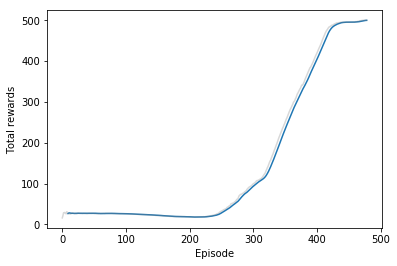

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

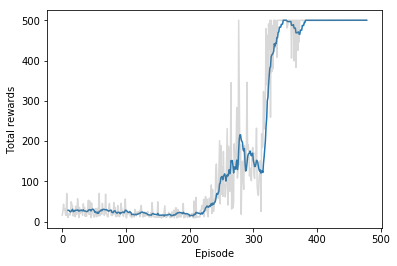

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

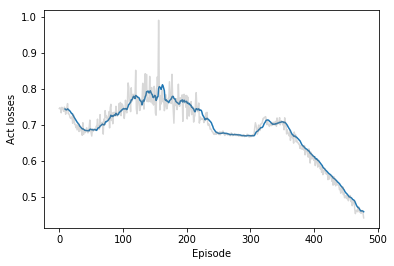

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

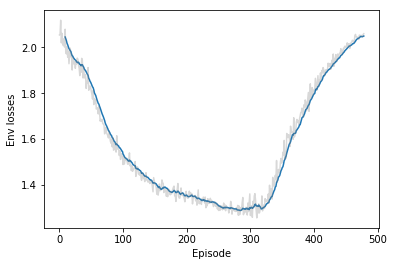

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

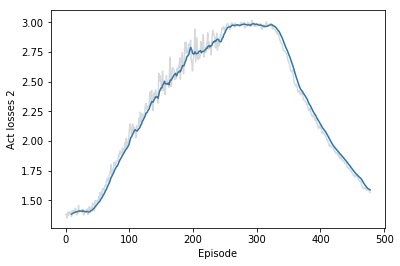

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
